_Main Python Script_

# Loser Queue Project

_LEAL DE ALMEIDA Guillaume_

# Part 1 - Set up 

## Library

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, shapiro

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, accuracy_score

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from xgboost import XGBClassifier

from hmmlearn import hmm

import shap

## Getting data, preparation and some information

In [2]:
df = pd.read_csv('/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/DataSet/match_data_LOL.csv')

In [3]:
df.shape

(51533, 76)

In [4]:
df.describe()

GameVersion      GameTime           kda         kills        deaths  \
count      51533.0  51533.000000  51533.000000  51533.000000  51533.000000   
mean          14.0     27.297644      3.823158      6.007063      5.570819   
std            0.0      6.873860      4.067309      4.536567      3.167921   
min           14.0      1.683333      0.000000      0.000000      0.000000   
25%           14.0     23.450000      1.400000      3.000000      3.000000   
50%           14.0     27.433333      2.500000      5.000000      5.000000   
75%           14.0     31.516667      4.600000      9.000000      8.000000   
max           14.0     69.033333     44.000000     44.000000     23.000000   

            assists     SoloKills  quickSoloKills  killsUnderOwnTurret  \
count  51533.000000  51533.000000    51533.000000         51533.000000   
mean       8.213824      1.182388        0.042167             0.609959   
std        5.798572      1.649076        0.276206             0.916635   
min        0.000000      0.000000        0.000000             0.000000   
25%        4.000000      0.000000        0.000000             0.000000   
50%        7.000000      1.000000        0.000000             0.000000   
75%       11.000000      2.000000        0.000000             1.000000   
max       45.000000     18.000000       15.000000             9.000000   

       killsNearEnemyTurret  ...  commandPings  dangerPings  \
count          51533.000000  ...  51533.000000      51533.0   
mean               1.400423  ...      8.456659          0.0   
std                1.670620  ...      9.029388          0.0   
min                0.000000  ...      0.000000          0.0   
25%                0.000000  ...      2.000000          0.0   
50%                1.000000  ...      6.000000          0.0   
75%                2.000000  ...     12.000000          0.0   
max               16.000000  ...     99.000000          0.0   

       enemyMissingPings  enemyVisionPings  getBackPings  holdPings  \
count       51533.000000      51533.000000  51533.000000    51533.0   
mean            6.846409          3.358023      3.524790        0.0   
std             7.064953          5.800997      5.731917        0.0   
min             0.000000          0.000000      0.000000        0.0   
25%             2.000000          0.000000      0.000000        0.0   
50%             5.000000          1.000000      1.000000        0.0   
75%            10.000000          4.000000      5.000000        0.0   
max            76.000000        160.000000     82.000000        0.0   

       needVisionPings  onMyWayPings     pushPings  visionClearedPings  
count     51533.000000  51533.000000  51533.000000             51533.0  
mean          0.319834     16.600392      0.508315                 0.0  
std           0.973017     18.943111      1.718292                 0.0  
min           0.000000      0.000000      0.000000                 0.0  
25%           0.000000      3.000000      0.000000                 0.0  
50%           0.000000     10.000000      0.000000                 0.0  
75%           0.000000     23.000000      0.000000                 0.0  
max          44.000000    169.000000     66.000000                 0.0  

[8 rows x 66 columns]

In [5]:
df['concat'] = df.apply(lambda row: ''.join(row.astype(str)), axis=1)
dup = df['concat'].duplicated(keep=False)
nb_dup = dup.sum()
print("Number of duplicates based on concatenation of all columns :", nb_dup)
df.drop(columns=['concat'], inplace=True)

Number of duplicates based on concatenation of all columns : 0


In [6]:
details_path = '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/details_match_history.txt'
puuid_summoner_id_mapping = {}
with open(details_path, 'r') as file:
    for line in file:
        parts = line.strip().split(' (')
        if len(parts) == 2:
            puuid = parts[0].strip()
            summoner_id = parts[1].split('):')[0].strip()
            puuid_summoner_id_mapping[puuid] = summoner_id

df['SummonerID'] = df['puuid'].map(puuid_summoner_id_mapping)

In [7]:
#Get the rank 
files = [
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_CHALL.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_GM.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_M.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_D1.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_D2.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_D3.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_D4.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_E1.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_E2.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_E3.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_E4.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_P1.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_P2.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_P3.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_P4.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_G1.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_G2.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_G3.txt',
    '/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/Data_4_API/Summoner_id_G4.txt',
]
ranked = [
    'CHALLENGER',
    'GRAND MASTER',
    'MASTER',
    'DIAMAND',
    'DIAMAND',
    'DIAMAND',
    'DIAMAND',
    'EMERALD',
    'EMERALD',
    'EMERALD',
    'EMERALD',
    'PLATINUM I',
    'PLATINUM II',
    'PLATINUM III',
    'PLATINUM IV',
    'GOLD',
    'GOLD',
    'GOLD',
    'GOLD',
]

summoner_id_rank_mapping = {}

for index, file_path in enumerate(files):
    with open(file_path, 'r') as file:
        summoner_ids = file.read().splitlines()
        for summoner_id in summoner_ids:
            summoner_id_rank_mapping[summoner_id] = ranked[index]


df['elo'] = df['SummonerID'].map(summoner_id_rank_mapping)

In [8]:
nbs = df['SummonerID'].nunique()
print(nbs)

539


In [9]:
df.shape

(51533, 78)

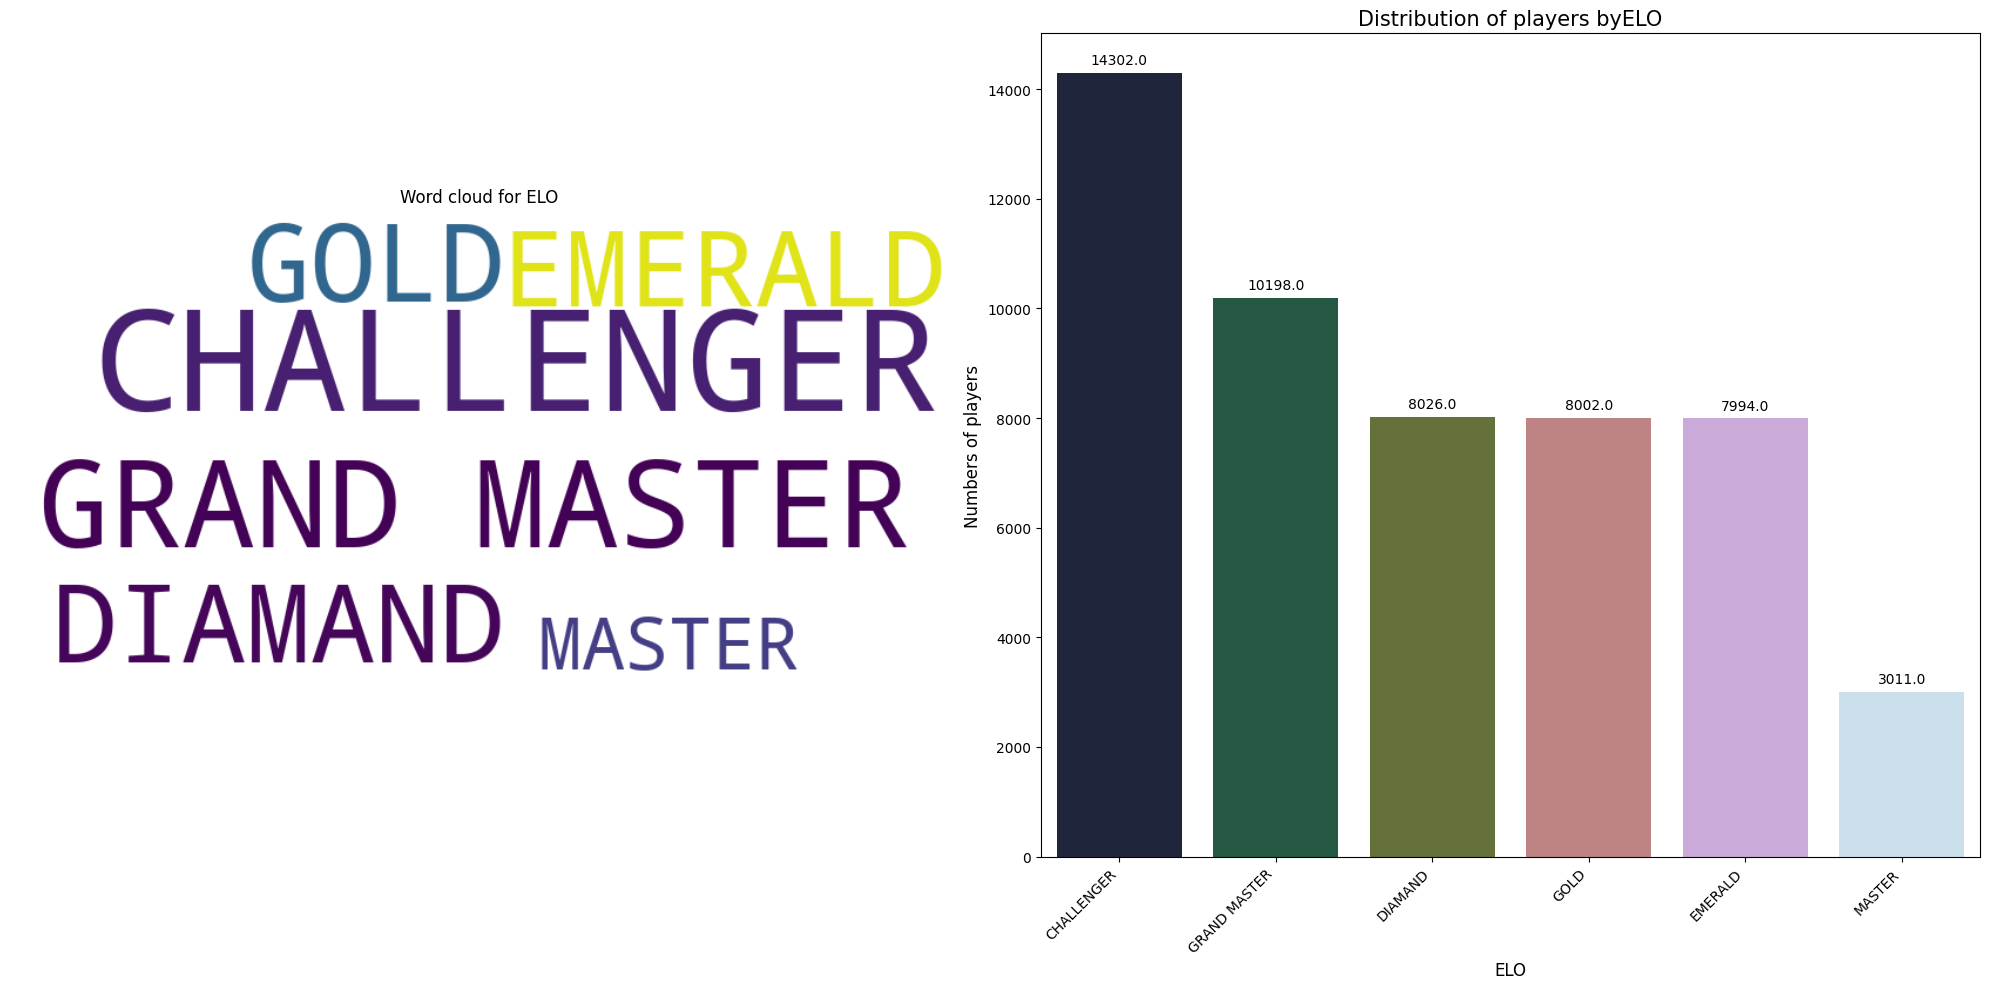

In [10]:
elo_freq = df['elo'].dropna().value_counts().to_dict()
elocloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(elo_freq)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(elocloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for ELO')


elo_counts = df['elo'].value_counts()
plt.subplot(1, 2, 2) 
barplot = sns.barplot(x=elo_counts.index, y=elo_counts.values, palette="cubehelix")
plt.title('Distribution of players byELO', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('Numbers of players', fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()

# Part 2 - Visualization

## Univariate visualization - Qualitative

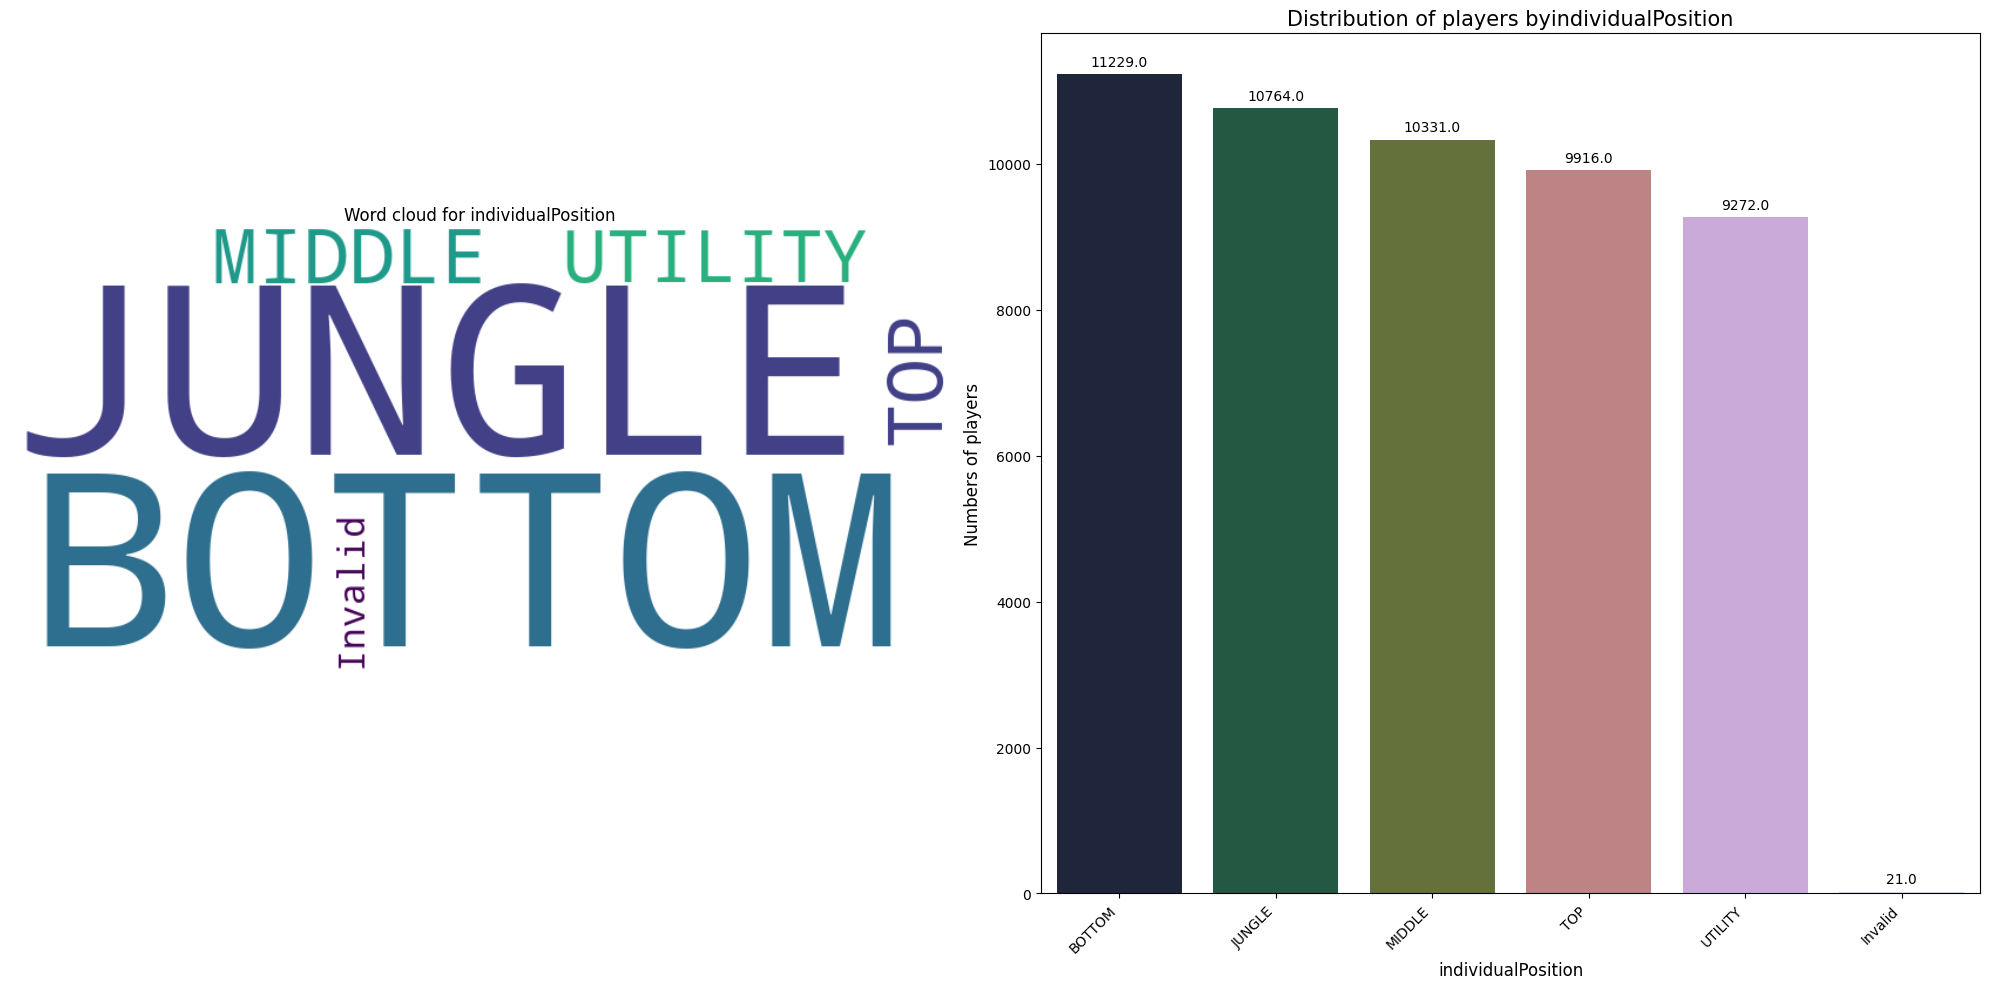

In [11]:
individualPosition_freq = df['individualPosition'].dropna().value_counts().to_dict()
individualPositioncloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(individualPosition_freq)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(individualPositioncloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for individualPosition')


individualPosition_counts = df['individualPosition'].value_counts()
plt.subplot(1, 2, 2) 
barplot = sns.barplot(x=individualPosition_counts.index, y=individualPosition_counts.values, palette="cubehelix")
plt.title('Distribution of players byindividualPosition', fontsize=15)
plt.xlabel('individualPosition', fontsize=12)
plt.ylabel('Numbers of players', fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()


In [12]:
df = df[~df['individualPosition'].isin(['Invalid'])]

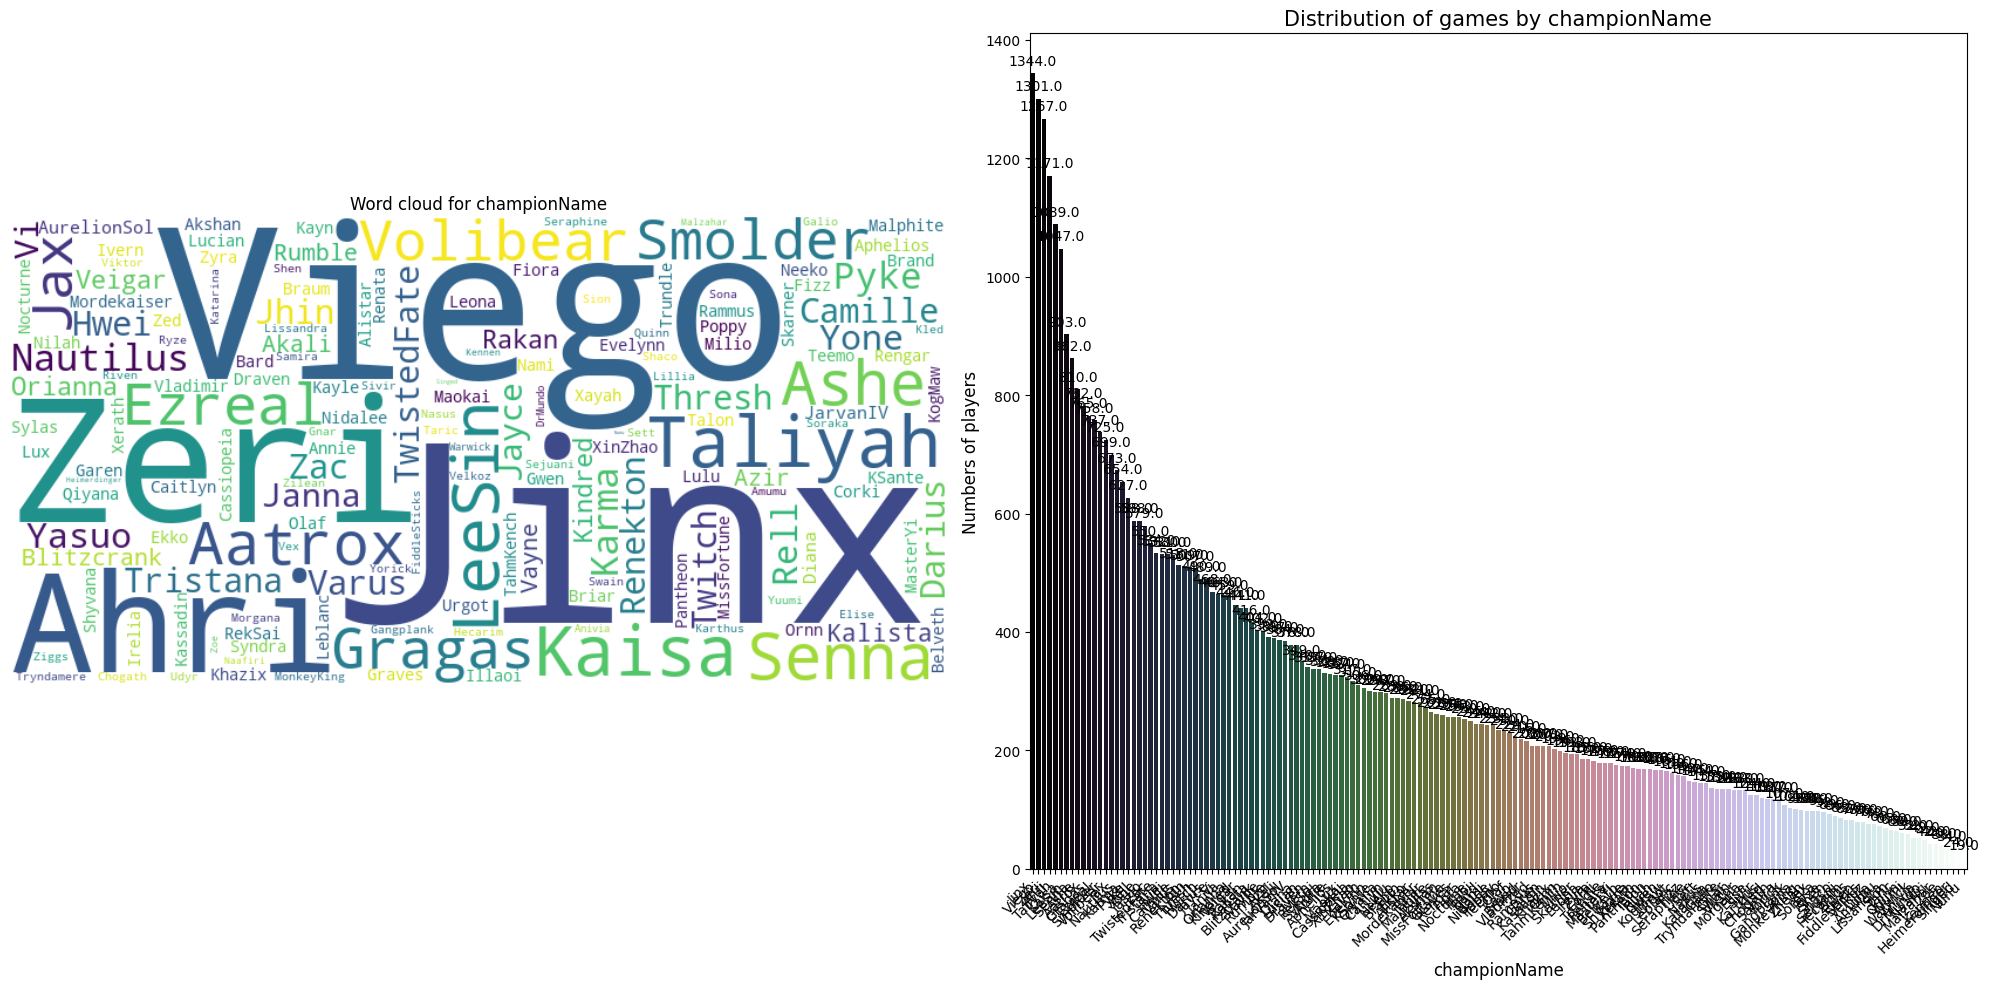

In [13]:
championName_freq = df['championName'].dropna().value_counts().to_dict()
championNamecloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(championName_freq)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(championNamecloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for championName')


championName_counts = df['championName'].value_counts()
plt.subplot(1, 2, 2) 
barplot = sns.barplot(x=championName_counts.index, y=championName_counts.values, palette="cubehelix")
plt.title('Distribution of games by championName', fontsize=15)
plt.xlabel('championName', fontsize=12)
plt.ylabel('Numbers of players', fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()


In [14]:
pd.crosstab(df.championName, "freq")

col_0         freq
championName      
Aatrox         782
Ahri          1171
Akali          387
Akshan         259
Alistar        282
...            ...
Zeri          1267
Ziggs           82
Zilean          98
Zoe             40
Zyra           182

[167 rows x 1 columns]

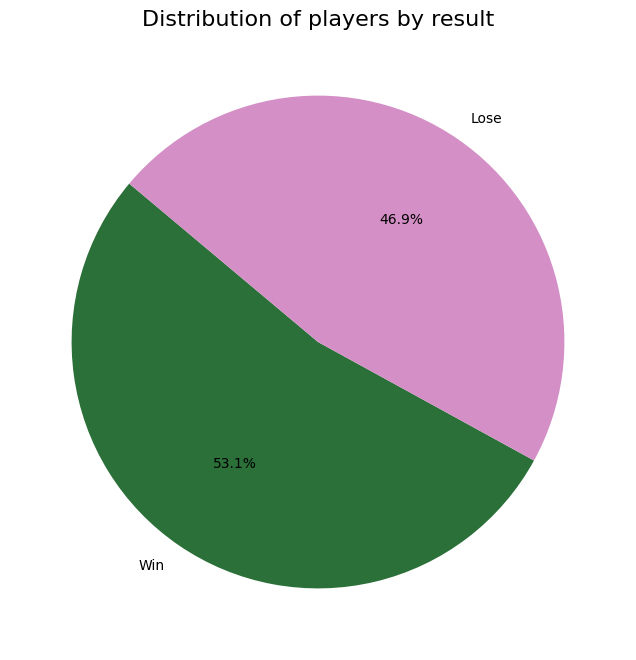

In [15]:
result_counts = df['result'].value_counts()
palette = sns.color_palette("cubehelix", len(result_counts))
plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Distribution of players by result', fontsize=16)
plt.show()

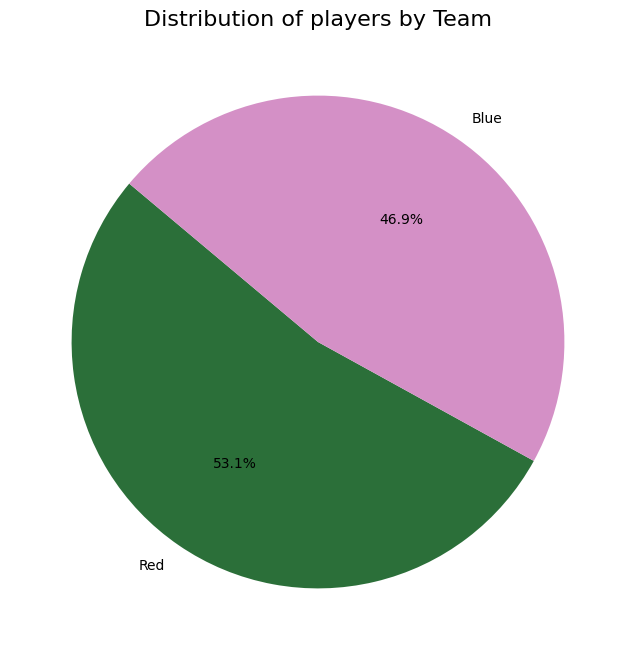

In [16]:
team_counts = df['Team'].value_counts()
palette = sns.color_palette("cubehelix", len(team_counts))
plt.figure(figsize=(8, 8))
plt.pie(team_counts, labels=team_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Distribution of players by Team', fontsize=16)
plt.show()

## Univariate Visualization - Quantitative

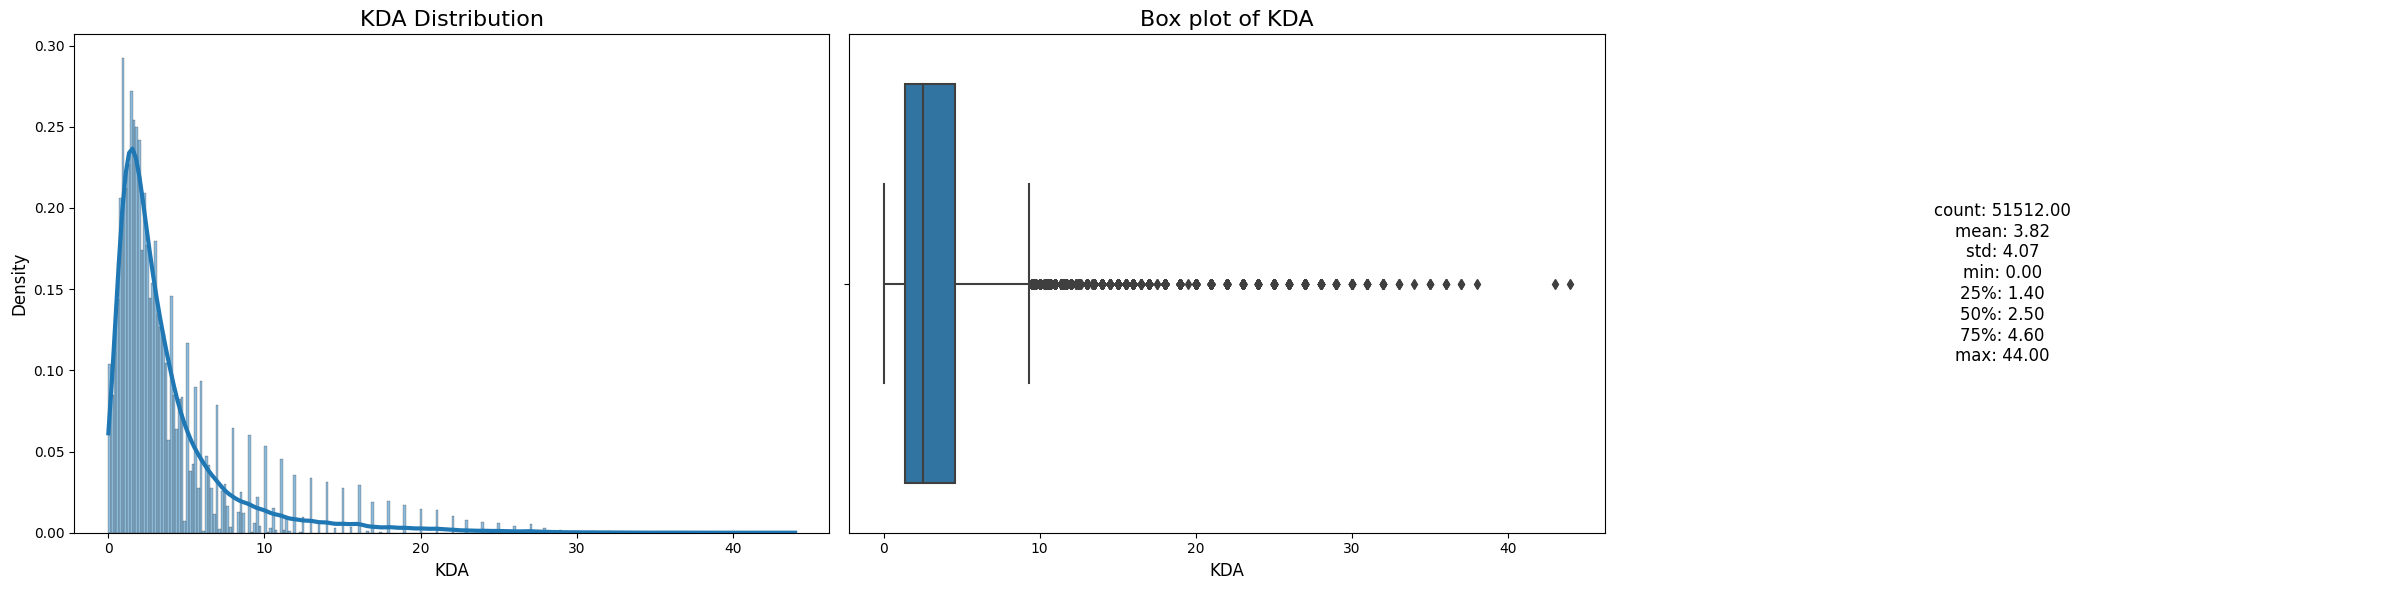

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['kda'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('KDA Distribution', fontsize=16)
ax1.set_xlabel('KDA', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['kda'], ax=ax2)
ax2.set_title('Box plot of KDA', fontsize=16)
ax2.set_xlabel('KDA', fontsize=12)

desc = df['kda'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

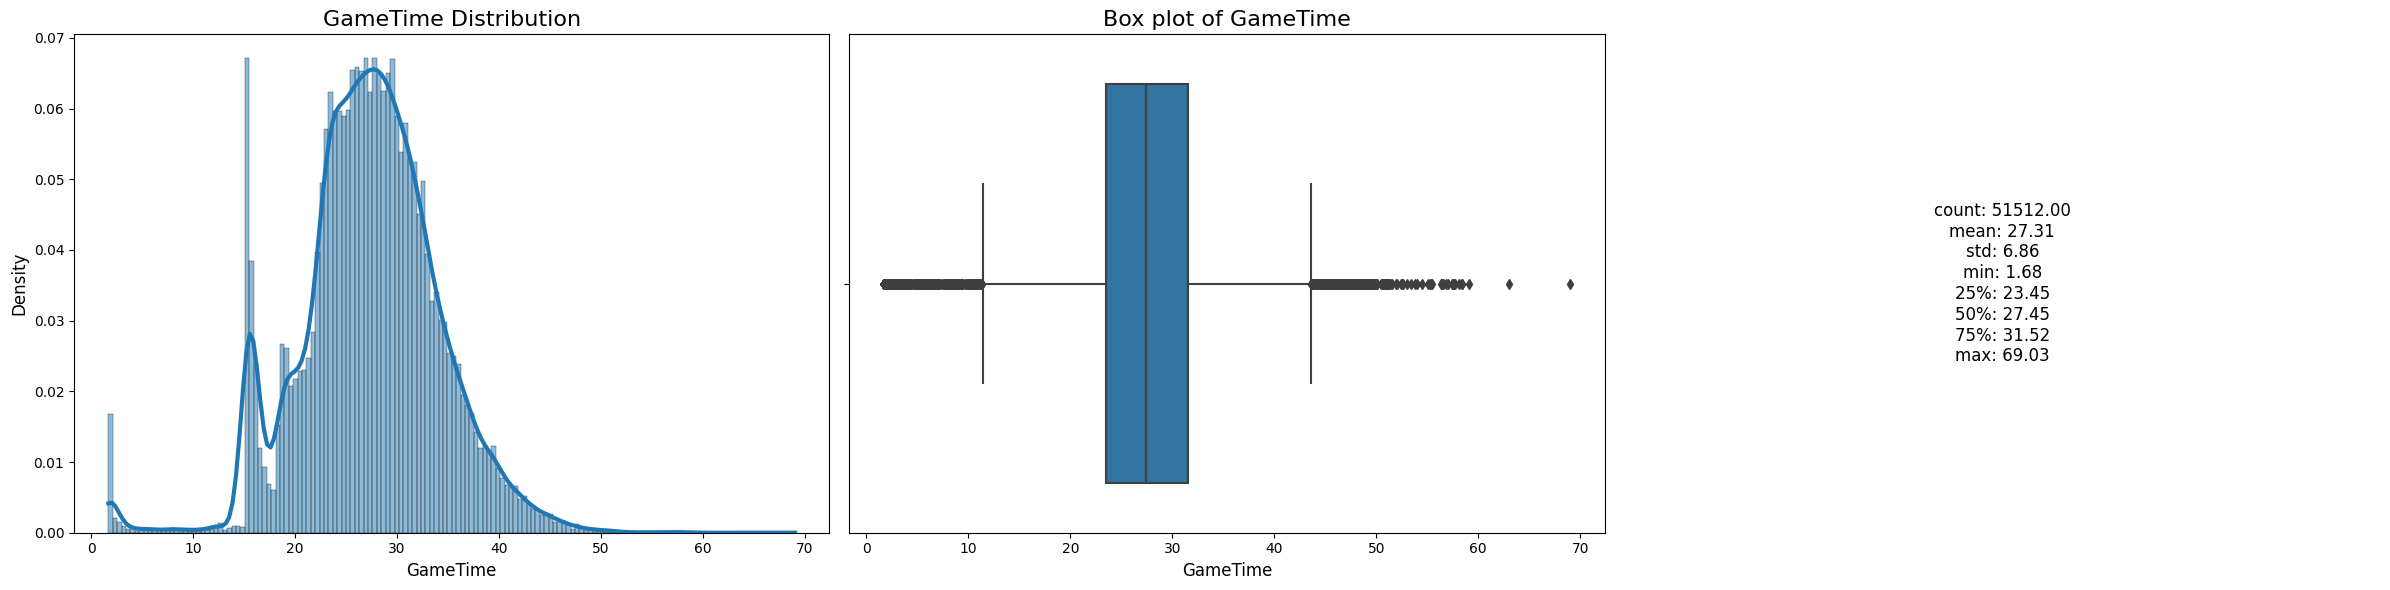

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['GameTime'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('GameTime Distribution', fontsize=16)
ax1.set_xlabel('GameTime', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['GameTime'], ax=ax2)
ax2.set_title('Box plot of GameTime', fontsize=16)
ax2.set_xlabel('GameTime', fontsize=12)

desc = df['GameTime'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

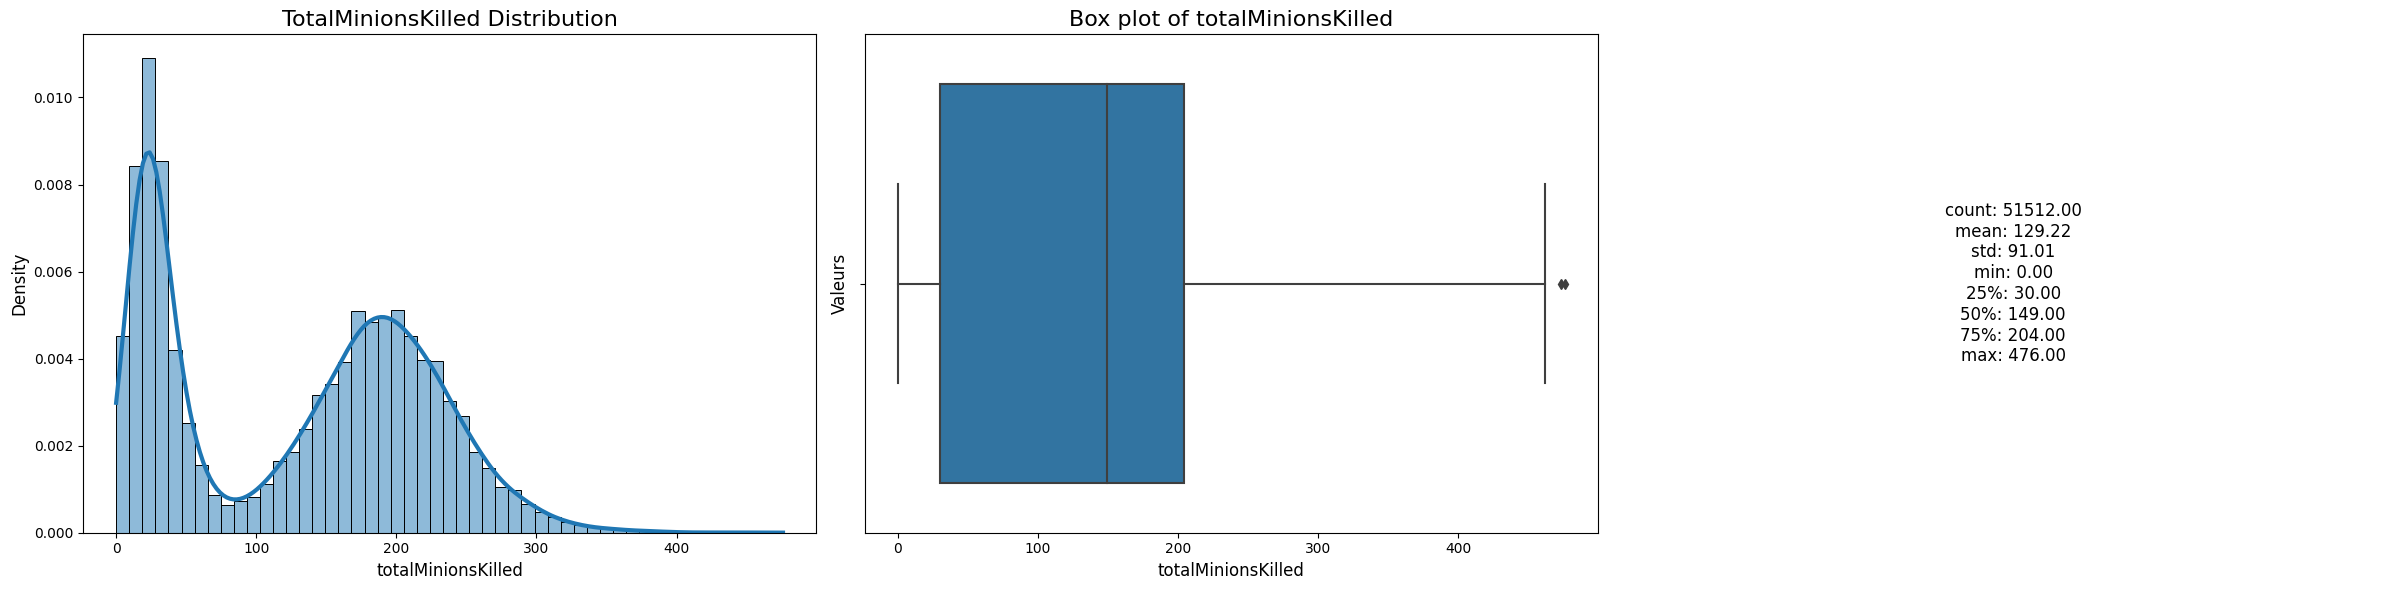

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['totalMinionsKilled'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('TotalMinionsKilled Distribution', fontsize=16)
ax1.set_xlabel('totalMinionsKilled', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['totalMinionsKilled'], ax=ax2)
ax2.set_title('Box plot of totalMinionsKilled', fontsize=16)
ax2.set_xlabel('totalMinionsKilled', fontsize=12)
ax2.set_ylabel('Valeurs', fontsize=12)

desc = df['totalMinionsKilled'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

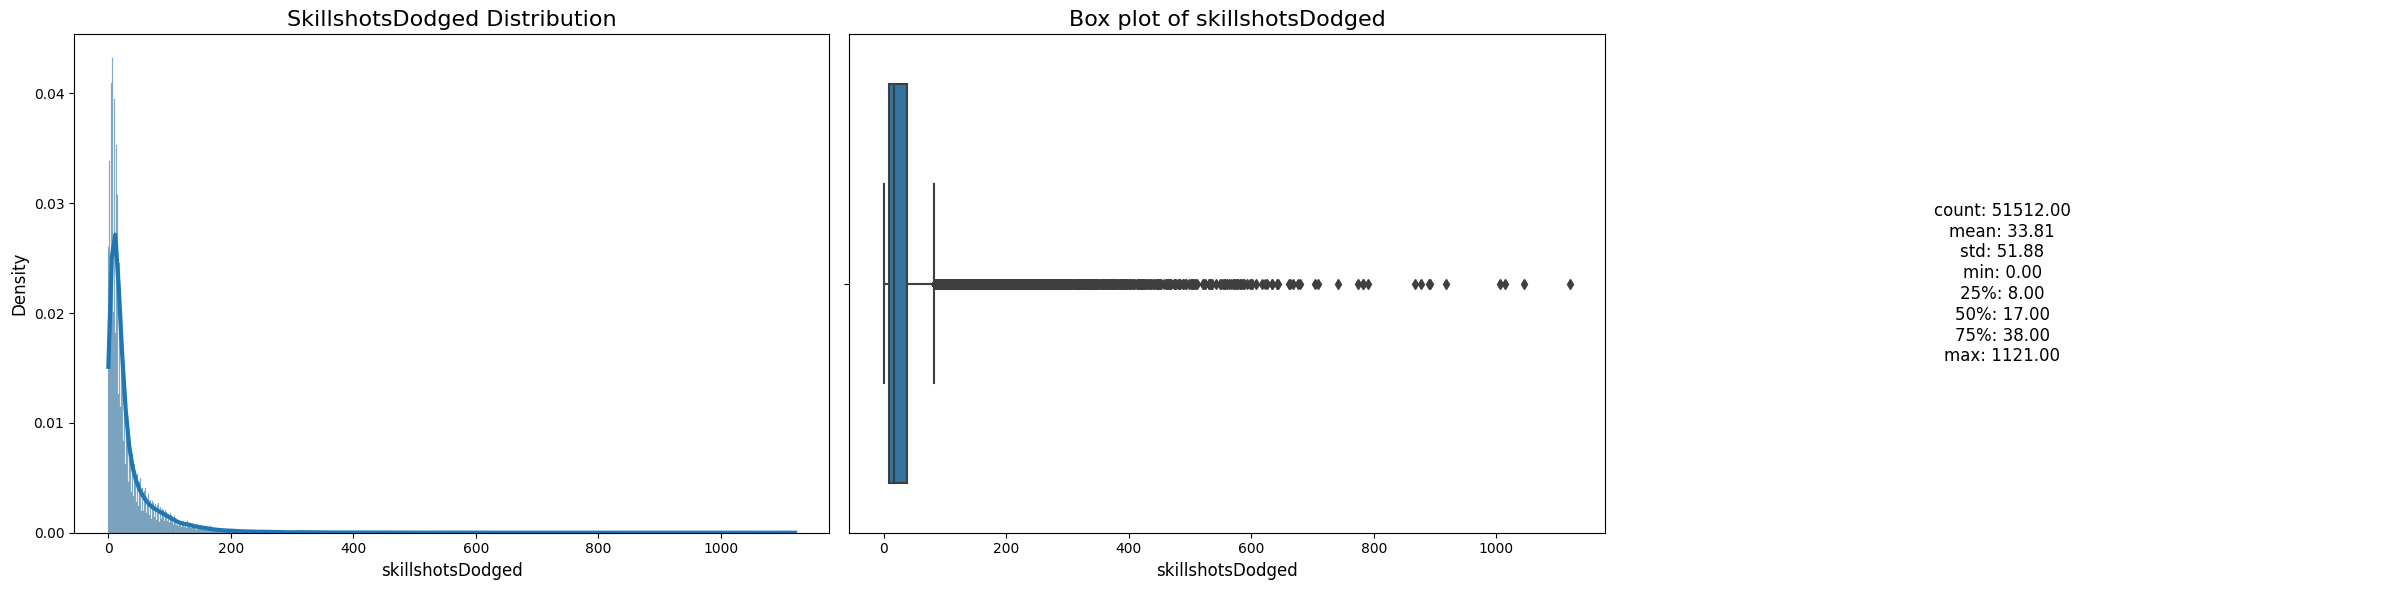

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['skillshotsDodged'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('SkillshotsDodged Distribution', fontsize=16)
ax1.set_xlabel('skillshotsDodged', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['skillshotsDodged'], ax=ax2)
ax2.set_title('Box plot of skillshotsDodged', fontsize=16)
ax2.set_xlabel('skillshotsDodged', fontsize=12)

desc = df['skillshotsDodged'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

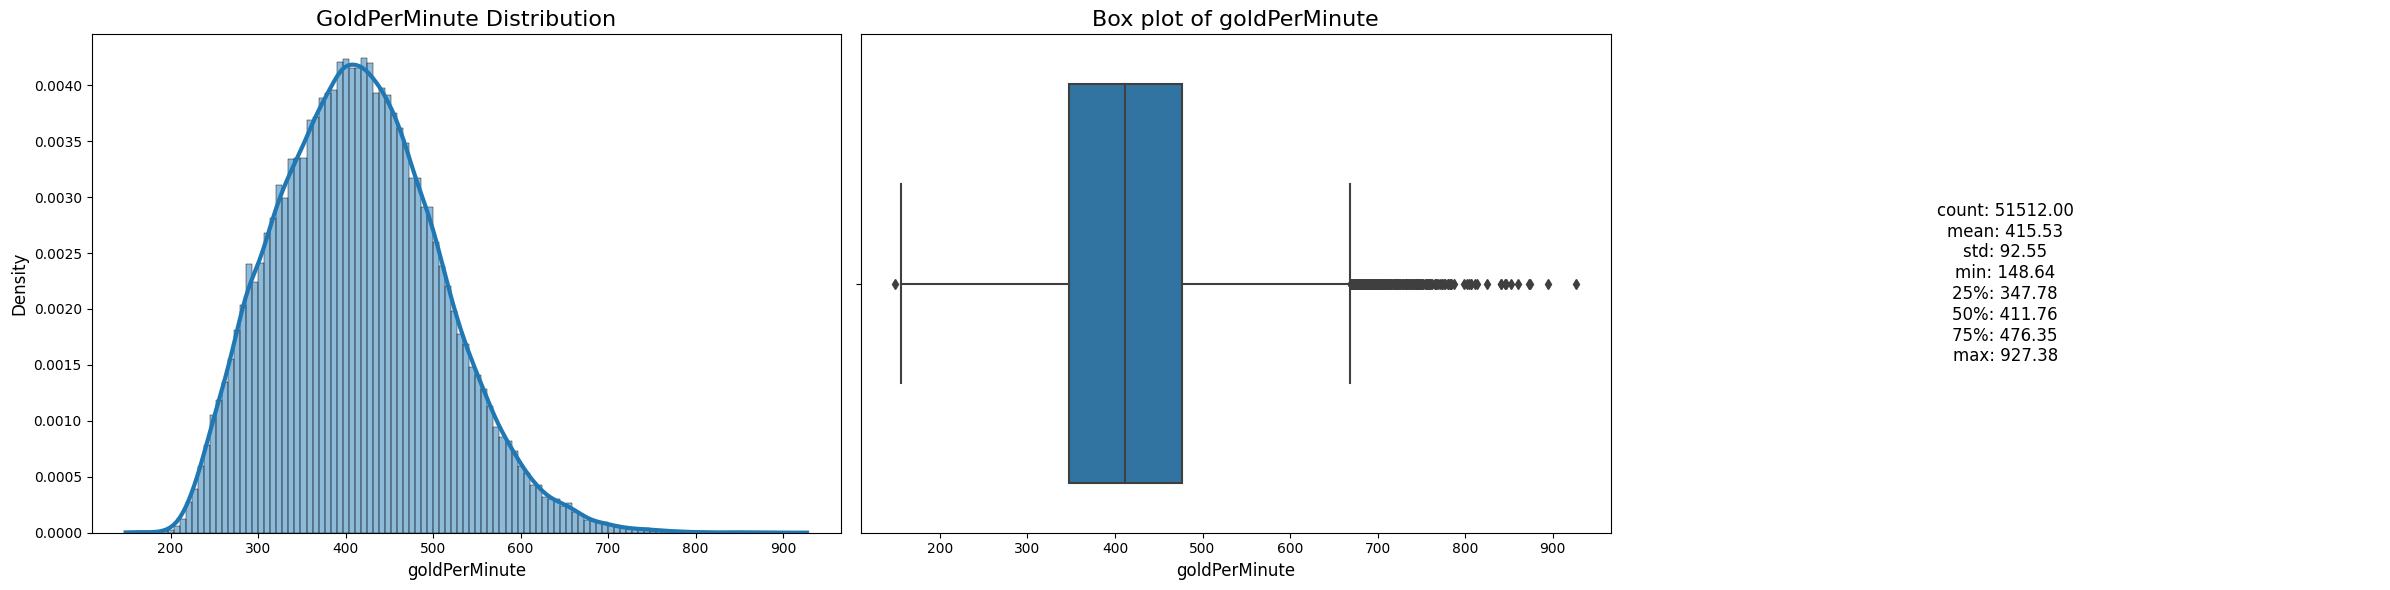

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['goldPerMinute'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('GoldPerMinute Distribution', fontsize=16)
ax1.set_xlabel('goldPerMinute', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['goldPerMinute'], ax=ax2)
ax2.set_title('Box plot of goldPerMinute', fontsize=16)
ax2.set_xlabel('goldPerMinute', fontsize=12)

desc = df['goldPerMinute'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

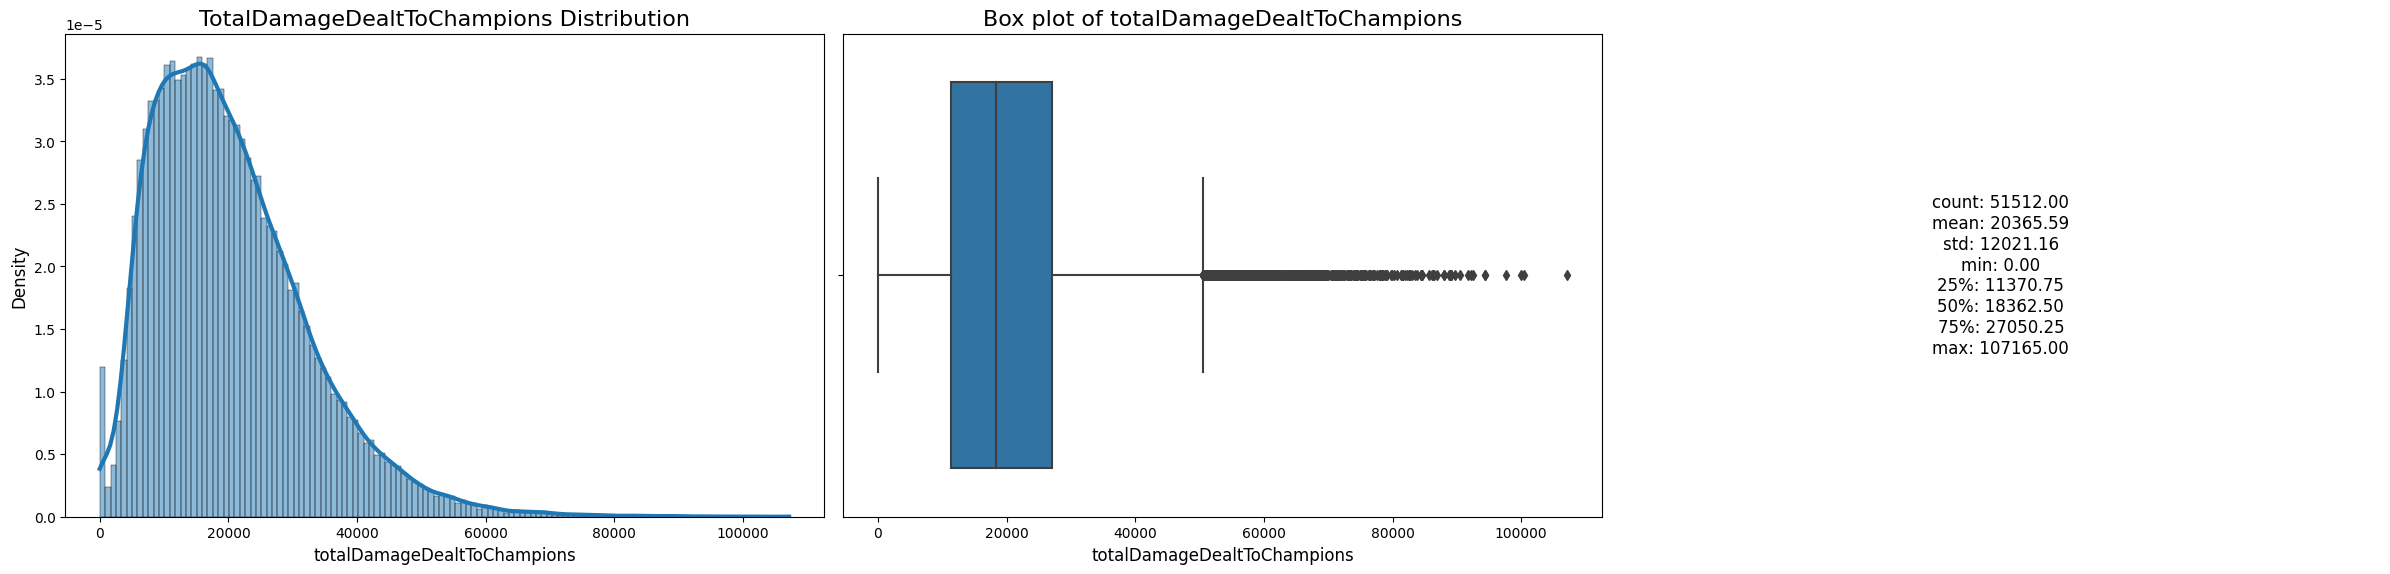

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['totalDamageDealtToChampions'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('TotalDamageDealtToChampions Distribution', fontsize=16)
ax1.set_xlabel('totalDamageDealtToChampions', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['totalDamageDealtToChampions'], ax=ax2)
ax2.set_title('Box plot of totalDamageDealtToChampions', fontsize=16)
ax2.set_xlabel('totalDamageDealtToChampions', fontsize=12)

desc = df['totalDamageDealtToChampions'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

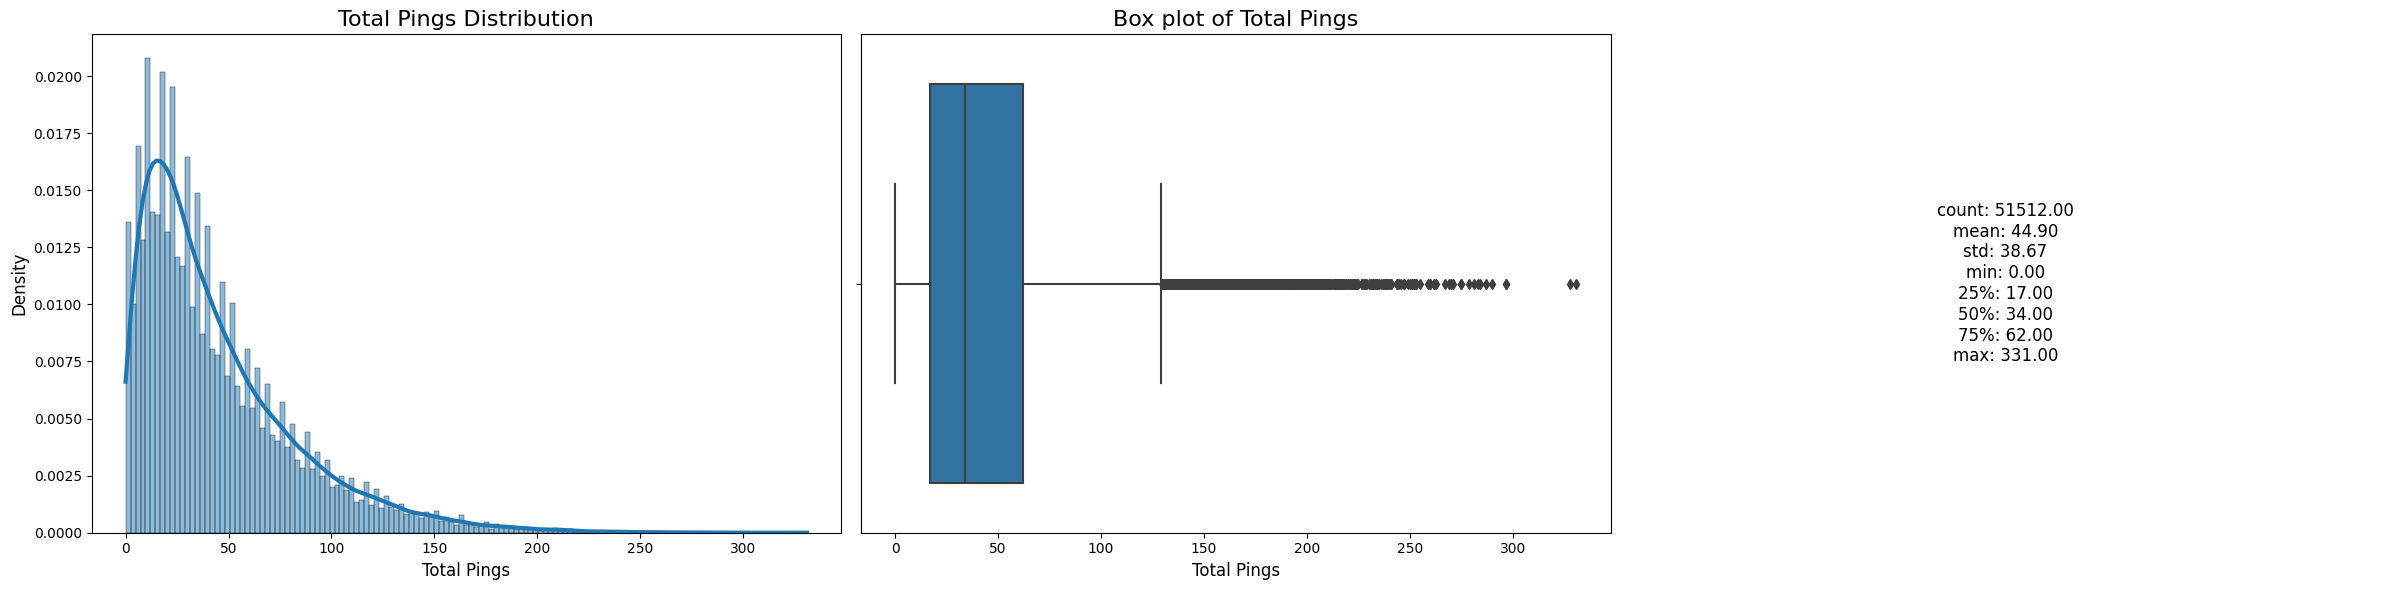

In [23]:
df['totalPings'] = df[['allInPings', 'assistMePings', 'basicPings', 'commandPings', 'dangerPings', 
                       'enemyMissingPings', 'enemyVisionPings', 'getBackPings', 'holdPings', 
                       'needVisionPings', 'onMyWayPings', 'pushPings', 'visionClearedPings']].sum(axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(df['totalPings'], kde=True, stat="density", line_kws={'linewidth': 3}, ax=ax1)
ax1.set_title('Total Pings Distribution', fontsize=16)
ax1.set_xlabel('Total Pings', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(x=df['totalPings'], ax=ax2)
ax2.set_title('Box plot of Total Pings', fontsize=16)
ax2.set_xlabel('Total Pings', fontsize=12)

desc = df['totalPings'].describe()
stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in desc.items()])
ax3.axis('off')
ax3.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

## Bivariate visualization - Qualitative

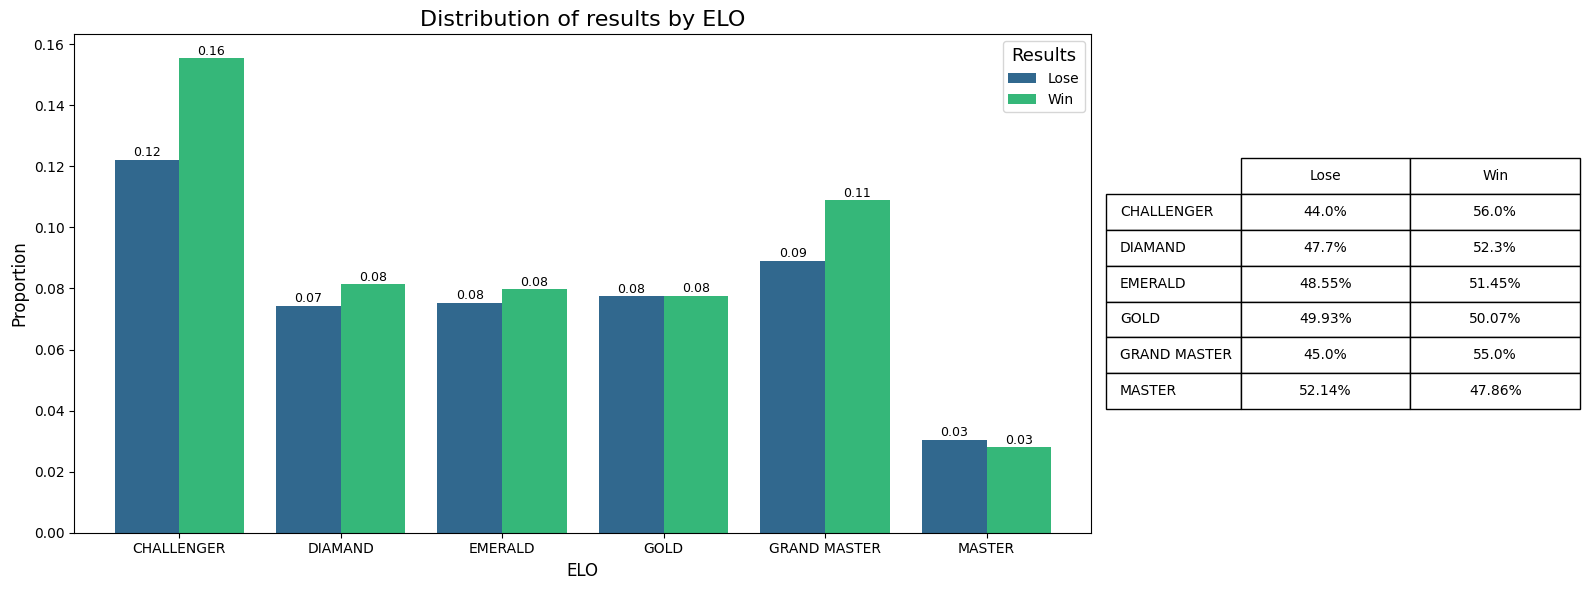

In [24]:
t = pd.crosstab(df.elo, df.result, normalize=True)

palette = sns.color_palette("viridis", len(t.columns))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
t.plot(kind='bar', color=palette, width=0.8, ax=ax1)

ax1.set_title('Distribution of results by ELO', fontsize=16)
ax1.set_xlabel('ELO', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Results', title_fontsize='13', fontsize='10', loc='upper right')


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.2f}', (x + width/2, y + height), ha='center', va='center', fontsize=9, color='black', xytext=(0,5), textcoords='offset points')

tab = pd.crosstab(df.elo, df.result, normalize='index')
tab2 = (tab * 100).round(2).astype(str) + '%'
ax2.axis('off')
table = ax2.table(cellText=tab2.values, colLabels=tab2.columns, rowLabels=tab2.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

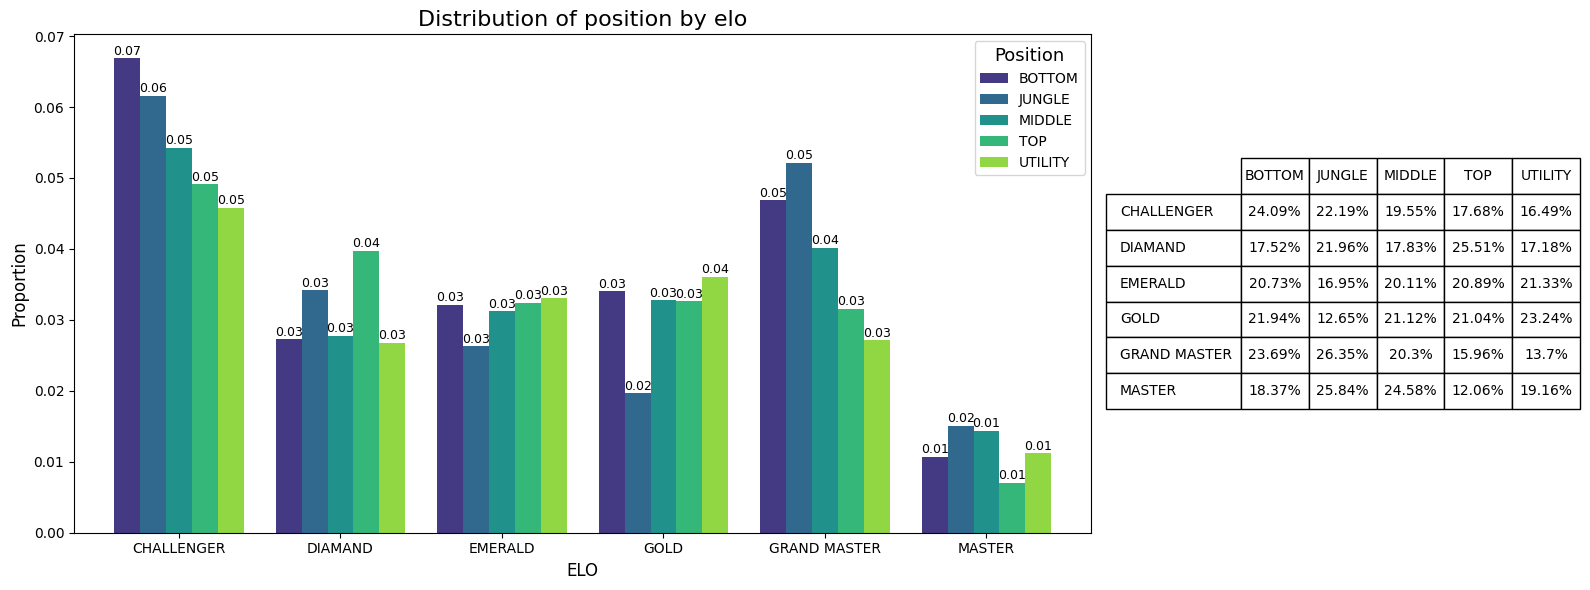

In [25]:
t = pd.crosstab(df.elo, df.individualPosition, normalize=True)

palette = sns.color_palette("viridis", len(t.columns))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
t.plot(kind='bar', color=palette, width=0.8, ax=ax1)

ax1.set_title('Distribution of position by elo', fontsize=16)
ax1.set_xlabel('ELO', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Position', title_fontsize='13', fontsize='10', loc='upper right')


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.2f}', (x + width/2, y + height), ha='center', va='center', fontsize=9, color='black', xytext=(0,5), textcoords='offset points')

tab = pd.crosstab(df.elo, df.individualPosition, normalize='index')
tab2 = (tab * 100).round(2).astype(str) + '%'
ax2.axis('off')
table = ax2.table(cellText=tab2.values, colLabels=tab2.columns, rowLabels=tab2.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

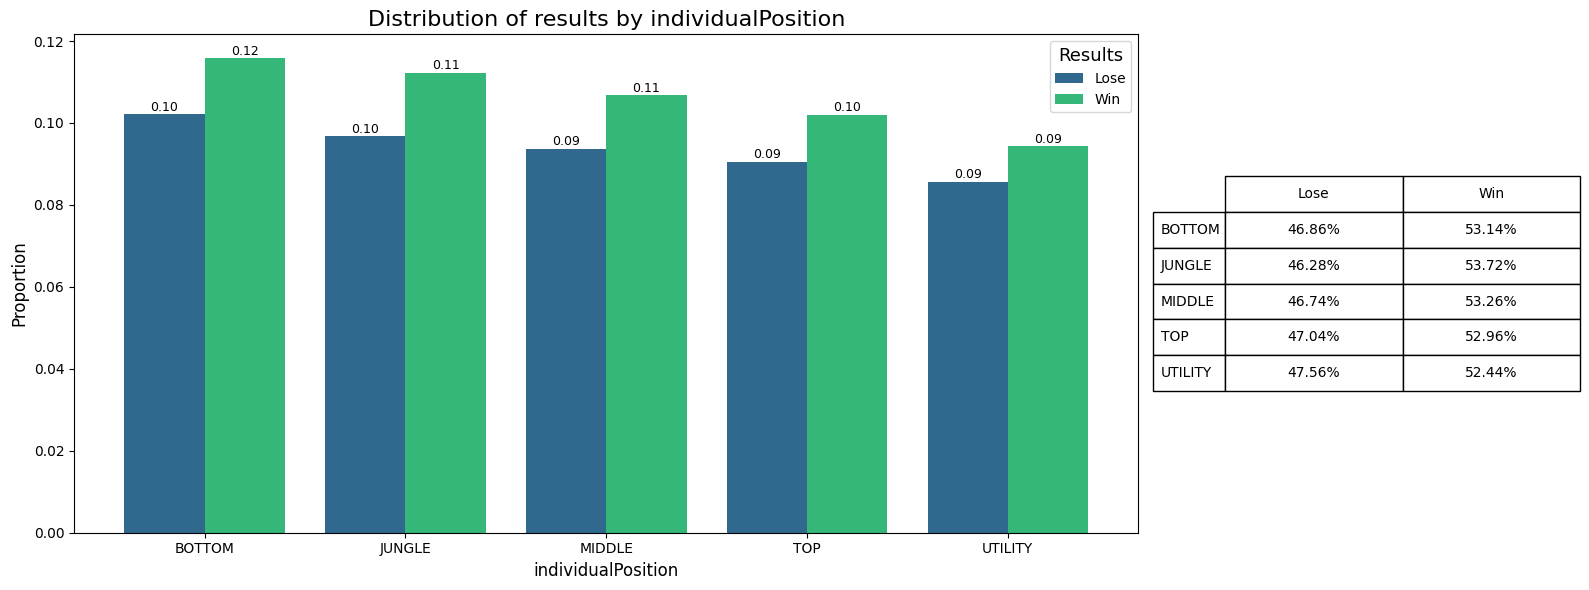

In [26]:
t = pd.crosstab(df.individualPosition, df.result, normalize=True)

palette = sns.color_palette("viridis", len(t.columns))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
t.plot(kind='bar', color=palette, width=0.8, ax=ax1)

ax1.set_title('Distribution of results by individualPosition', fontsize=16)
ax1.set_xlabel('individualPosition', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Results', title_fontsize='13', fontsize='10', loc='upper right')


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.2f}', (x + width/2, y + height), ha='center', va='center', fontsize=9, color='black', xytext=(0,5), textcoords='offset points')

tab = pd.crosstab(df.individualPosition, df.result, normalize='index')
tab2 = (tab * 100).round(2).astype(str) + '%'
ax2.axis('off')
table = ax2.table(cellText=tab2.values, colLabels=tab2.columns, rowLabels=tab2.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

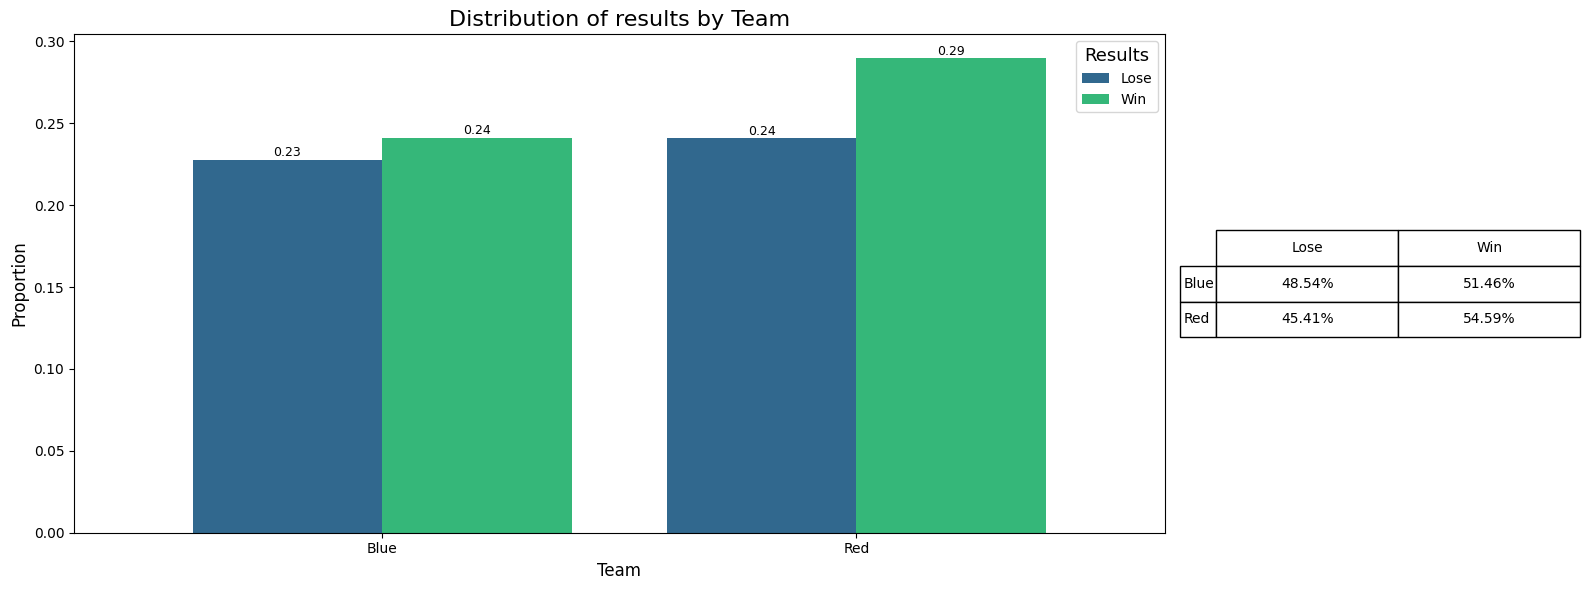

In [27]:
t = pd.crosstab(df.Team, df.result, normalize=True)

palette = sns.color_palette("viridis", len(t.columns))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
t.plot(kind='bar', color=palette, width=0.8, ax=ax1)

ax1.set_title('Distribution of results by Team', fontsize=16)
ax1.set_xlabel('Team', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Results', title_fontsize='13', fontsize='10', loc='upper right')


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.2f}', (x + width/2, y + height), ha='center', va='center', fontsize=9, color='black', xytext=(0,5), textcoords='offset points')

tab = pd.crosstab(df.Team, df.result, normalize='index')
tab2 = (tab * 100).round(2).astype(str) + '%'
ax2.axis('off')
table = ax2.table(cellText=tab2.values, colLabels=tab2.columns, rowLabels=tab2.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

## Bivariate visualization - Quantitative

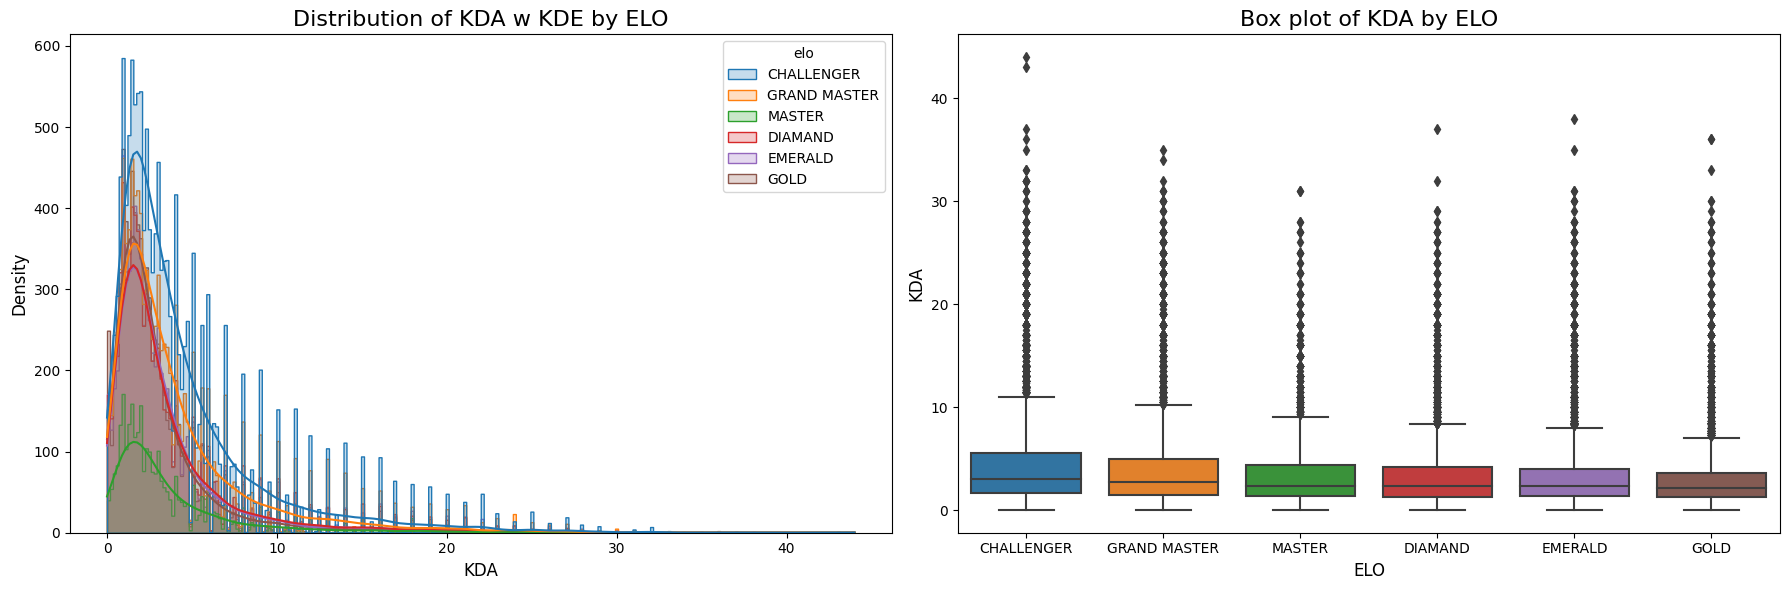

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='kda', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of KDA w KDE by ELO', fontsize=16)
ax1.set_xlabel('KDA', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

sns.boxplot(data=df, x='elo', y='kda', ax=ax2)
ax2.set_title('Box plot of KDA by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('KDA', fontsize=12)

plt.tight_layout()
plt.show()

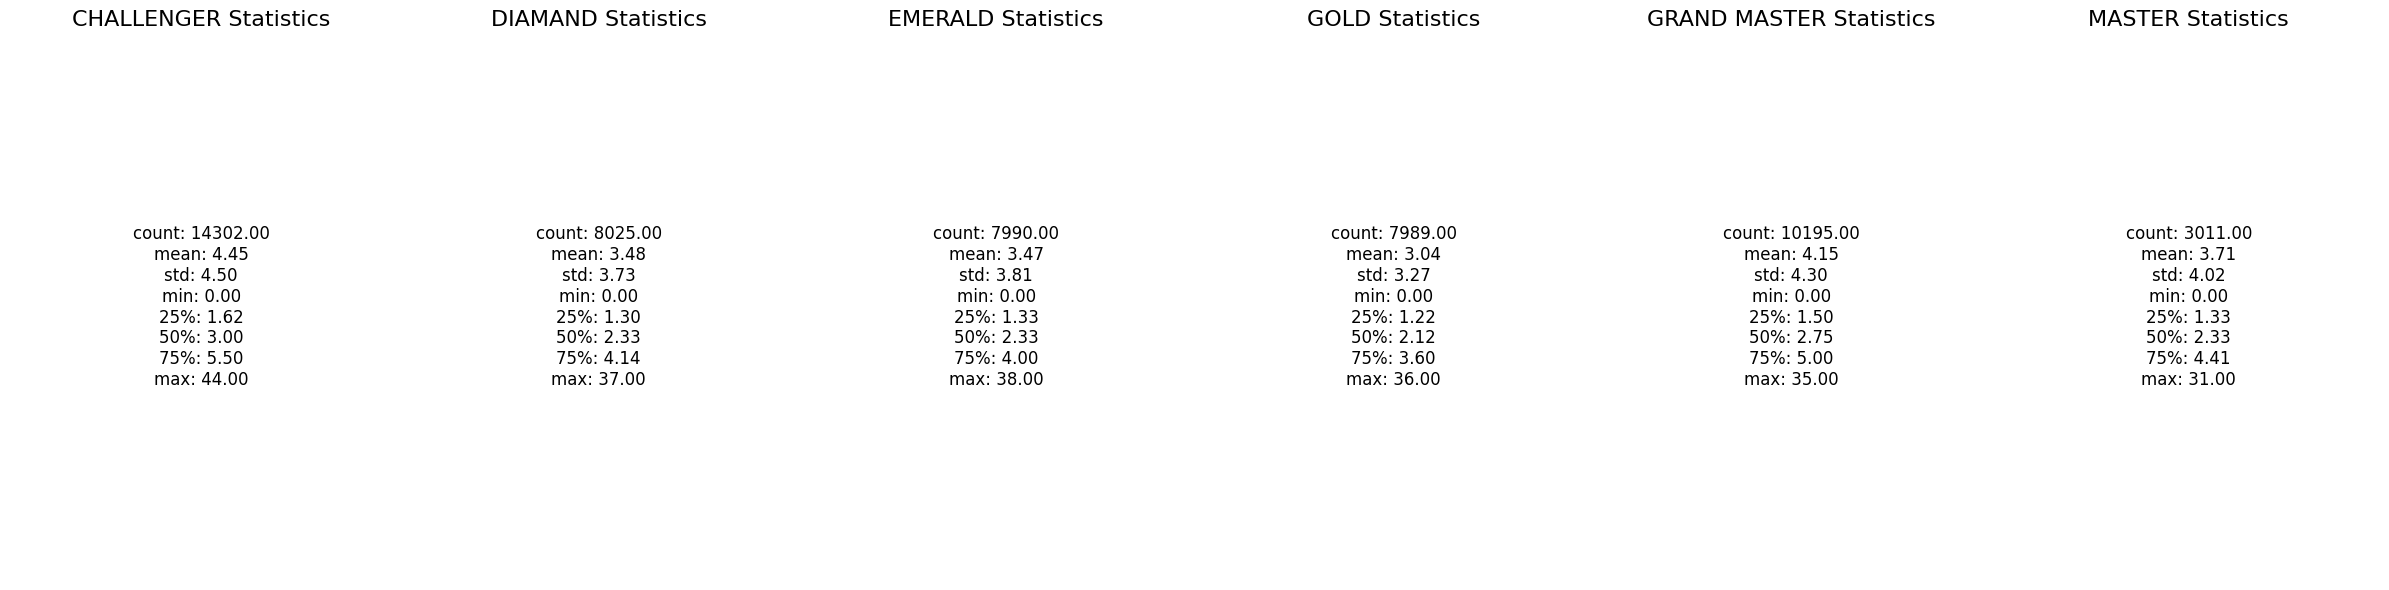

In [29]:
stats_data = df.groupby('elo')['kda'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  


for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

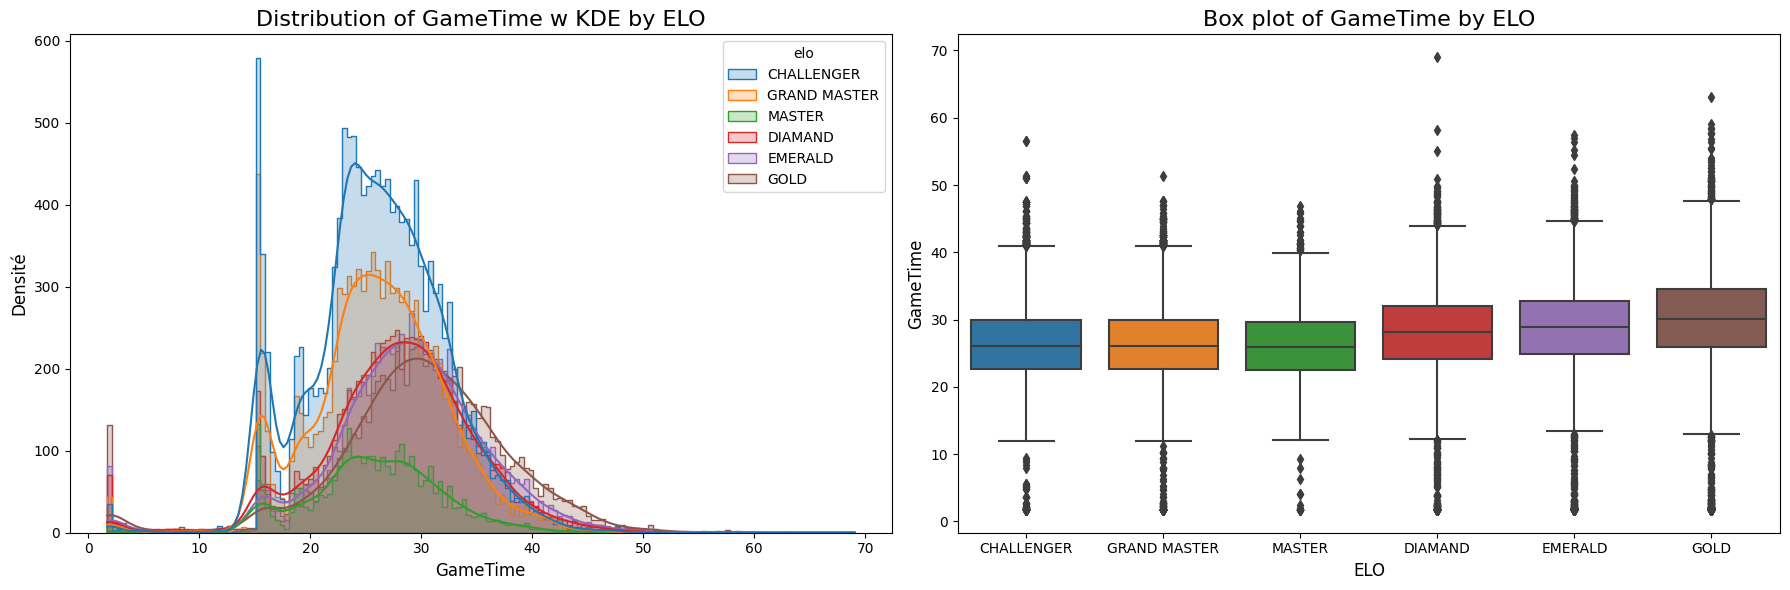

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='GameTime', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of GameTime w KDE by ELO', fontsize=16)
ax1.set_xlabel('GameTime', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='GameTime', ax=ax2)
ax2.set_title('Box plot of GameTime by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('GameTime', fontsize=12)

plt.tight_layout()
plt.show()

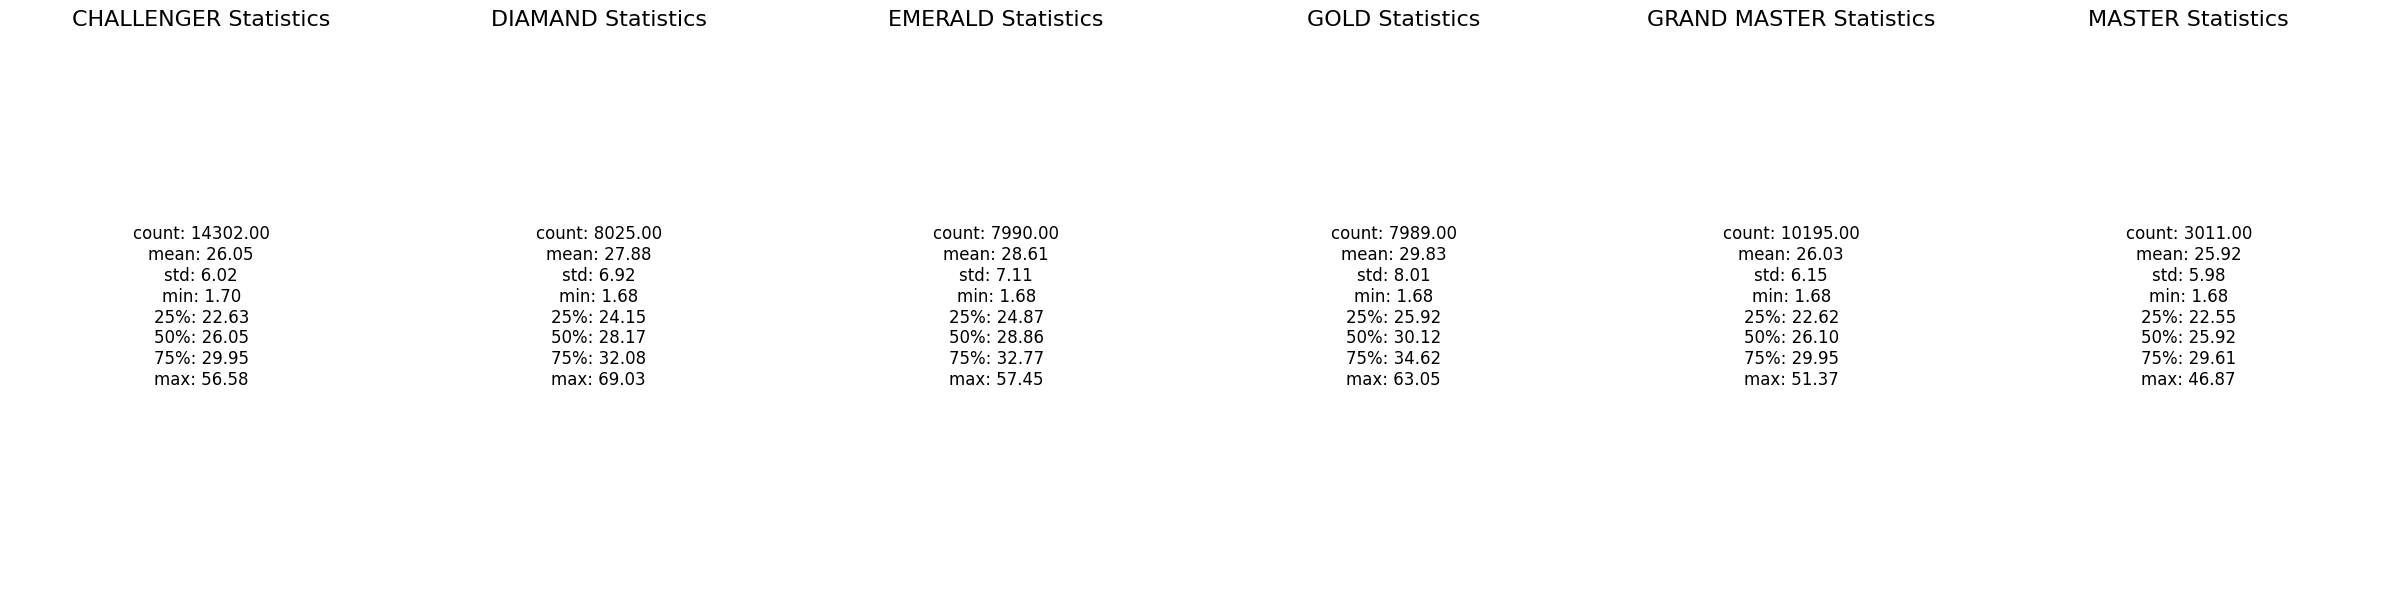

In [31]:
stats_data = df.groupby('elo')['GameTime'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

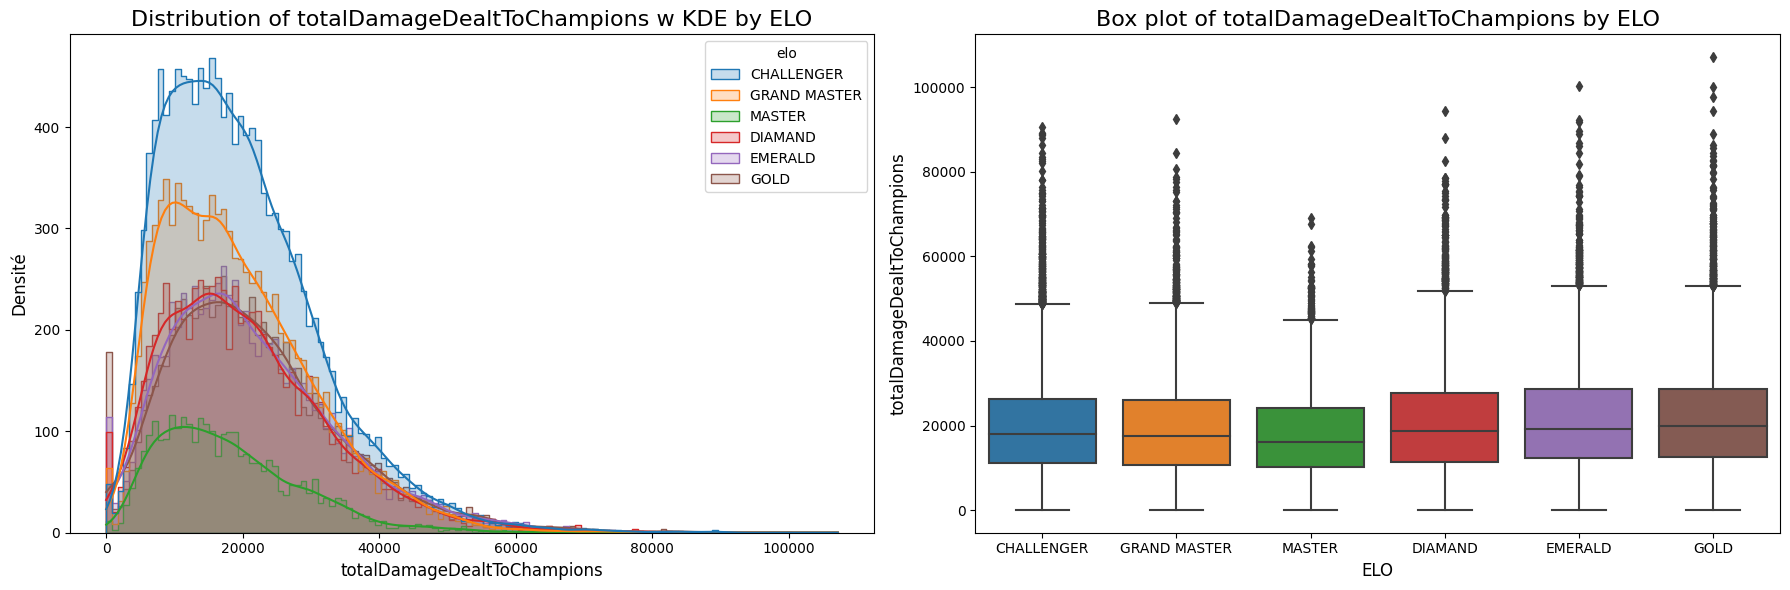

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='totalDamageDealtToChampions', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of totalDamageDealtToChampions w KDE by ELO', fontsize=16)
ax1.set_xlabel('totalDamageDealtToChampions', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='totalDamageDealtToChampions', ax=ax2)
ax2.set_title('Box plot of totalDamageDealtToChampions by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('totalDamageDealtToChampions', fontsize=12)

plt.tight_layout()
plt.show()

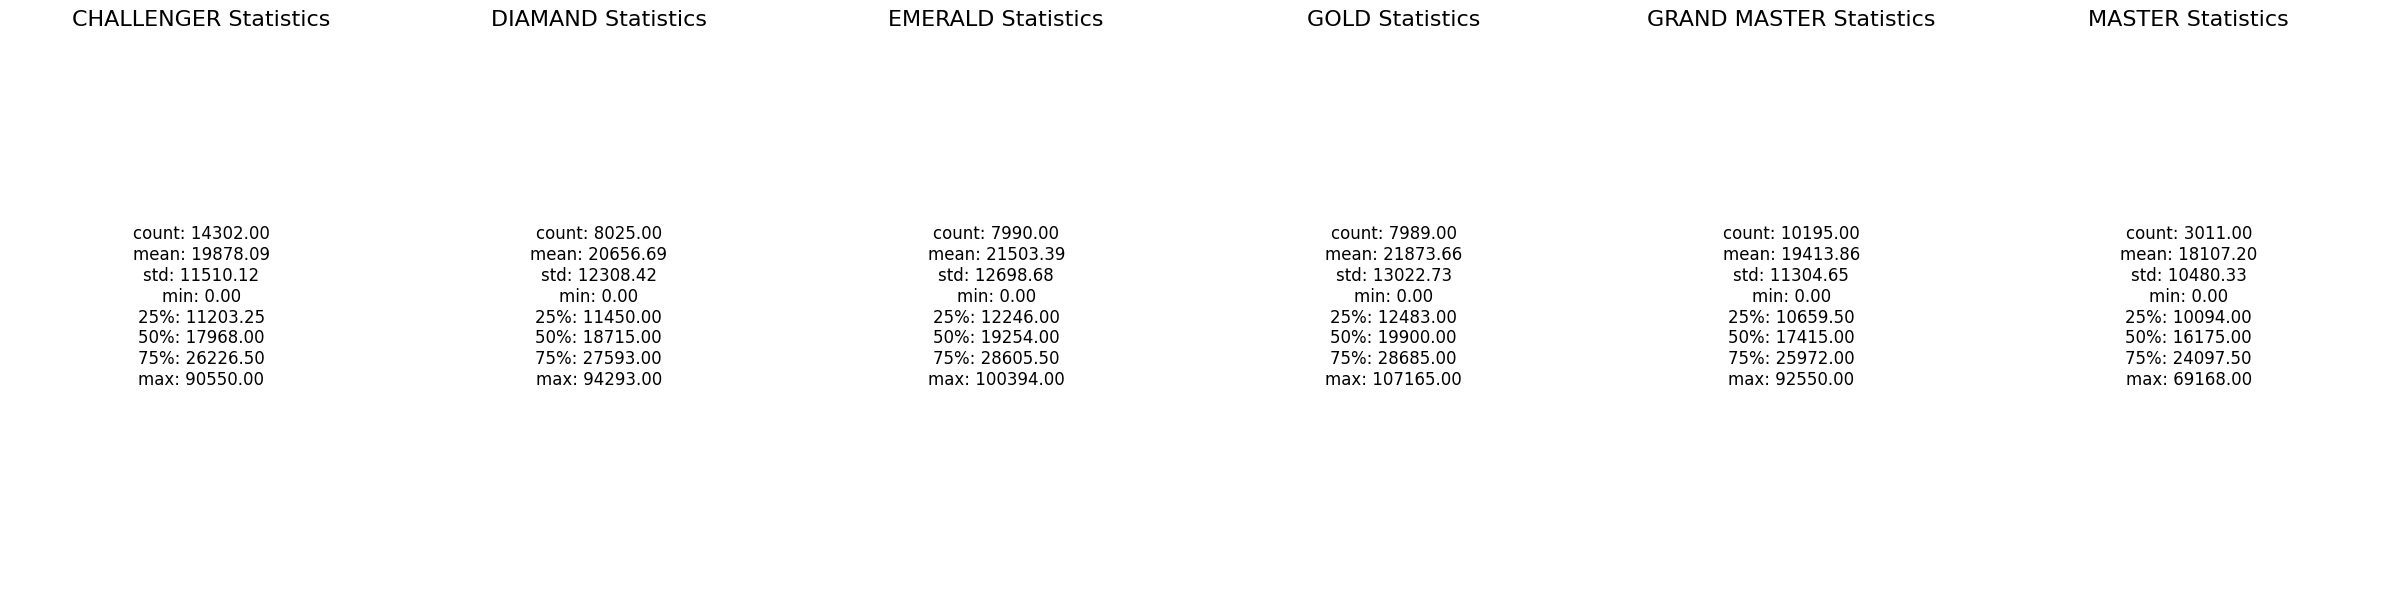

In [33]:
stats_data = df.groupby('elo')['totalDamageDealtToChampions'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

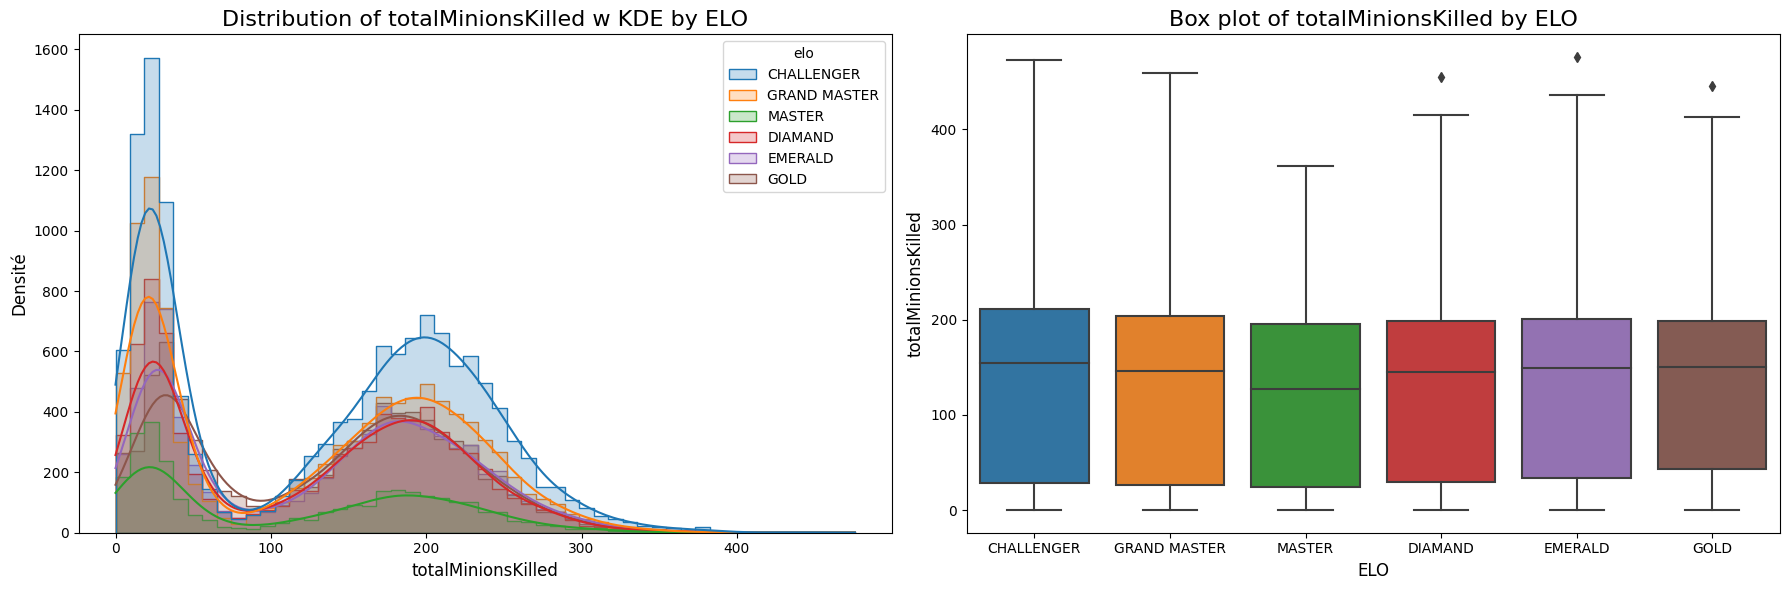

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='totalMinionsKilled', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of totalMinionsKilled w KDE by ELO', fontsize=16)
ax1.set_xlabel('totalMinionsKilled', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='totalMinionsKilled', ax=ax2)
ax2.set_title('Box plot of totalMinionsKilled by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('totalMinionsKilled', fontsize=12)

plt.tight_layout()
plt.show()

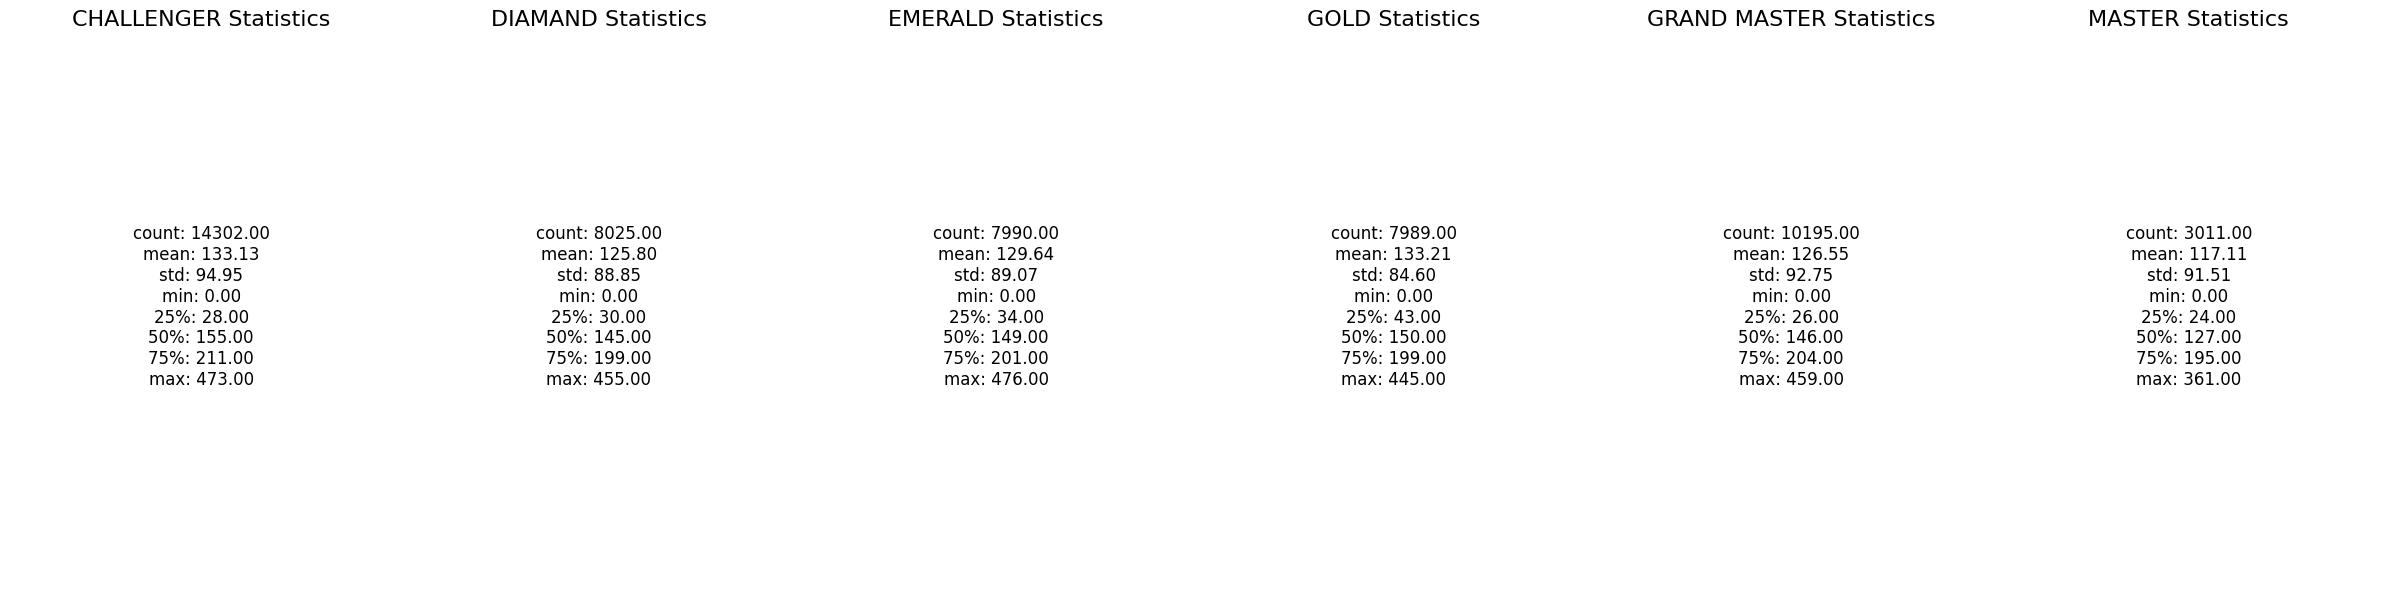

In [35]:
stats_data = df.groupby('elo')['totalMinionsKilled'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

In [36]:
df['MinionsKilledPerMin'] = df['totalMinionsKilled']/df['GameTime']

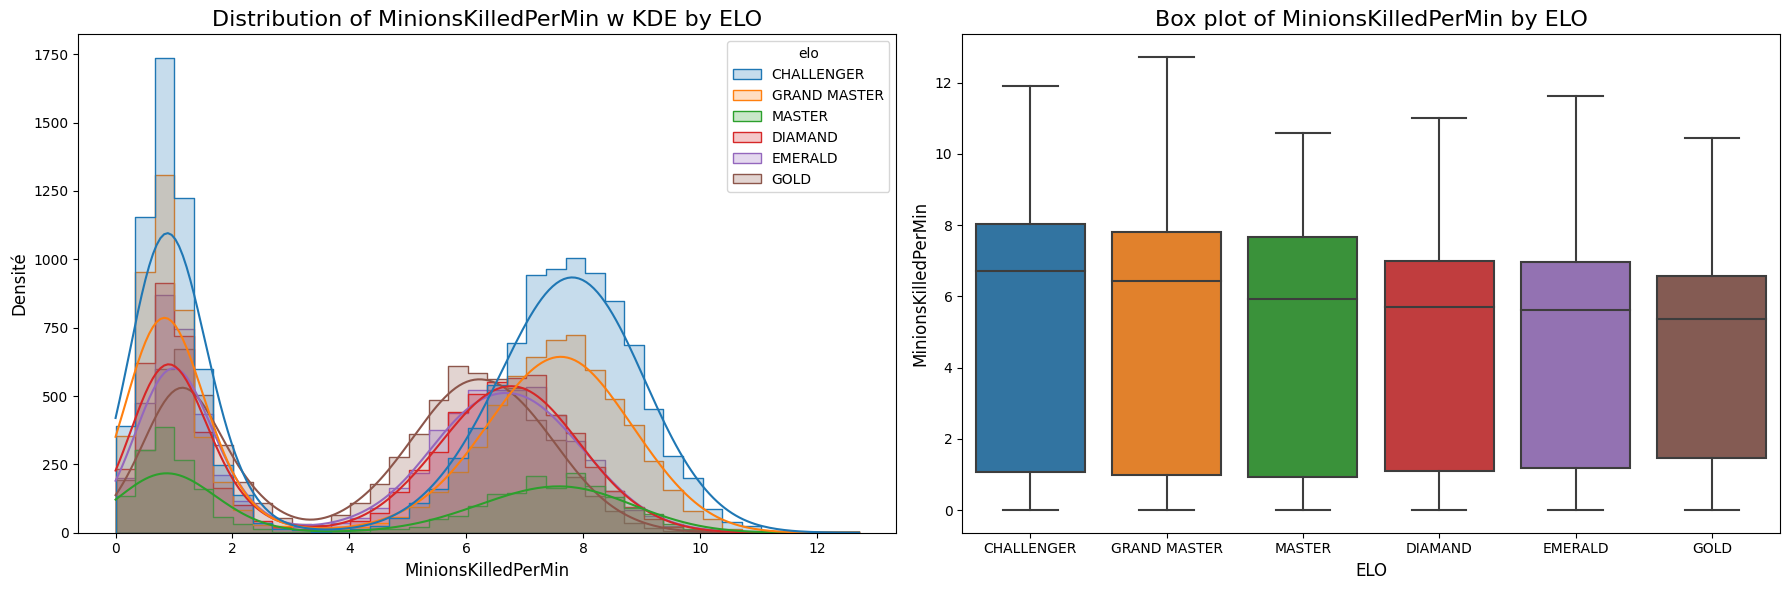

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='MinionsKilledPerMin', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of MinionsKilledPerMin w KDE by ELO', fontsize=16)
ax1.set_xlabel('MinionsKilledPerMin', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='MinionsKilledPerMin', ax=ax2)
ax2.set_title('Box plot of MinionsKilledPerMin by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('MinionsKilledPerMin', fontsize=12)

plt.tight_layout()
plt.show()

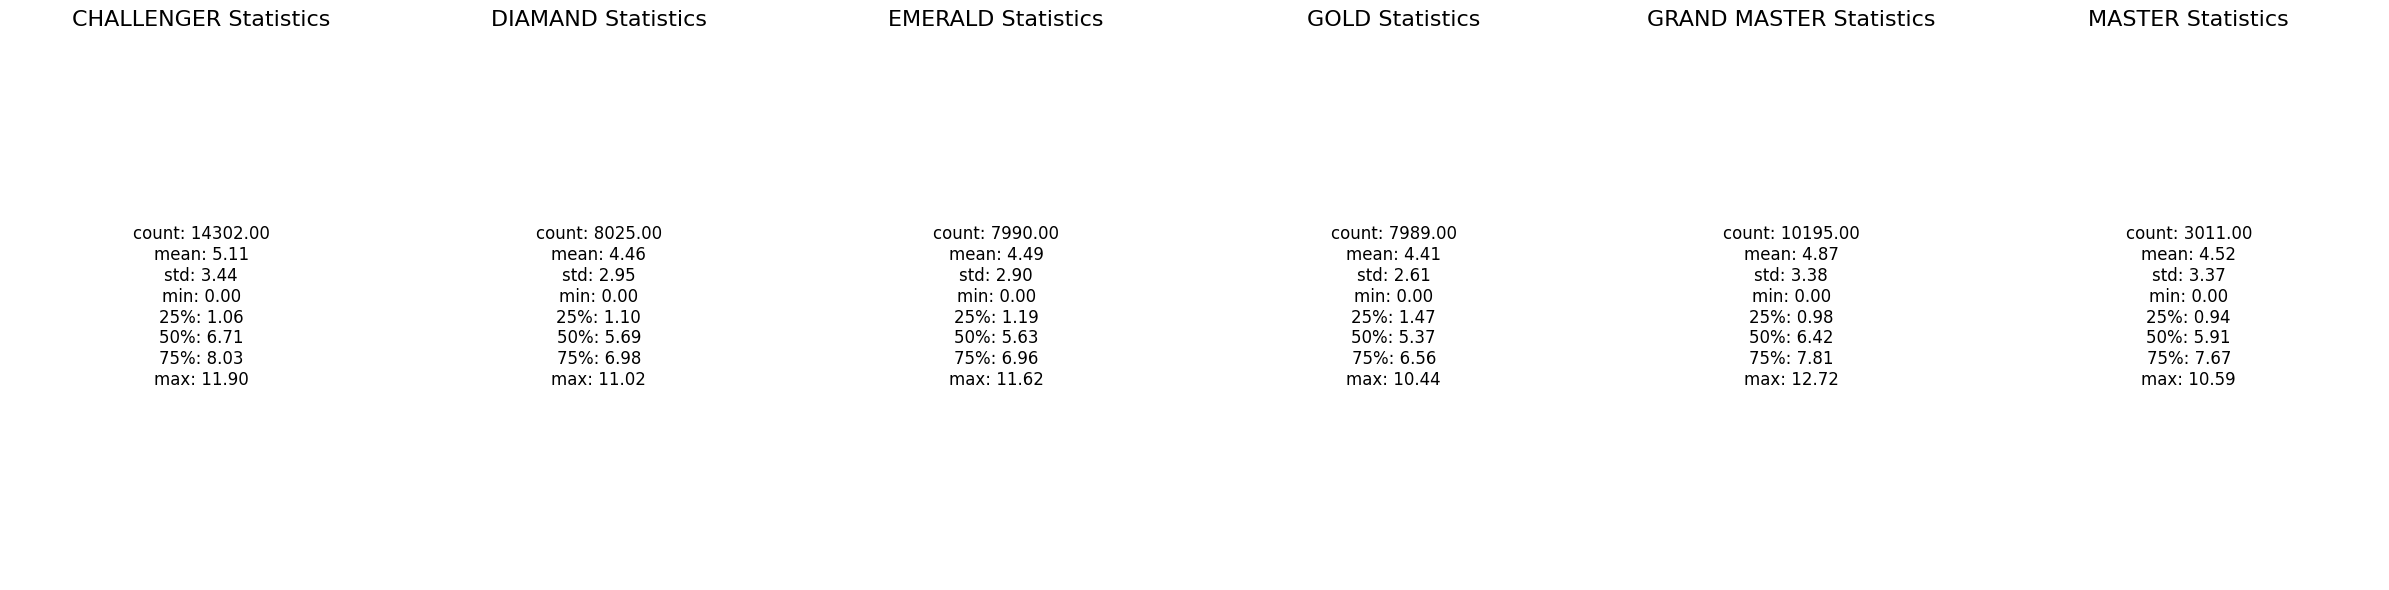

In [38]:
stats_data = df.groupby('elo')['MinionsKilledPerMin'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

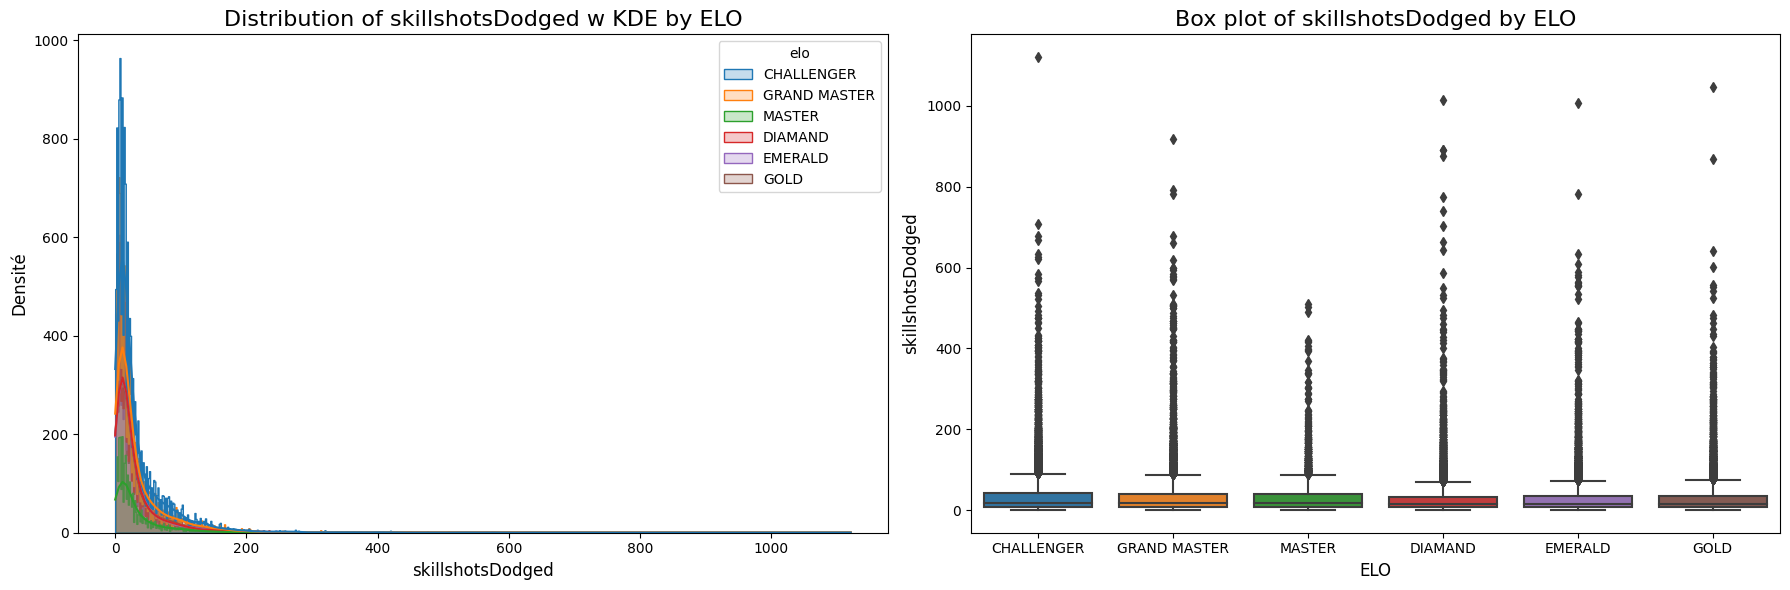

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='skillshotsDodged', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of skillshotsDodged w KDE by ELO', fontsize=16)
ax1.set_xlabel('skillshotsDodged', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='skillshotsDodged', ax=ax2)
ax2.set_title('Box plot of skillshotsDodged by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('skillshotsDodged', fontsize=12)

plt.tight_layout()
plt.show()

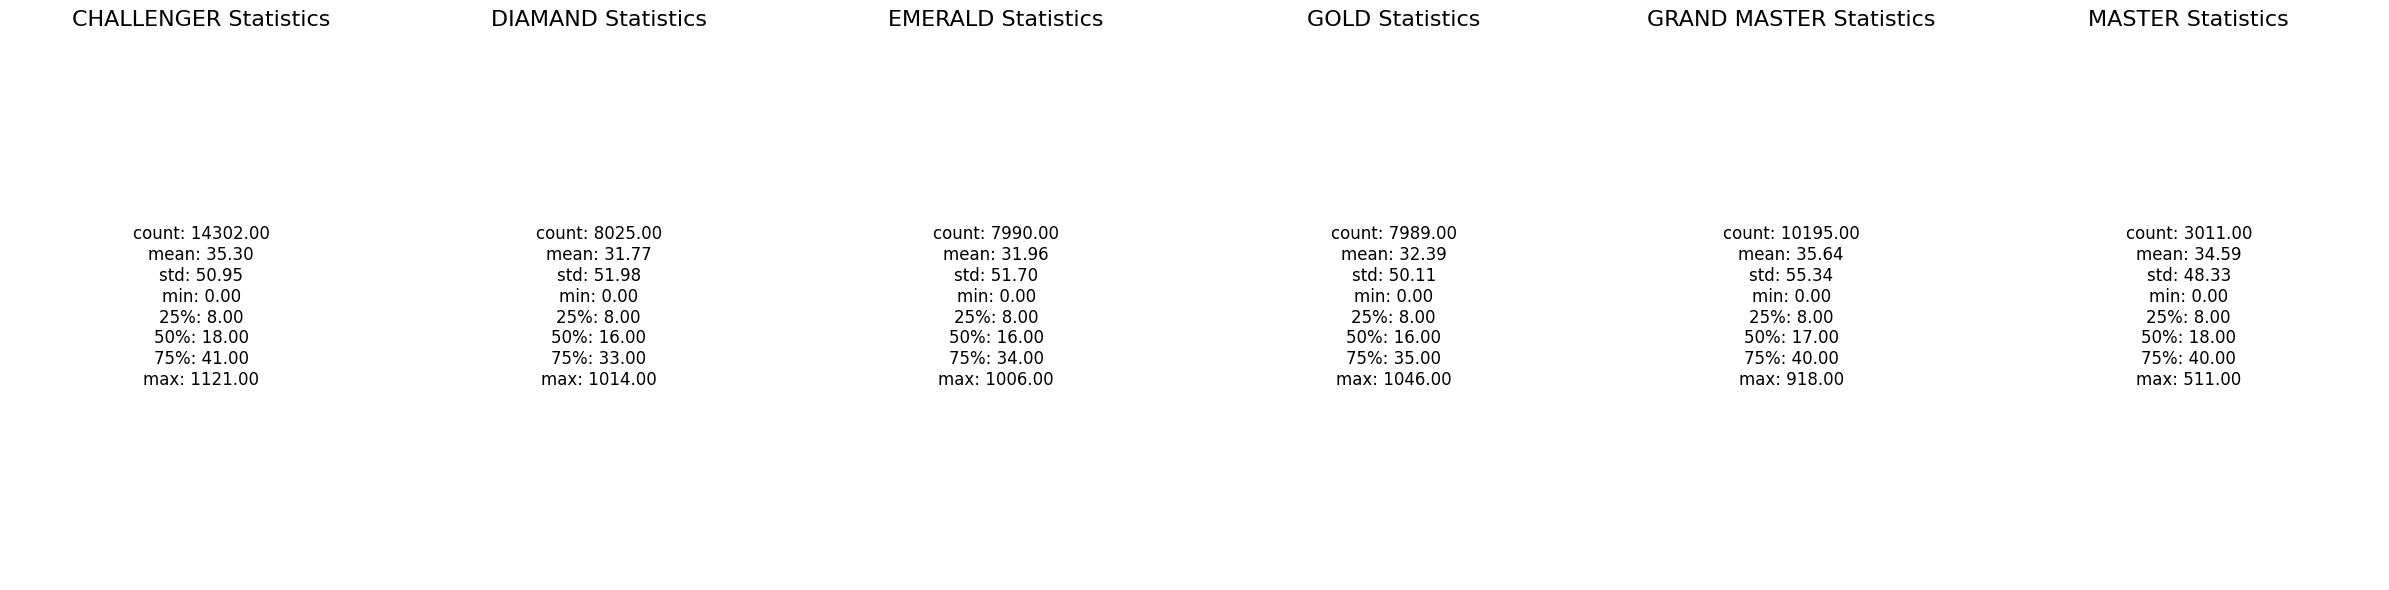

In [40]:
stats_data = df.groupby('elo')['skillshotsDodged'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

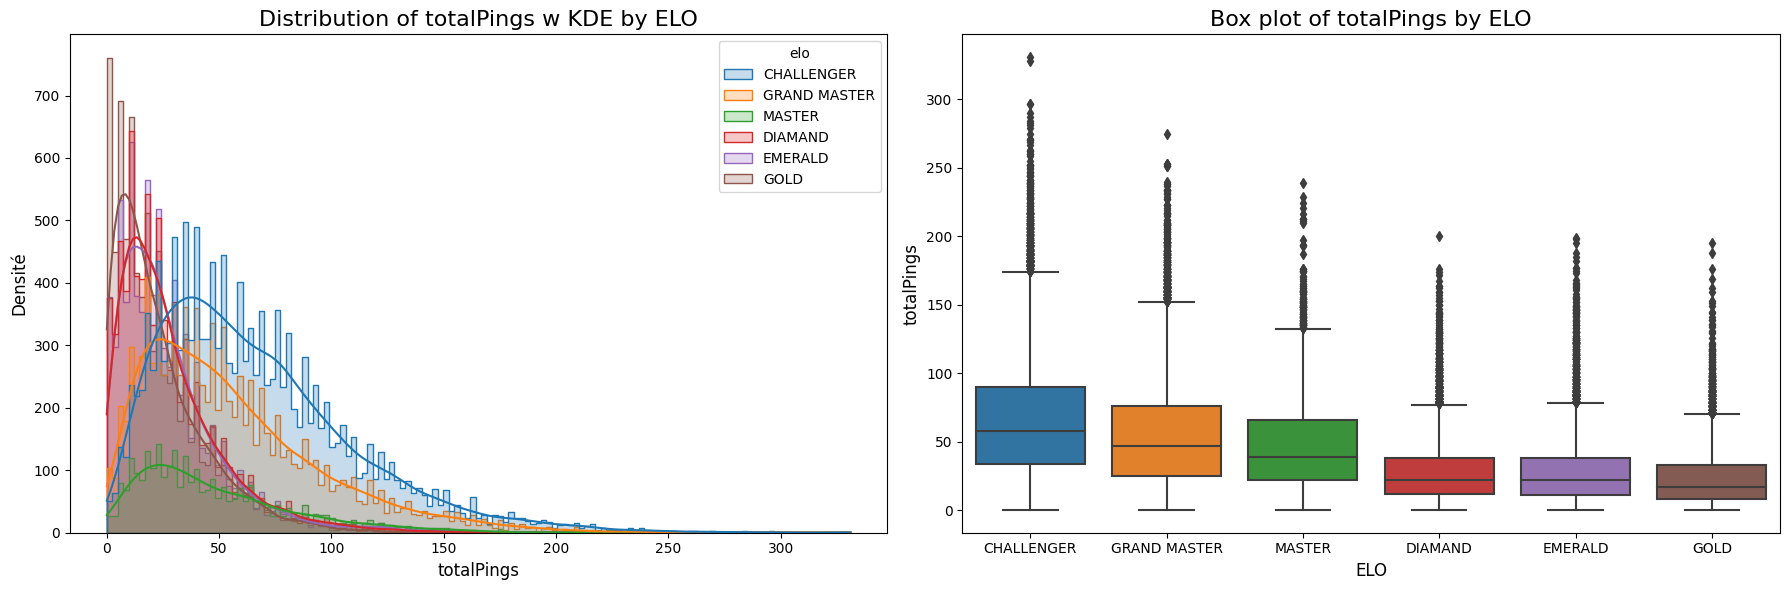

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='totalPings', hue='elo', element="step", kde=True, ax=ax1)
ax1.set_title('Distribution of totalPings w KDE by ELO', fontsize=16)
ax1.set_xlabel('totalPings', fontsize=12)
ax1.set_ylabel('Densité', fontsize=12)

sns.boxplot(data=df, x='elo', y='totalPings', ax=ax2)
ax2.set_title('Box plot of totalPings by ELO', fontsize=16)
ax2.set_xlabel('ELO', fontsize=12)
ax2.set_ylabel('totalPings', fontsize=12)

plt.tight_layout()
plt.show()

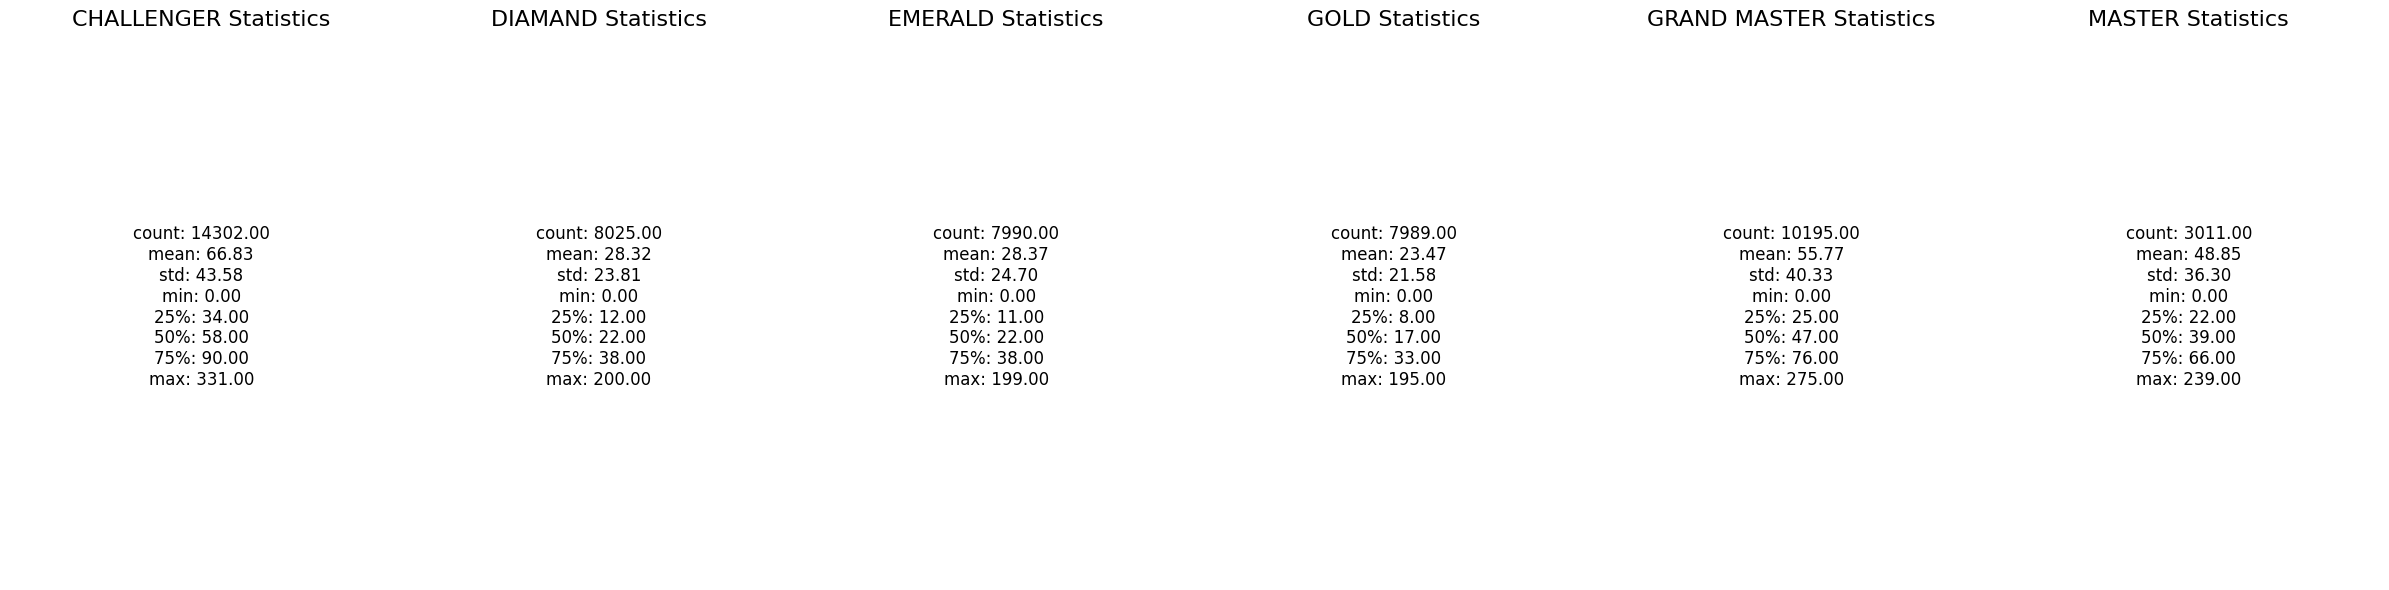

In [42]:
stats_data = df.groupby('elo')['totalPings'].describe()
fig, axes = plt.subplots(1, len(stats_data), figsize=(4 * len(stats_data), 6))  
if not isinstance(axes, np.ndarray):
    axes = [axes]  

for ax, (elo, stats) in zip(axes, stats_data.iterrows()):
    ax.axis('off') 
    ax.axis('tight')
    stats_text = '\n'.join([f'{idx}: {val:.2f}' for idx, val in stats.items()])
    ax.text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{elo} Statistics', fontsize=16)

plt.tight_layout()
plt.show()

In [43]:
n_col = df.columns.tolist()
print(n_col)
df.shape

['Match_ID', 'GameVersion', 'puuid', 'Team', 'GameTime', 'result', 'individualPosition', 'championName', 'kda', 'kills', 'deaths', 'assists', 'SoloKills', 'quickSoloKills', 'killsUnderOwnTurret', 'killsNearEnemyTurret', 'firstBloodAssist', 'firstBloodKill', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills', 'killingSprees', 'turretKills', 'quickFirstTurret', 'firstTowerAssist', 'firstTowerKill', 'turretPlatesTaken', 'kTurretsDestroyedBeforePlatesFall', 'champLevel', 'visionScore', 'visionScoreAdvantageLaneOpponent', 'visionScorePerMinute', 'totalMinionsKilled', 'laneMinionsFirst10Minutes', 'neutralMinionsKilled', 'skillshotsDodged', 'skillshotsHit', 'dodgeSkillShotsSmallWindow', 'goldPerMinute', 'goldEarned', 'goldSpent', 'laningPhaseGoldExpAdvantage', 'damagePerMinute', 'magicDamageDealt', 'magicDamageDealtToChampions', 'magicDamageTaken', 'physicalDamageDealt', 'physicalDamageDealtToChampions', 'physicalDamageTaken', 'trueDamageDealt', 'trueDamageDealtToChampions', 'trueDamag

(51512, 80)

# Part 3 - Analysis of the most influential role for victory

## Chi2

In [44]:
df.shape

(51512, 80)

In [45]:
rank = [
    'CHALLENGER',
    'GRAND MASTER',
    'MASTER',
    'DIAMAND',
    'EMERALD',
    'GOLD',
]

def analyze_chi2_by_elo(df, elo):
    df_filtered = df[df['elo'] == elo]
    contingency_table = pd.crosstab(df_filtered['individualPosition'], df_filtered['result'])

    # chi2
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi2 Statistic for {elo}: {chi2}")
    print(f"P-value for {elo}: {p_value}")
    print(f"Degrees of Freedom for {elo}: {dof}")
    print(f"Table of Expected Frequencies for {elo}:\n{expected}")

for i in range(len(rank)):
    print(f"Result for the rank {rank[i]} ")
    analyze_chi2_by_elo(df,rank[i])
    print("------------------------------------------------")

Result for the rank CHALLENGER 
Chi2 Statistic for CHALLENGER: 3.7001196846670044
P-value for CHALLENGER: 0.4481085167711012
Degrees of Freedom for CHALLENGER: 4
Table of Expected Frequencies for CHALLENGER:
[[1516.26891344 1929.73108656]
 [1396.14662285 1776.85337715]
 [1230.26345966 1565.73654034]
 [1112.78121941 1416.21878059]
 [1037.53978465 1320.46021535]]
------------------------------------------------
Result for the rank GRAND MASTER 
Chi2 Statistic for GRAND MASTER: 0.6391619436404908
P-value for GRAND MASTER: 0.9586140541830617
Degrees of Freedom for GRAND MASTER: 4
Table of Expected Frequencies for GRAND MASTER:
[[1086.80922021 1328.19077979]
 [1208.76586562 1477.23413438]
 [ 931.55076018 1138.44923982]
 [ 732.18989701  894.81010299]
 [ 628.68425699  768.31574301]]
------------------------------------------------
Result for the rank MASTER 
Chi2 Statistic for MASTER: 10.073355999638029
P-value for MASTER: 0.03920997347327332
Degrees of Freedom for MASTER: 4
Table of Expected

Chi2 Statistic for EMERALD: 4.445231021242602
P-value for EMERALD: 0.3490911519884426
Degrees of Freedom for EMERALD: 4
Table of Expected Frequencies for EMERALD:
[[803.95794743 852.04205257]
 [657.34242804 696.65757196]
 [780.16933667 826.83066333]
 [810.26921151 858.73078849]
 [827.26107635 876.73892365]]
------------------------------------------------
Result for the rank GOLD 
Chi2 Statistic for GOLD: 1.4749484265627235
P-value for GOLD: 0.8310695808103276
Degrees of Freedom for GOLD: 4
Table of Expected Frequencies for GOLD:
[[875.29315309 877.70684691]
 [504.80398047 506.19601953]
 [842.33859056 844.66140944]
 [839.34272124 841.65727876]
 [927.22155464 929.77844536]]
------------------------------------------------


Most ranks show a lack of a statistically significant connection between player role and match outcomes, with the exception of Master rank players. 
This could indicate that for some rank, the role may influence the results. 
However, as the rank master where I have the least data (3000 against more than 8000 for the others), this can certainly influence the results of the test

In [46]:
pos = [
    'TOP',
    'JUNGLE',
    'MIDDLE',
    'BOTTOM',
    'UTILITY'
]

def analyze_chi2_by_elo(df, pos):
    df_filtered = df[df['individualPosition'] == pos]
    contingency_table = pd.crosstab(df_filtered['elo'], df_filtered['result'])

    # chi2
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi2 Statistic for {pos}: {chi2}")
    print(f"P-value for {pos}: {p_value}")
    print(f"Degrees of Freedom for {pos}: {dof}")
    print(f"Table of Expected Frequencies for {pos}:\n{expected}")

for i in range(len(pos)):
    print(f"Result for the rank {pos[i]} ")
    analyze_chi2_by_elo(df,pos[i])
    print("------------------------------------------------")

Result for the rank TOP 
Chi2 Statistic for TOP: 19.37715780954642
P-value for TOP: 0.0016346773650570685
Degrees of Freedom for TOP: 5
Table of Expected Frequencies for TOP:
[[1189.5175474  1339.4824526 ]
 [ 962.80839048 1084.19160952]
 [ 785.01573215  883.98426785]
 [ 790.65994353  890.34005647]
 [ 765.26099234  861.73900766]
 [ 170.73739411  192.26260589]]
------------------------------------------------
Result for the rank JUNGLE 


Chi2 Statistic for JUNGLE: 36.13239060837294
P-value for JUNGLE: 8.936171565075386e-07
Degrees of Freedom for JUNGLE: 5
Table of Expected Frequencies for JUNGLE:
[[1468.58844296 1704.41155704]
 [ 815.52248235  946.47751765]
 [ 626.68413229  727.31586771]
 [ 467.9303233   543.0696767 ]
 [1243.18580453 1442.81419547]
 [ 360.08881457  417.91118543]]
------------------------------------------------
Result for the rank MIDDLE 
Chi2 Statistic for MIDDLE: 20.98348125646684
P-value for MIDDLE: 0.0008159013394256408
Degrees of Freedom for MIDDLE: 5
Table of Expected Frequencies for MIDDLE:
[[1306.92904849 1489.07095151]
 [ 668.8896525   762.1103475 ]
 [ 751.15700319  855.84299681]
 [ 788.55125351  898.44874649]
 [ 967.57622689 1102.42377311]
 [ 345.89681541  394.10318459]]
------------------------------------------------
Result for the rank BOTTOM 
Chi2 Statistic for BOTTOM: 31.50162382964039
P-value for BOTTOM: 7.4558371543141685e-06
Degrees of Freedom for BOTTOM: 5
Table of Expected Frequenci

In [47]:
df_chall = df[df['elo'] == "CHALLENGER"]
df_chall = df_chall[['Team', 'GameTime', 'result', 'individualPosition',	'kda',	'kills',	'deaths',	'assists',	'SoloKills',	'quickSoloKills',	'killsUnderOwnTurret',	'killsNearEnemyTurret',	'firstBloodAssist',	'firstBloodKill',	'doubleKills',	'tripleKills',	'quadraKills',	'pentaKills',	'killingSprees',	'turretKills',	'quickFirstTurret',	'firstTowerAssist',	'firstTowerKill',	'turretPlatesTaken',	'kTurretsDestroyedBeforePlatesFall',	'champLevel',	'visionScore',	'visionScoreAdvantageLaneOpponent',	'visionScorePerMinute',	'totalMinionsKilled',	'laneMinionsFirst10Minutes',	'neutralMinionsKilled',	'skillshotsDodged',	'skillshotsHit',	'dodgeSkillShotsSmallWindow',	'goldPerMinute',	'goldEarned',	'goldSpent',	'laningPhaseGoldExpAdvantage',	'damagePerMinute',	'magicDamageDealt',	'magicDamageDealtToChampions',	'magicDamageTaken',	'physicalDamageDealt',	'physicalDamageDealtToChampions',	'physicalDamageTaken',	'trueDamageDealt',	'trueDamageDealtToChampions',	'trueDamageTaken',	'totalDamageDealt',	'totalDamageDealtToChampions',	'totalDamageTaken',	'damageDealtToBuildings',	'damageDealtToObjectives',	'damageDealtToTurrets',	'totalTimeSpentDead',	'totalHeal',	'totalHealsOnTeammates',	'saveAllyFromDeath',	'totalPings',	'MinionsKilledPerMin']]

df_chall['Team'] = df_chall['Team'].apply(lambda x: 1 if x == 'Blue' else 0)
df_chall['firstTowerAssist'] = df_chall['firstTowerAssist'].apply(lambda x: 1 if x == 'True' else 0)
df_chall['firstTowerKill'] = df_chall['firstTowerKill'].apply(lambda x: 1 if x == 'True' else 0)
df_chall.shape

(14302, 61)

In [48]:
nan_counts = df_chall.isna().sum()
print(nan_counts)

Team                     0
GameTime                 0
result                   0
individualPosition       0
kda                      0
                        ..
totalHeal                0
totalHealsOnTeammates    0
saveAllyFromDeath        0
totalPings               0
MinionsKilledPerMin      0
Length: 61, dtype: int64


## Kernel PCA

In [49]:
df_chall = df_chall.dropna()

In [50]:
X = df_chall.drop(['result','individualPosition'], axis=1)
y = df_chall['result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled2 = np.hstack((X_scaled, df_chall['individualPosition'].values.reshape(-1, 1)))

X_train, X_test, y_train, y_test = train_test_split(X_scaled2, y, test_size=0.2, random_state=42)

X_train2 = X_train[:, :-1].copy()
X_test2 = X_test[:, :-1].copy()

In [51]:
accuracies = []
components_range = [2,5,10,15,20,25,30,40,50,55]  
for n_components in components_range:
    kpca = KernelPCA(kernel='rbf', gamma=1/X_train2.shape[1], n_components=n_components)
    X_kpca_train = kpca.fit_transform(X_train2)
    X_kpca_test = kpca.transform(X_test2)

    classifier = LogisticRegression()
    classifier.fit(X_kpca_train, y_train)
    y_pred = classifier.predict(X_kpca_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

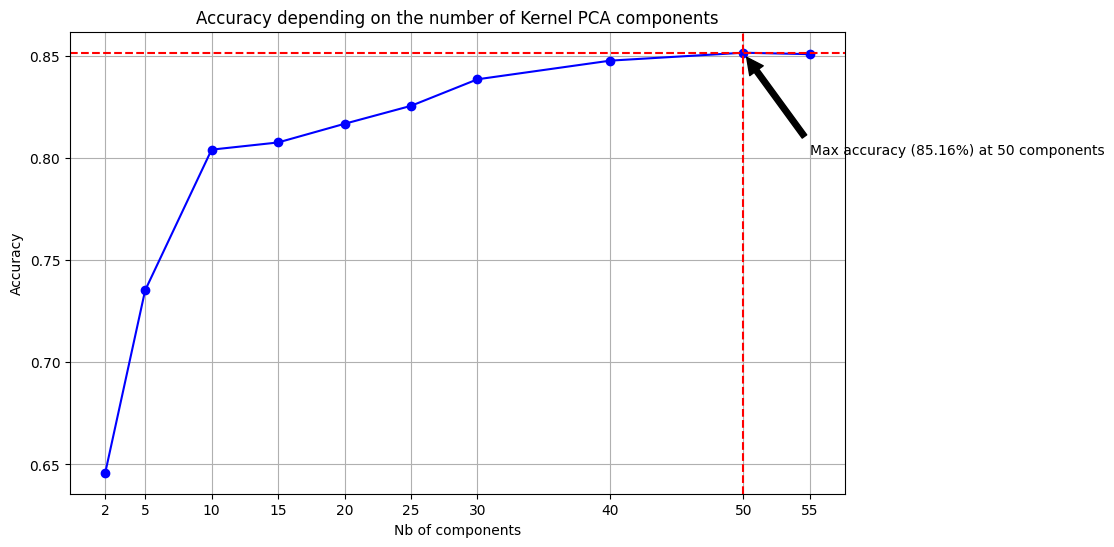

The best number of components is 50 with an accuracy of 0.8516.


In [52]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy depending on the number of Kernel PCA components')
plt.xlabel('Nb of components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(components_range) 

max_accuracy = max(accuracies)
max_index = accuracies.index(max_accuracy)
best_components = components_range[max_index]
plt.axhline(y=max_accuracy, color='r', linestyle='--')
plt.axvline(x=best_components, color='r', linestyle='--')

plt.annotate(f'Max accuracy ({max_accuracy*100:.2f}%) at {best_components} components',
             xy=(best_components, max_accuracy),
             xytext=(best_components+5, max_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f"The best number of components is {best_components} with an accuracy of {max_accuracy:.4f}.")

In [53]:
kpca = KernelPCA(kernel='rbf', gamma=1/X_train.shape[1], n_components=10)
X_kpca_train = kpca.fit_transform(X_train2)
X_kpca_test = kpca.transform(X_test2)

In [54]:
encoder = LabelEncoder()
individual_position_train_encoded = encoder.fit_transform(X_train[:, -1])
individual_position_test_encoded = encoder.transform(X_test[:, -1])

X_kpca_train_final = np.column_stack((X_kpca_train, individual_position_train_encoded))
X_kpca_test_final = np.column_stack((X_kpca_test, individual_position_test_encoded))

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_kpca_train_final, y_train)
y_pred = rfc.predict(X_kpca_test_final)

print('Accuracy RFC :', accuracy_score(y_test, y_pred))
print('Classification Report RFC :', classification_report(y_test, y_pred))
scores = cross_val_score(rfc, X_kpca_train_final, y_train, cv=5)
print("Average accuracy in RFC cross-validation :", scores.mean())

Accuracy RFC : 0.8185654008438819
Classification Report RFC :               precision    recall  f1-score   support

        Lose       0.79      0.79      0.79      1241
         Win       0.84      0.84      0.84      1603

    accuracy                           0.82      2844
   macro avg       0.82      0.82      0.82      2844
weighted avg       0.82      0.82      0.82      2844

Average accuracy in RFC cross-validation : 0.8214663859865968


In [55]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbm.fit(X_kpca_train_final, y_train)
y_pred_gbm = gbm.predict(X_kpca_test_final)

print('Accuracy GBM :', accuracy_score(y_test, y_pred_gbm))
print('Classification Report GBM :', classification_report(y_test, y_pred_gbm))

scores = cross_val_score(gbm, X_kpca_train_final, y_train, cv=5)
print("Average accuracy in GBM cross-validation : ", scores.mean())

Accuracy GBM : 0.8118846694796061
Classification Report GBM :               precision    recall  f1-score   support

        Lose       0.80      0.76      0.78      1241
         Win       0.82      0.85      0.84      1603

    accuracy                           0.81      2844
   macro avg       0.81      0.81      0.81      2844
weighted avg       0.81      0.81      0.81      2844

Average accuracy in GBM cross-validation :  0.8183898877923482


The RandomForestClassifier shows better overall performance and slightly better robustness according to cross-validation.

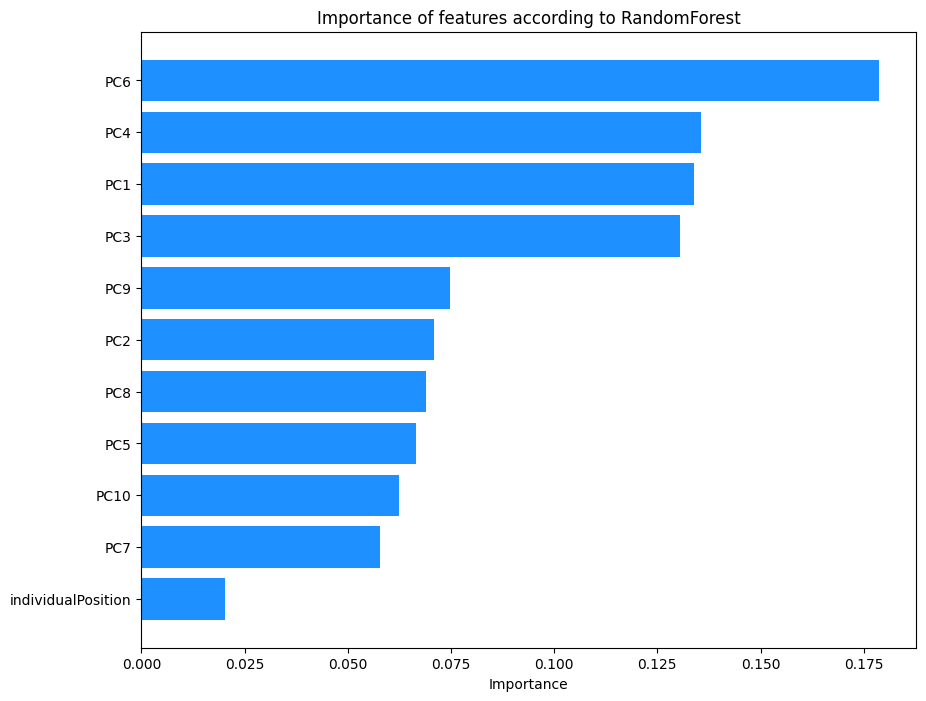

In [56]:
feature_importances = rfc.feature_importances_
features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'individualPosition']

importance_df = pd.DataFrame(data={'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.title('Importance of features according to RandomForest')
plt.gca().invert_yaxis()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Accuracy: 0.8076652601969058
Classification Report:               precision    recall  f1-score   support

        Lose       0.79      0.77      0.78      1241
         Win       0.82      0.84      0.83      1603

    accuracy                           0.81      2844
   macro avg       0.80      0.80      0.80      2844
weighted avg       0.81      0.81      0.81      2844



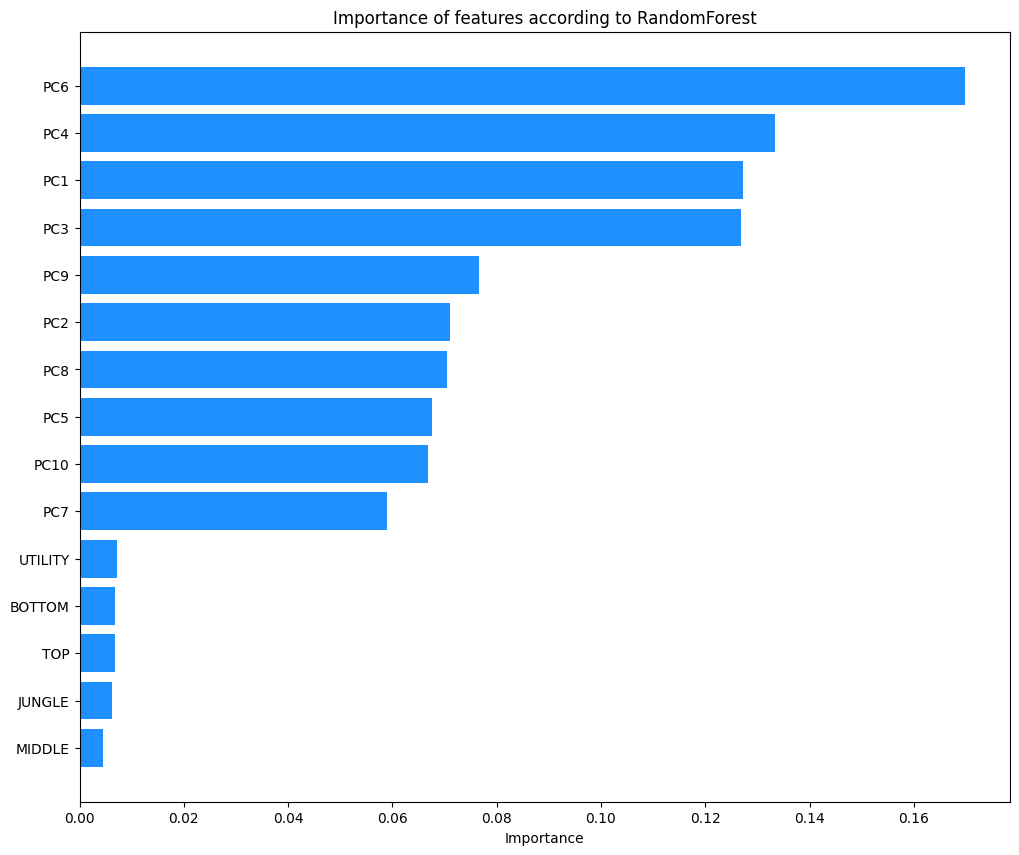

In [57]:
encoder = OneHotEncoder(sparse=False)
individual_position_train_encoded = encoder.fit_transform(X_train[:, -1].reshape(-1, 1))
individual_position_test_encoded = encoder.transform(X_test[:, -1].reshape(-1, 1))

a = np.hstack((X_kpca_train, individual_position_train_encoded))
b = np.hstack((X_kpca_test, individual_position_test_encoded))

role_names = encoder.categories_[0]
feature_names = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'] + list(role_names)  
rfc2 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc2.fit(a, y_train)
y_pred = rfc2.predict(b)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))

feature_importances = rfc2.feature_importances_
importance_df = pd.DataFrame(data={'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.title('Importance of features according to RandomForest')
plt.gca().invert_yaxis()
plt.show()

According to Random Forest, the most important role for victory would be the support role. Even if position is not the most important feature

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled2, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
individual_position_train_encoded = encoder.fit_transform(X_train[:, -1])
individual_position_test_encoded = encoder.transform(X_test[:, -1])

a = np.column_stack((X_train2, individual_position_train_encoded))
b = np.column_stack((X_test2, individual_position_test_encoded))

rfc2 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc2.fit(a, y_train)
y_pred = rfc2.predict(b)

print('Accuracy RFC :', accuracy_score(y_test, y_pred))
print('Classification Report RFC :', classification_report(y_test, y_pred))
scores = cross_val_score(rfc2, X_kpca_train_final, y_train, cv=5)
print("Average accuracy in RFC cross-validation : ", scores.mean())

Accuracy RFC : 0.8568917018284107
Classification Report RFC :               precision    recall  f1-score   support

        Lose       0.84      0.83      0.83      1241
         Win       0.87      0.88      0.87      1603

    accuracy                           0.86      2844
   macro avg       0.86      0.85      0.85      2844
weighted avg       0.86      0.86      0.86      2844

Average accuracy in RFC cross-validation :  0.8214663859865968


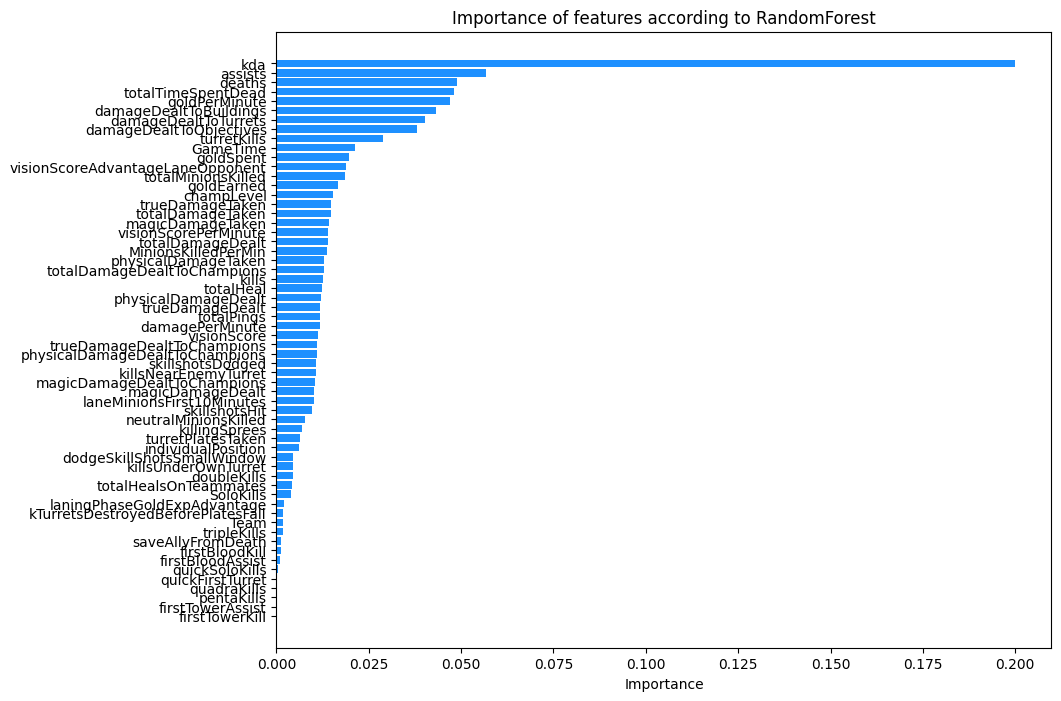

In [59]:
feature_importances = rfc2.feature_importances_
features = ['Team',	'GameTime',	'kda',	'kills',	'deaths',	'assists',	'SoloKills',	'quickSoloKills',	'killsUnderOwnTurret',	'killsNearEnemyTurret',	'firstBloodAssist',	'firstBloodKill',	'doubleKills',	'tripleKills',	'quadraKills',	'pentaKills',	'killingSprees',	'turretKills',	'quickFirstTurret',	'firstTowerAssist',	'firstTowerKill',	'turretPlatesTaken',	'kTurretsDestroyedBeforePlatesFall',	'champLevel',	'visionScore',	'visionScoreAdvantageLaneOpponent',	'visionScorePerMinute',	'totalMinionsKilled',	'laneMinionsFirst10Minutes',	'neutralMinionsKilled',	'skillshotsDodged',	'skillshotsHit',	'dodgeSkillShotsSmallWindow',	'goldPerMinute',	'goldEarned',	'goldSpent',	'laningPhaseGoldExpAdvantage',	'damagePerMinute',	'magicDamageDealt',	'magicDamageDealtToChampions',	'magicDamageTaken',	'physicalDamageDealt',	'physicalDamageDealtToChampions',	'physicalDamageTaken',	'trueDamageDealt',	'trueDamageDealtToChampions',	'trueDamageTaken',	'totalDamageDealt',	'totalDamageDealtToChampions',	'totalDamageTaken',	'damageDealtToBuildings',	'damageDealtToObjectives',	'damageDealtToTurrets',	'totalTimeSpentDead',	'totalHeal',	'totalHealsOnTeammates',	'saveAllyFromDeath',	'totalPings',	'MinionsKilledPerMin','individualPosition']
importance_df = pd.DataFrame(data={'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.title('Importance of features according to RandomForest')
plt.gca().invert_yaxis()

# Part 4 - Focus on the support role, does the loser queue exist?

## Getting the new Dataset

In [60]:
df_kr = pd.read_csv('/Applications/Dossier/cours/Master MIASHS/M2/TER/Directory/Data/DataSet/match_data_kr.csv')
df_kr['totalPings'] = df_kr[['allInPings', 'assistMePings', 'basicPings', 'commandPings', 'dangerPings', 
                       'enemyMissingPings', 'enemyVisionPings', 'getBackPings', 'holdPings', 
                       'needVisionPings', 'onMyWayPings', 'pushPings', 'visionClearedPings']].sum(axis=1)
df_kr['MinionsKilledPerMin'] = df_kr['totalMinionsKilled']/df_kr['GameTime']

name_mapping = {
    "GoRZqa4evZnvLUc9YYbFT_TKWwmgI6G4kQTl9rDuZ5QpsXS2l3gcJ5QK0CaZkiIPhF7mD__-t2X_BA": "Guwon",
    "7QHDyhFEE6_H_qJ2aEnh1Kd0Lzcx1PGqlfNPDmCCMnprrs4niuP2NpcemDXlA-6UoskY1BjDE2vU3w": "Mata"
}
df_kr['Name'] = df_kr['puuid'].map(name_mapping)

df_kr = df_kr[((df_kr['puuid'] == "GoRZqa4evZnvLUc9YYbFT_TKWwmgI6G4kQTl9rDuZ5QpsXS2l3gcJ5QK0CaZkiIPhF7mD__-t2X_BA") & (df_kr['individualPosition'] == "JUNGLE")) |
            ((df_kr['puuid'] == "7QHDyhFEE6_H_qJ2aEnh1Kd0Lzcx1PGqlfNPDmCCMnprrs4niuP2NpcemDXlA-6UoskY1BjDE2vU3w") & (df_kr['individualPosition'] == "UTILITY")) |
            ((df_kr['puuid'] != "GoRZqa4evZnvLUc9YYbFT_TKWwmgI6G4kQTl9rDuZ5QpsXS2l3gcJ5QK0CaZkiIPhF7mD__-t2X_BA") & (df_kr['puuid'] != "7QHDyhFEE6_H_qJ2aEnh1Kd0Lzcx1PGqlfNPDmCCMnprrs4niuP2NpcemDXlA-6UoskY1BjDE2vU3w"))]

df_kr = df_kr[['Name', 'Team', 'GameTime',	'result', 'individualPosition',	'kda',	'kills',	'deaths',	'assists',	'SoloKills',	'quickSoloKills',	'killsUnderOwnTurret',	'killsNearEnemyTurret',	'firstBloodAssist',	'firstBloodKill',	'doubleKills',	'tripleKills',	'quadraKills',	'pentaKills',	'killingSprees',	'turretKills',	'quickFirstTurret',	'firstTowerAssist',	'firstTowerKill',	'turretPlatesTaken',	'kTurretsDestroyedBeforePlatesFall',	'champLevel',	'visionScore',	'visionScoreAdvantageLaneOpponent',	'visionScorePerMinute',	'totalMinionsKilled',	'laneMinionsFirst10Minutes',	'neutralMinionsKilled',	'skillshotsDodged',	'skillshotsHit',	'dodgeSkillShotsSmallWindow',	'goldPerMinute',	'goldEarned',	'goldSpent',	'laningPhaseGoldExpAdvantage',	'damagePerMinute',	'magicDamageDealt',	'magicDamageDealtToChampions',	'magicDamageTaken',	'physicalDamageDealt',	'physicalDamageDealtToChampions',	'physicalDamageTaken',	'trueDamageDealt',	'trueDamageDealtToChampions',	'trueDamageTaken',	'totalDamageDealt',	'totalDamageDealtToChampions',	'totalDamageTaken',	'damageDealtToBuildings',	'damageDealtToObjectives',	'damageDealtToTurrets',	'totalTimeSpentDead',	'totalHeal',	'totalHealsOnTeammates',	'saveAllyFromDeath',	'totalPings',	'MinionsKilledPerMin']]

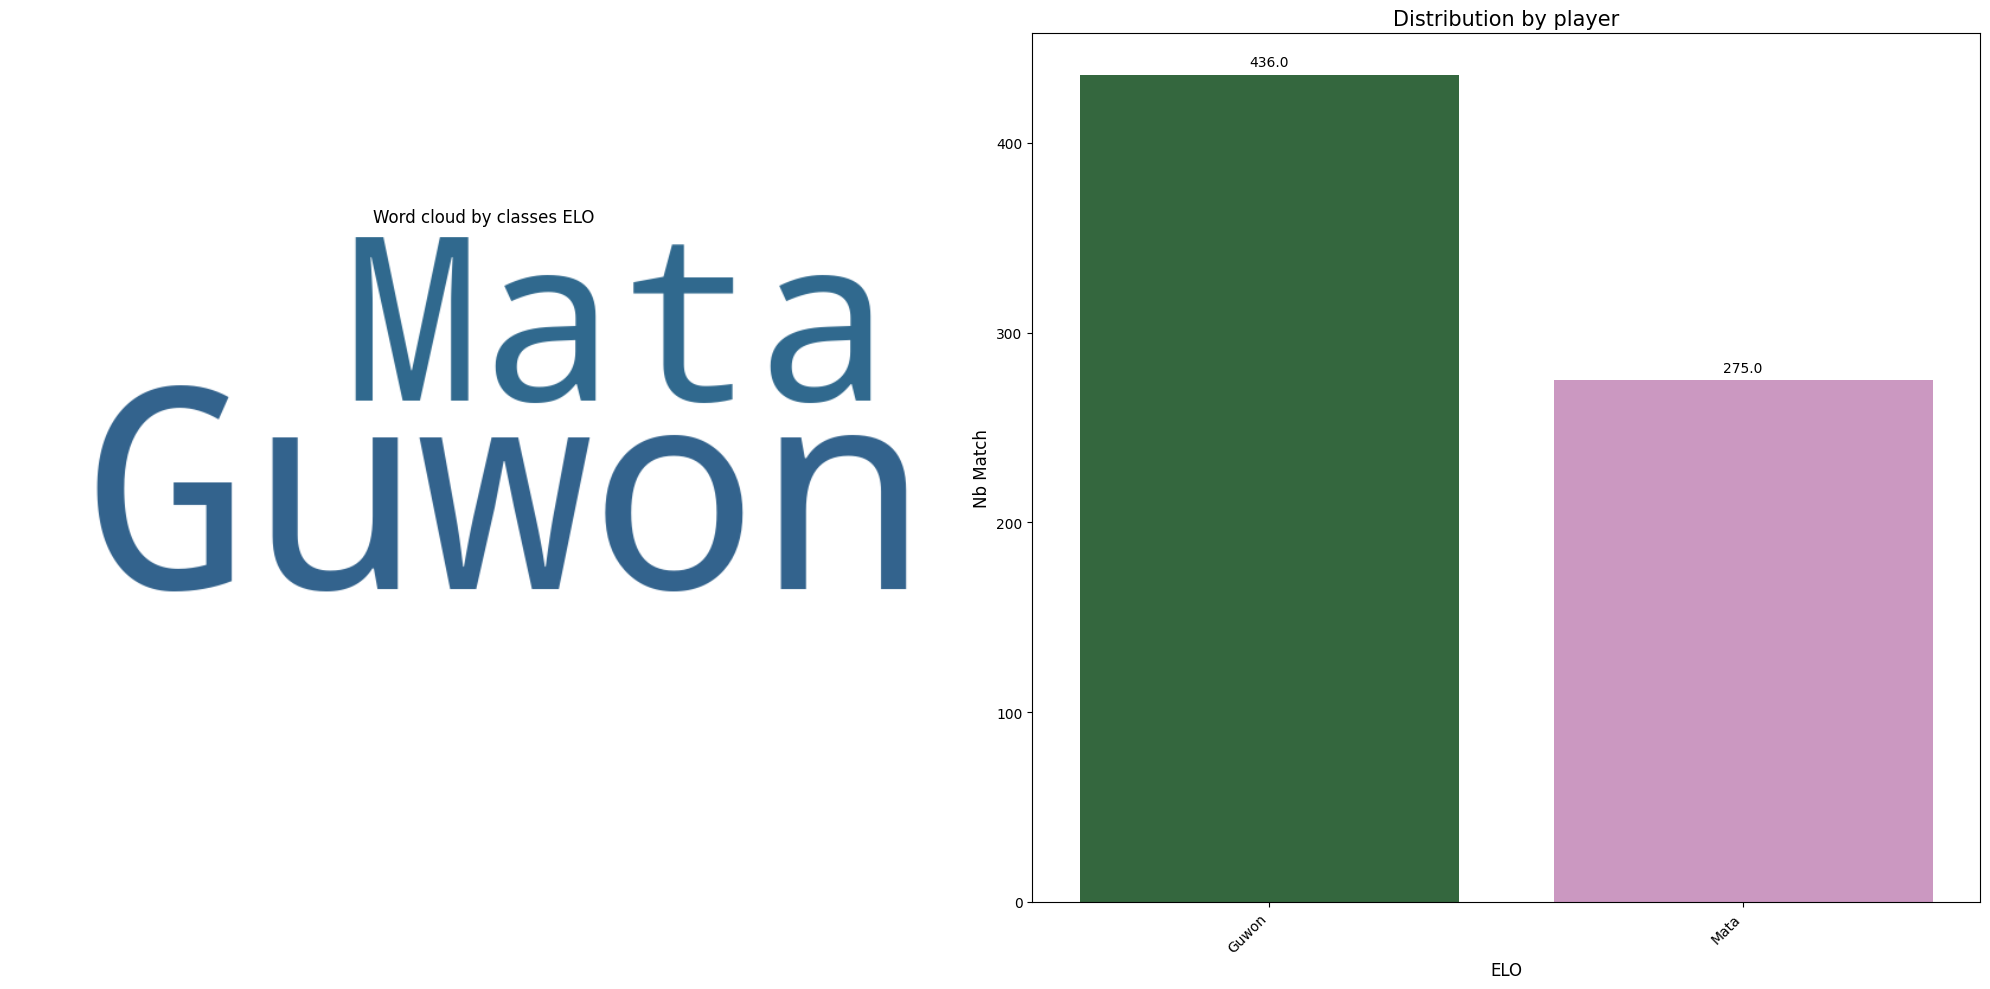

In [61]:
elo_freq = df_kr['Name'].dropna().value_counts().to_dict()
elocloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(elo_freq)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(elocloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud by classes ELO')


elo_counts = df_kr['Name'].value_counts()
plt.subplot(1, 2, 2) 
barplot = sns.barplot(x=elo_counts.index, y=elo_counts.values, palette="cubehelix")
plt.title('Distribution by player', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('Nb Match', fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()


In [62]:
df_kr['Team'] = df_kr['Team'].apply(lambda x: 1 if x == 'Blue' else 0)
df_kr['result'] = df_kr['result'].apply(lambda x: 1 if x == 'Win' else 0)
df_kr['firstTowerAssist'] = df_kr['firstTowerAssist'].apply(lambda x: 1 if x == 'True' else 0)
df_kr['firstTowerKill'] = df_kr['firstTowerKill'].apply(lambda x: 1 if x == 'True' else 0)


nan_counts = df_kr.isna().sum()
print(nan_counts[nan_counts>0])
df_kr = df_kr.dropna()

Mata = df_kr[df_kr['Name'] == "Mata"]
Guwon = df_kr[df_kr['Name'] == "Guwon"]

visionScoreAdvantageLaneOpponent    4
laningPhaseGoldExpAdvantage         9
dtype: int64


Focus on Mata, Guwon data will be processed in the appendix

## Mata - Shap Values

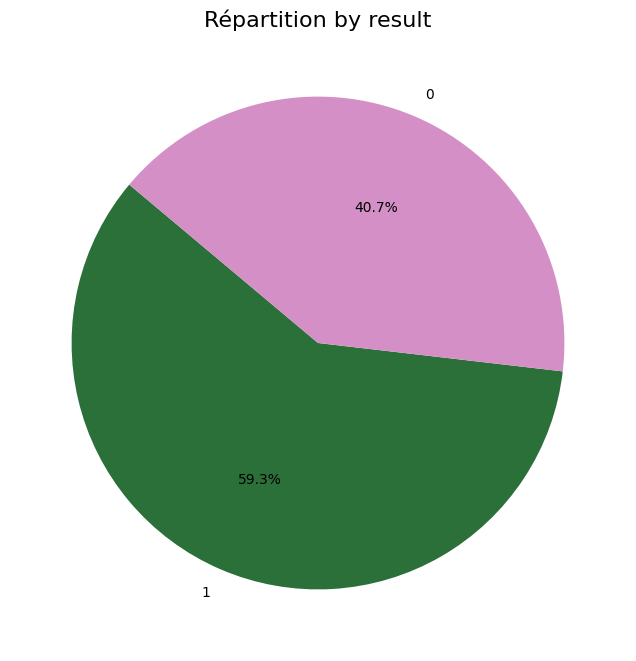

In [63]:
result_counts = Mata['result'].value_counts()
palette = sns.color_palette("cubehelix", len(result_counts))
plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Répartition by result', fontsize=16)
plt.show()

In [64]:
Mata = Mata.drop(['Name','individualPosition'], axis=1)
XMata = Mata.drop('result', axis=1) 
yMata = Mata['result']
X_trainMata, X_testMata, y_trainMata, y_testMata = train_test_split(XMata, yMata, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_trainMata, y_trainMata)
y_pred_rfcMata = rfc.predict(X_testMata)

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_trainMata, y_trainMata)
y_pred_gbcMata = gbc.predict(X_testMata)

XGB =  XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
XGB.fit(X_trainMata, y_trainMata)
y_pred_XGBMata = XGB.predict(X_testMata)

print('Accuracy RFC :', accuracy_score(y_testMata, y_pred_rfcMata))
print('Classification Report RFC :', classification_report(y_testMata, y_pred_rfcMata))
scores_rfcMata = cross_val_score(rfc, X_trainMata, y_trainMata, cv=5)
print("Average accuracy in RFC cross-validation : ", scores_rfcMata.mean())

print('Accuracy GBC :', accuracy_score(y_testMata, y_pred_gbcMata))
print('Classification Report GBC :', classification_report(y_testMata, y_pred_gbcMata))
scores_gbcMata = cross_val_score(gbc, X_trainMata, y_trainMata, cv=5)
print("Average accuracy in GBC cross-validation : ", scores_gbcMata.mean())

print('Accuracy XGB :', accuracy_score(y_testMata, y_pred_XGBMata))
print('Classification Report XGB :', classification_report(y_testMata, y_pred_XGBMata))
scores_XGBMata = cross_val_score(XGB, X_trainMata, y_trainMata, cv=5)
print("Average accuracy in XGB cross-validation : ", scores_XGBMata.mean())

best_modelMata = rfc if scores_rfcMata.mean() > scores_gbcMata.mean() and scores_rfcMata.mean() > scores_XGBMata.mean() else gbc if scores_gbcMata.mean() > scores_XGBMata.mean() else XGB
print(f'Best one is : {"RFC" if best_modelMata == rfc else "GBC" if best_modelMata == gbc else "XGB"}')

Accuracy RFC : 0.8727272727272727
Classification Report RFC :               precision    recall  f1-score   support

           0       0.81      0.96      0.88        26
           1       0.96      0.79      0.87        29

    accuracy                           0.87        55
   macro avg       0.88      0.88      0.87        55
weighted avg       0.89      0.87      0.87        55

Average accuracy in RFC cross-validation :  0.8045454545454547
Accuracy GBC : 0.8
Classification Report GBC :               precision    recall  f1-score   support

           0       0.74      0.88      0.81        26
           1       0.88      0.72      0.79        29

    accuracy                           0.80        55
   macro avg       0.81      0.80      0.80        55
weighted avg       0.81      0.80      0.80        55

Average accuracy in GBC cross-validation :  0.7818181818181819
Accuracy XGB : 0.8181818181818182
Classification Report XGB :               precision    recall  f1-score   sup

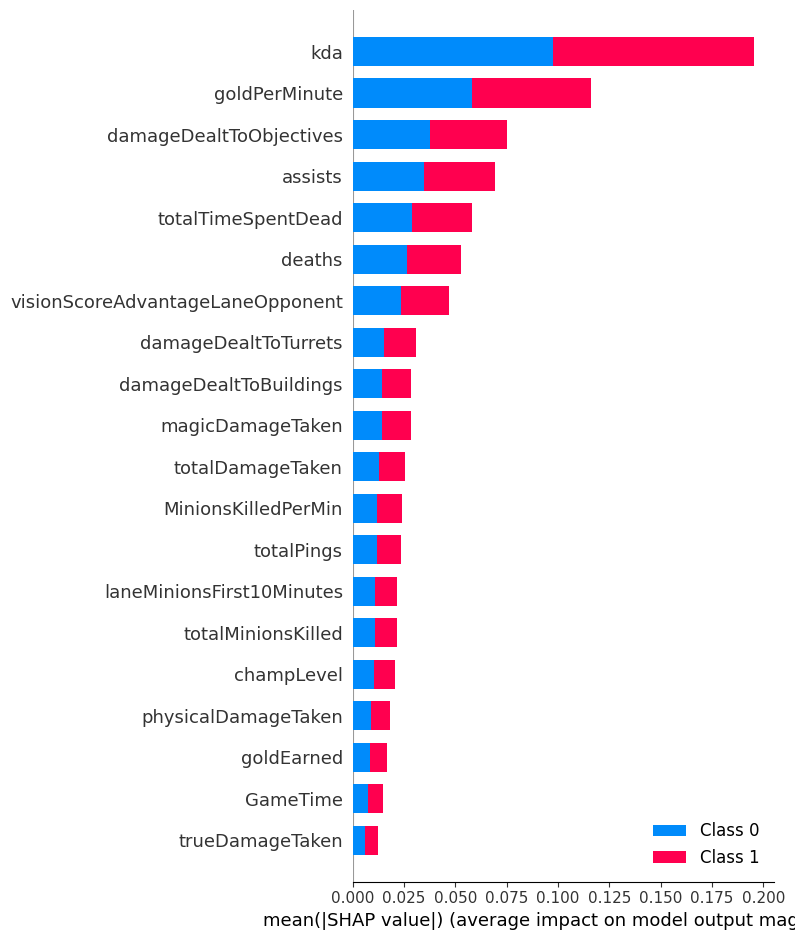

In [65]:
explainer = shap.TreeExplainer(best_modelMata)
shap_valuesMata = explainer.shap_values(X_testMata)

shap.summary_plot(shap_valuesMata, X_testMata, plot_type="bar")

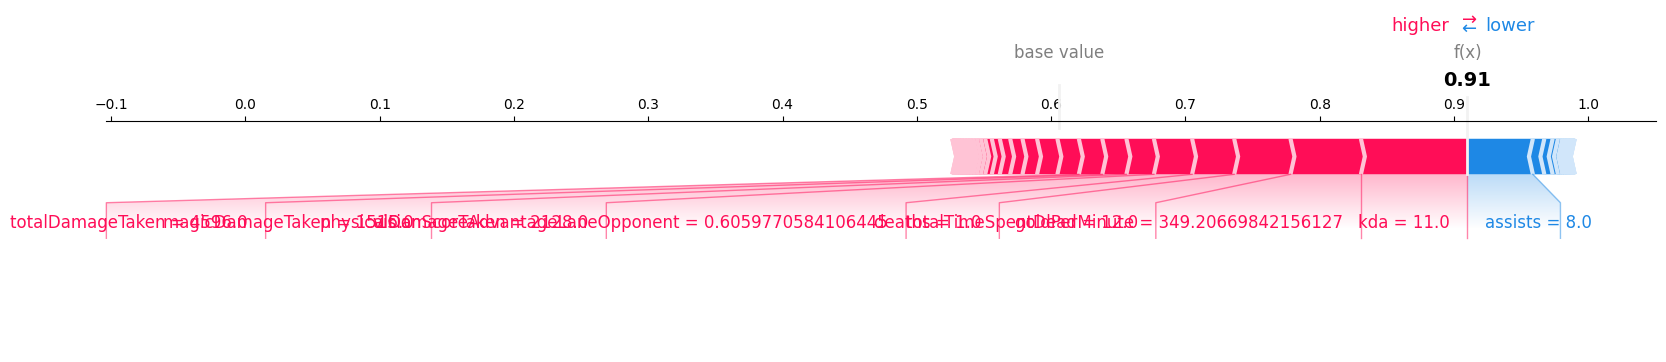

In [66]:
shap.force_plot(explainer.expected_value[1], shap_valuesMata[1][0], X_testMata.iloc[0], matplotlib=True)

In [67]:
features = ['kda','goldPerMinute','damageDealtToObjectives','damageDealtToTurrets','assists','visionScoreAdvantageLaneOpponent','visionScorePerMinute','totalDamageTaken','totalDamageDealt','totalPings','totalHealsOnTeammates']
XMata = Mata[features]
yMata = Mata['result']

## Mata - Creation of the probability of victory

In [68]:
X_trainMata, X_testMata, y_trainMata, y_testMata = train_test_split(XMata, yMata, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

ensemble_clf = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], voting='soft')

ensemble_clf.fit(X_trainMata, y_trainMata)

y_pred_probaMata = ensemble_clf.predict_proba(X_testMata)[:, 1]

X_testMata['WinProba'] = y_pred_probaMata

y_predMata = ensemble_clf.predict(X_testMata.drop('WinProba', axis=1))
accuracy = accuracy_score(y_testMata, y_predMata)
print(f"Accuracy: {accuracy:.2f}")

Mata.loc[:, 'WinProba'] = ensemble_clf.predict_proba(XMata)[:, 1]

Accuracy: 0.82


In [69]:
Mata[['result', 'WinProba']].head(15)

result  WinProba
12       1  0.994433
13       1  0.991825
14       1  0.929514
15       1  0.986373
16       1  0.983803
17       0  0.014699
18       0  0.087363
19       1  0.802971
20       1  0.946726
21       1  0.264942
22       1  0.897777
23       0  0.042713
24       0  0.021913
25       0  0.017745
26       1  0.963511

## Mata - Monte-Carlo simulation

In [70]:
n_simulations = 500

feature_ranges = {feature: (Mata[feature].mean(), Mata[feature].std()) for feature in features}

def generate_scenarios(df, features, feature_ranges, n_simulations):
    scenarios = []
    for _ in range(n_simulations):
        scenario = df.copy()
        for feature in features:
            mean, std = feature_ranges[feature]
            scenario[feature] = np.random.normal(mean, std, df.shape[0])
        scenarios.append(scenario)
    return scenarios

scenarios = generate_scenarios(Mata, features, feature_ranges, n_simulations)

def simulate_win_probabilities(scenarios, model):
    simulated_win_probas = []
    for scenario in scenarios:
        X = scenario[features]
        win_proba = model.predict_proba(X)[:, 1]
        simulated_win_probas.append(win_proba)
    return simulated_win_probas

simulated_win_probas = simulate_win_probabilities(scenarios, ensemble_clf)


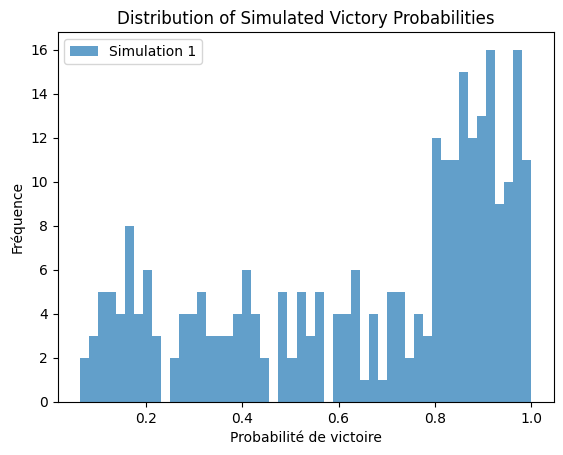

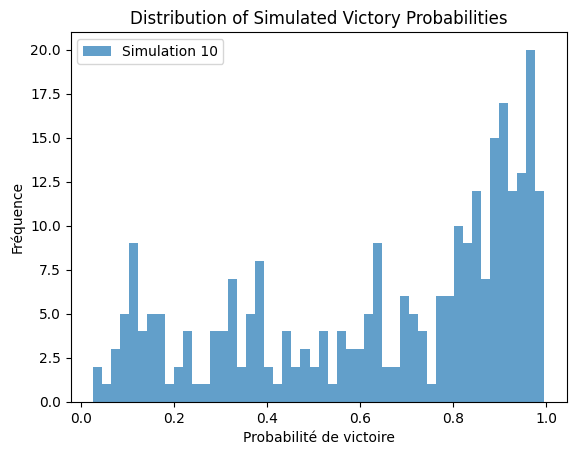

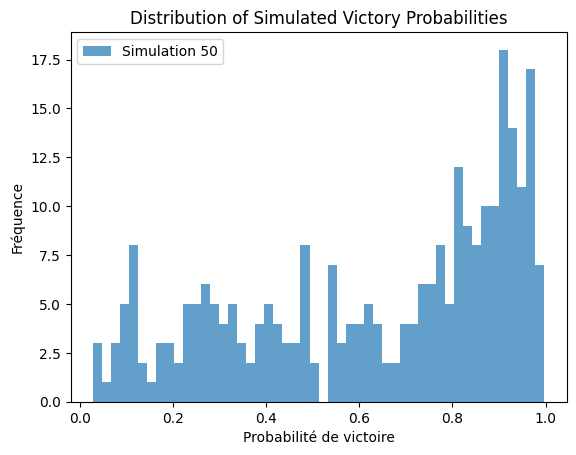

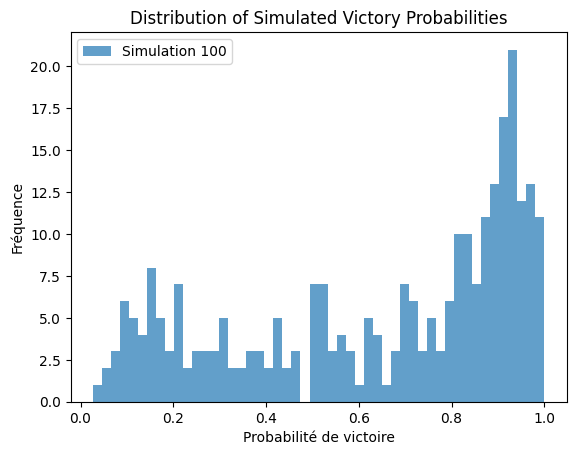

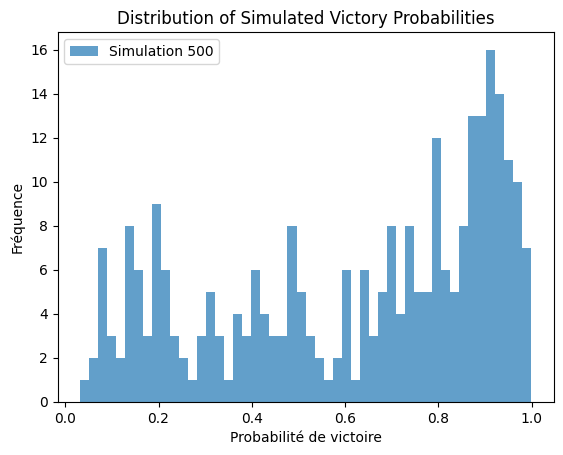

In [71]:
l = [0,9,49,99,499]
for i in l: 
    plt.hist(simulated_win_probas[i], bins=50, alpha=0.7, label=f'Simulation {i+1}')
    plt.xlabel('Probabilité de victoire')
    plt.ylabel('Fréquence')
    plt.title('Distribution of Simulated Victory Probabilities')
    plt.legend()
    plt.show()

In [72]:
feature_impacts = {feature: np.std([scenario[feature].mean() for scenario in scenarios]) for feature in features}
sorted_features = sorted(feature_impacts.items(), key=lambda item: item[1], reverse=True)
print("Most important features : ")
for feature, impact in sorted_features:
    print(f"{feature}: {impact}")

Most important features : 
totalDamageDealt: 941.4977998190742
totalDamageTaken: 416.49673771745904
totalHealsOnTeammates: 124.3090166138285
damageDealtToObjectives: 121.21194294410368
damageDealtToTurrets: 52.47663435965614
totalPings: 3.7248139423511493
goldPerMinute: 3.0976510586614046
assists: 0.40436812302297975
kda: 0.2989016339223013
visionScorePerMinute: 0.05421620796554736
visionScoreAdvantageLaneOpponent: 0.030464872018548802


In [73]:
combined_feature_impacts_increase = {}
combined_feature_impacts_decrease = {}
combined_features = ['goldPerMinute', 'totalPings', 'kda', 'totalDamageTaken']

for feature in combined_features:
    modified_scenarios_increase = []
    for scenario in scenarios:
        modified_scenario_increase = scenario.copy()
        modified_scenario_increase[feature] *= 1.1
        modified_scenarios_increase.append(modified_scenario_increase)
    combined_feature_impacts_increase[feature] = np.mean(simulate_win_probabilities(modified_scenarios_increase, ensemble_clf))
    
    modified_scenarios_decrease = []
    for scenario in scenarios:
        modified_scenario_decrease = scenario.copy()
        modified_scenario_decrease[feature] *= 0.9 
        modified_scenarios_decrease.append(modified_scenario_decrease)
    combined_feature_impacts_decrease[feature] = np.mean(simulate_win_probabilities(modified_scenarios_decrease, ensemble_clf))

print("Impact of increasing the feature by 10% : ")
print(combined_feature_impacts_increase)
print("Impact of decreasing the feature by 10%")
print(combined_feature_impacts_decrease)

Impact of increasing the feature by 10% : 
{'goldPerMinute': 0.6821245299433771, 'totalPings': 0.6482926597482912, 'kda': 0.6502012438393336, 'totalDamageTaken': 0.6298461419298793}
Impact of decreasing the feature by 10%
{'goldPerMinute': 0.5778505571644517, 'totalPings': 0.6325605078091587, 'kda': 0.6298258605083806, 'totalDamageTaken': 0.6546418955209566}


In [74]:
def calculate_feature_influence(scenarios, model, features, prct=0.1):
    feature_influence = {}
    
    for feature in features:
        modified_scenarios_increase = []
        for scenario in scenarios:
            modified_scenario = scenario.copy()
            modified_scenario[feature] *= (1 + prct)
            modified_scenarios_increase.append(modified_scenario)

        win_proba_increase = np.mean(simulate_win_probabilities(modified_scenarios_increase, model))
        modified_scenarios_decrease = []
        for scenario in scenarios:
            modified_scenario = scenario.copy()
            modified_scenario[feature] *= (1 - prct)
            modified_scenarios_decrease.append(modified_scenario)

        win_proba_decrease = np.mean(simulate_win_probabilities(modified_scenarios_decrease, model))

        original_win_proba = np.mean(simulate_win_probabilities(scenarios, model))
        influence_increase = win_proba_increase - original_win_proba
        influence_decrease = original_win_proba - win_proba_decrease
        
        feature_influence[feature] = {
            'increase': influence_increase,
            'decrease': influence_decrease,
            'total_influence': influence_increase + influence_decrease
        }
    
    return feature_influence

feature_influence = calculate_feature_influence(scenarios, ensemble_clf, features)

print("Influence des features :")
for feature, influence in feature_influence.items():
    print(f"{feature}: increasing by 10% -> {influence['increase']*100:.2f}% probability of victory")
    print(f"{feature}: decreasing by 10% -> {influence['decrease']*100:.2f}% probability of victory")
    print(f"{feature}: Influence -> {influence['total_influence']*100:.2f}% probability of victory")


Influence des features :
kda: increasing by 10% -> 0.90% probability of victory
kda: decreasing by 10% -> 1.14% probability of victory
kda: Influence -> 2.04% probability of victory
goldPerMinute: increasing by 10% -> 4.09% probability of victory
goldPerMinute: decreasing by 10% -> 6.33% probability of victory
goldPerMinute: Influence -> 10.43% probability of victory
damageDealtToObjectives: increasing by 10% -> 0.24% probability of victory
damageDealtToObjectives: decreasing by 10% -> 0.24% probability of victory
damageDealtToObjectives: Influence -> 0.48% probability of victory
damageDealtToTurrets: increasing by 10% -> 0.33% probability of victory
damageDealtToTurrets: decreasing by 10% -> 0.36% probability of victory
damageDealtToTurrets: Influence -> 0.69% probability of victory
assists: increasing by 10% -> 0.94% probability of victory
assists: decreasing by 10% -> 1.06% probability of victory
assists: Influence -> 2.00% probability of victory
visionScoreAdvantageLaneOpponent: in

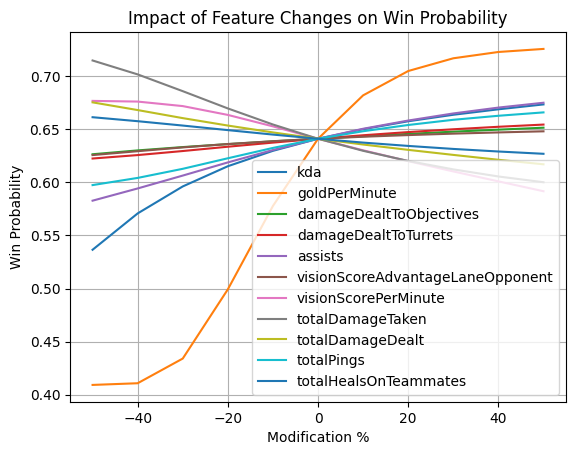

In [75]:
def calculate_feature_influence(scenarios, model, features, modification_percentages):
    feature_influence = {}
    feature_proba_vs_modification = {}
    
    for feature in features:
        probabilities = []
        for percentage in modification_percentages:
            modified_scenarios = []
            for scenario in scenarios:
                modified_scenario = scenario.copy()
                modified_scenario[feature] *= (1 + percentage)
                modified_scenarios.append(modified_scenario)

            win_proba = np.mean(simulate_win_probabilities(modified_scenarios, model))
            probabilities.append(win_proba)
        
        feature_proba_vs_modification[feature] = probabilities
    
    return feature_proba_vs_modification

modification_percentages = np.linspace(-0.5, 0.5, 11)

feature_proba_vs_modification = calculate_feature_influence(scenarios, ensemble_clf, features, modification_percentages)

for feature, probabilities in feature_proba_vs_modification.items():
    plt.plot(modification_percentages * 100, probabilities, label=feature)

plt.xlabel('Modification %')
plt.ylabel('Win Probability')
plt.title('Impact of Feature Changes on Win Probability')
plt.legend()
plt.grid(True)
plt.show()

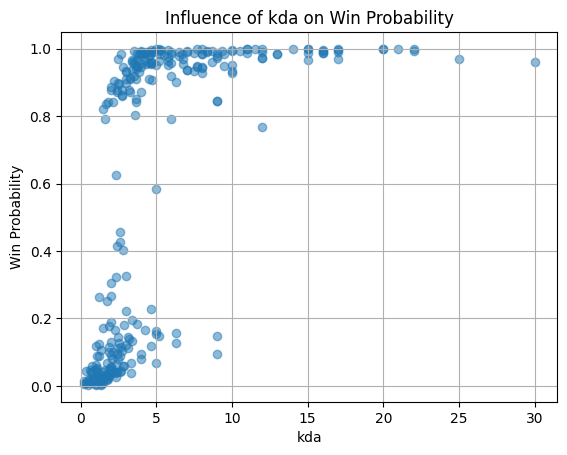

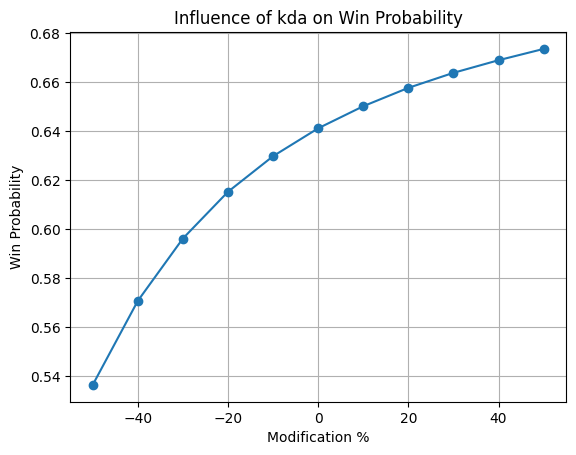

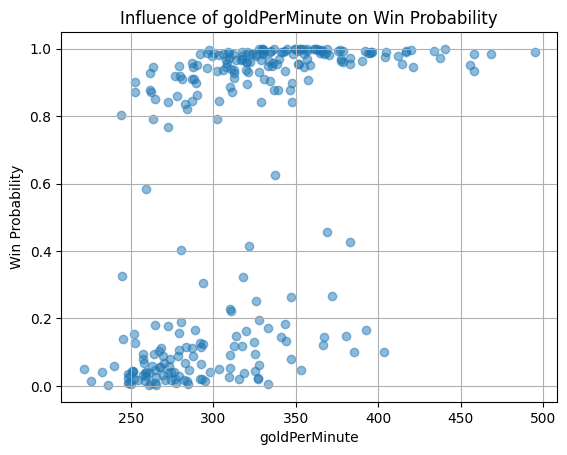

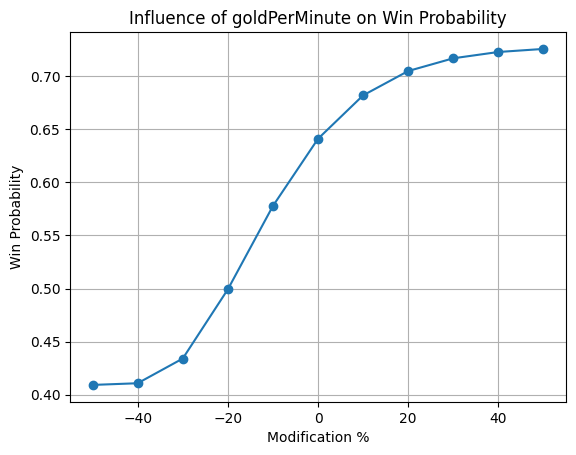

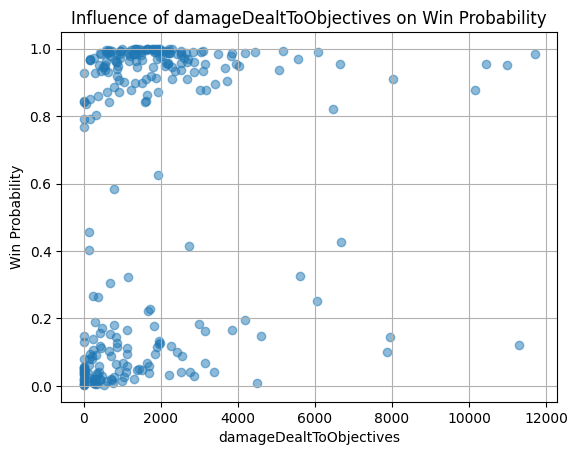

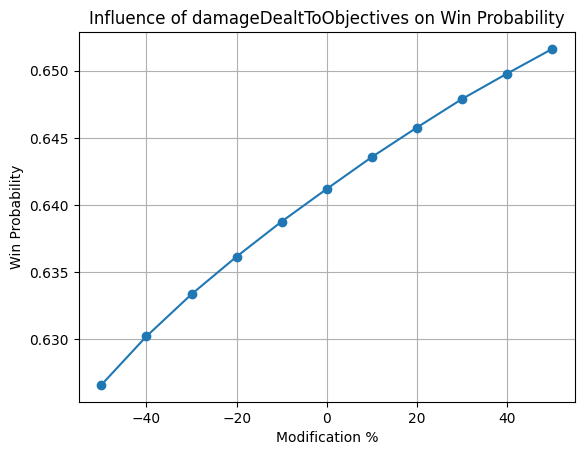

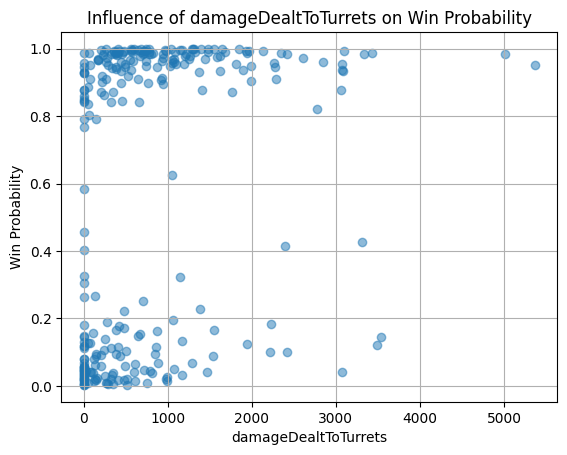

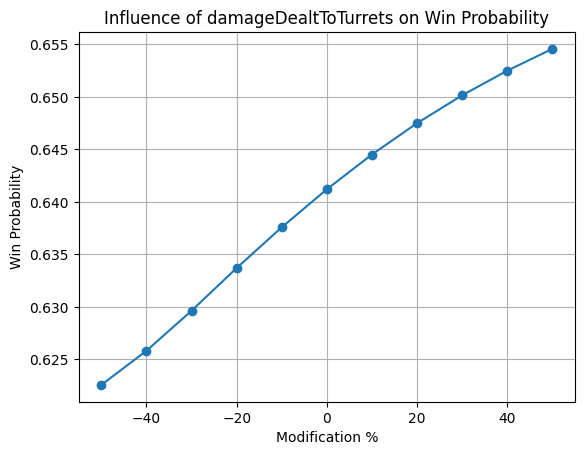

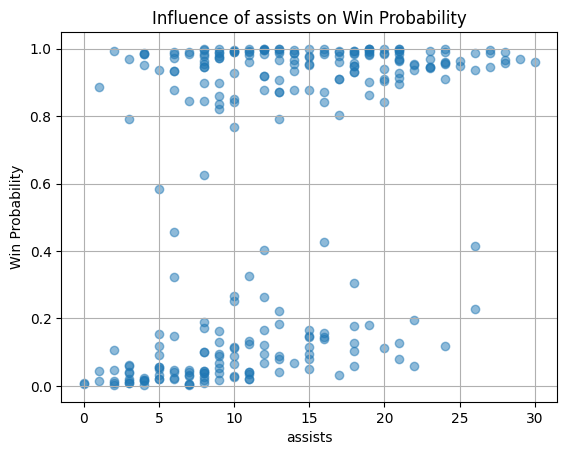

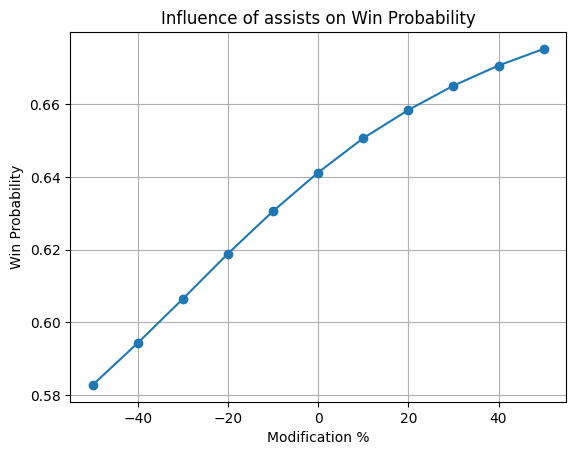

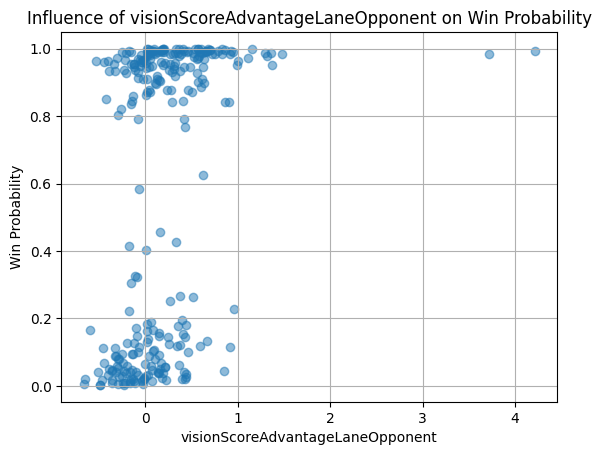

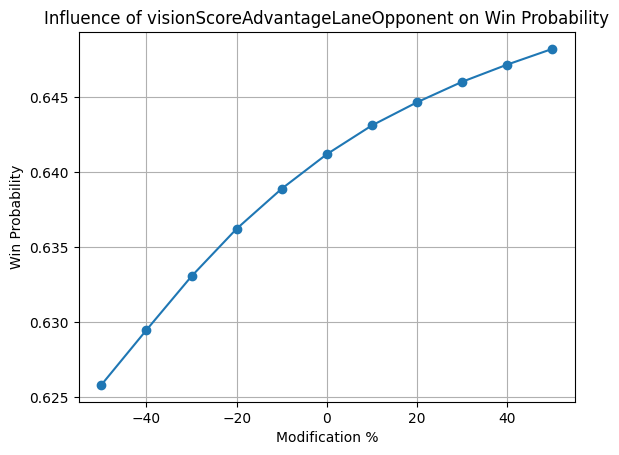

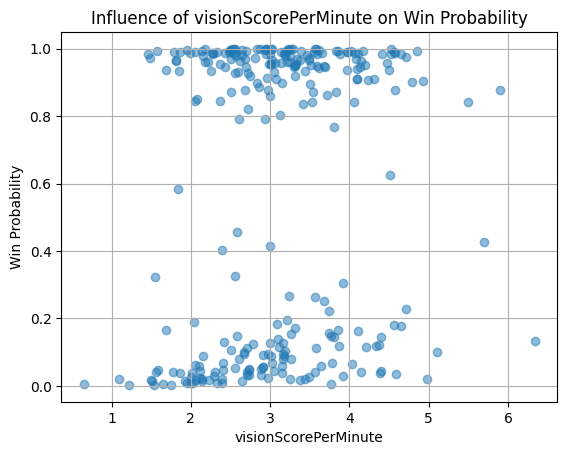

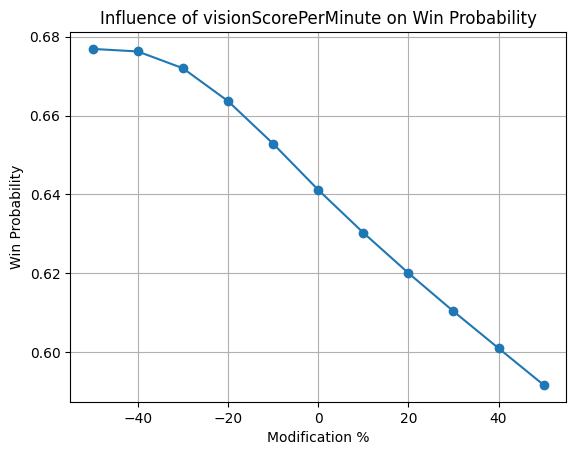

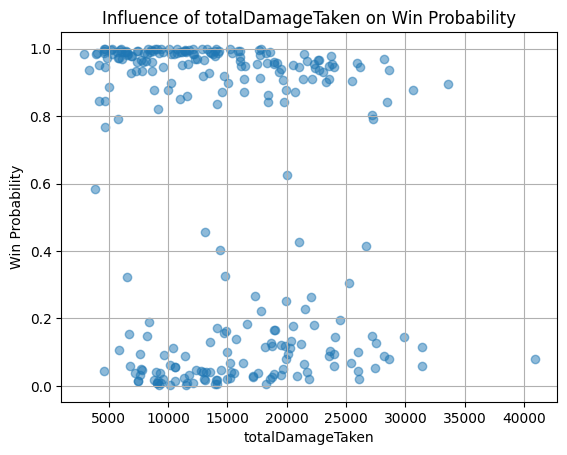

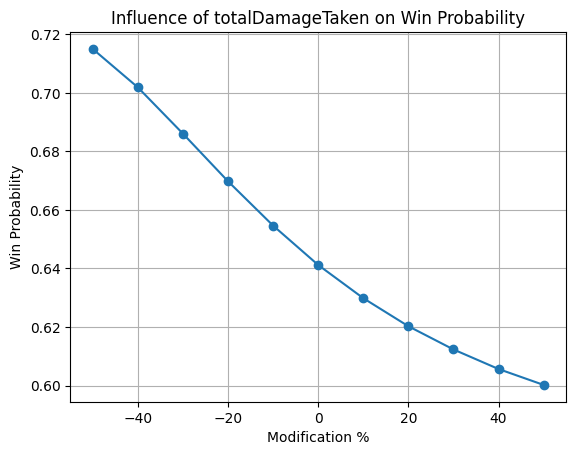

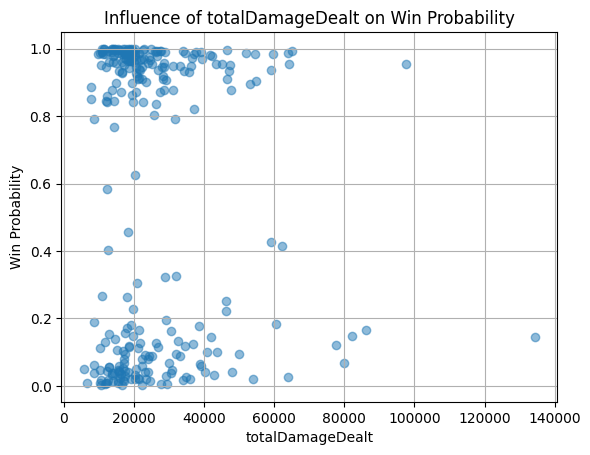

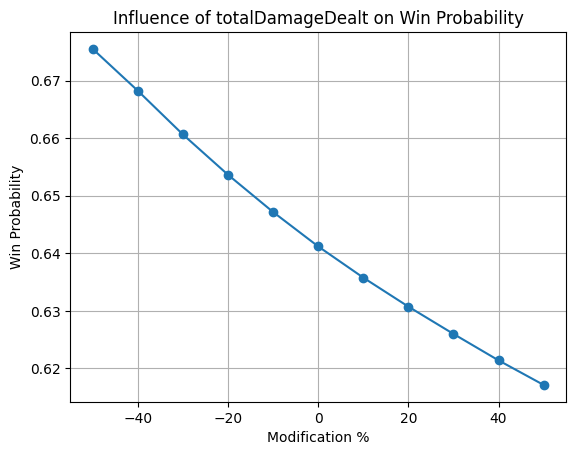

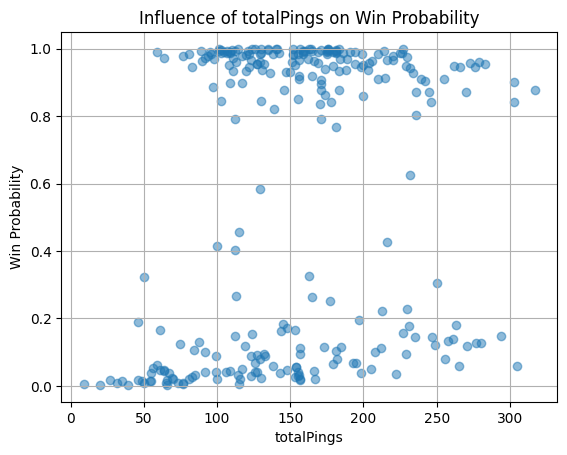

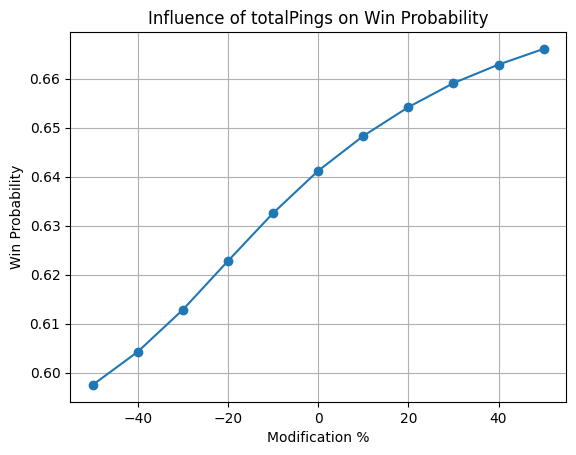

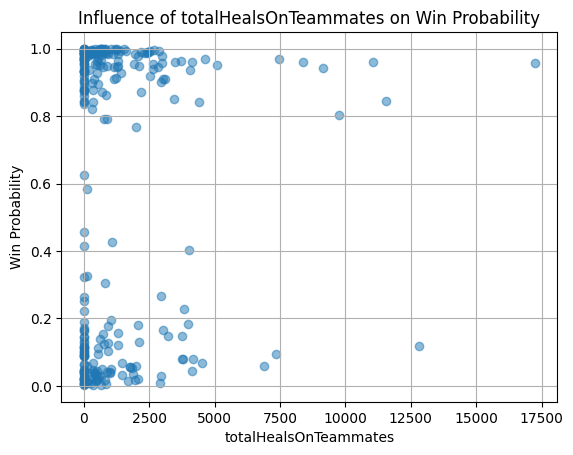

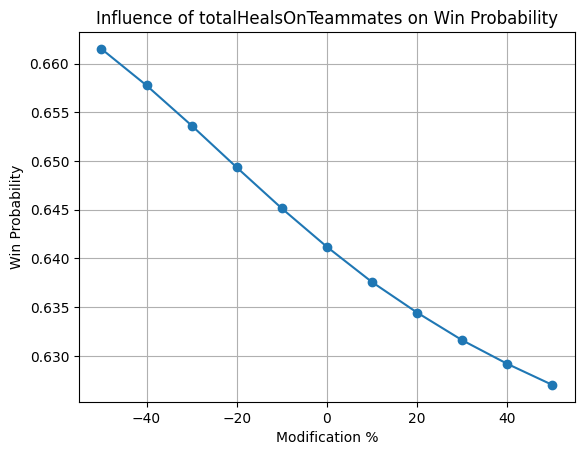

In [76]:
for feature in features:
    plt.scatter(Mata[feature], Mata['WinProba'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Win Probability')
    plt.title(f'Influence of {feature} on Win Probability')
    plt.grid(True)
    plt.show()

    # Line plot pour visualiser comment la modification de la feature influence la probabilité de victoire
    plt.plot(modification_percentages * 100, feature_proba_vs_modification[feature], marker='o')
    plt.xlabel('Modification %')
    plt.ylabel('Win Probability')
    plt.title(f'Influence of {feature} on Win Probability')
    plt.grid(True)
    plt.show()

## Mata - HMM

Model is not converging.  Current: -62802.95897453437 is not greater than -62802.82778966154. Delta is -0.13118487282918068


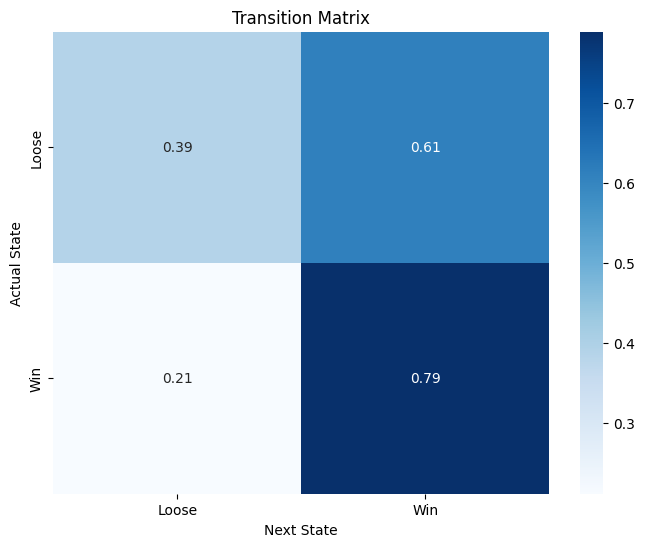

array([[0.38727285, 0.61272715],
       [0.21105884, 0.78894116]])

In [77]:
Mata = Mata.drop("WinProba", axis=1) 
XMata = Mata[features]
yMata = Mata['result']

XMata = Mata.values
yMata = yMata.map({'victoire': 0, 'défaite': 1}).values

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
model.fit(Mata)

transmat = model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transmat, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Loose", "Win"], yticklabels=["Loose", "Win"])
plt.title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Actual State")
plt.show()

transmat

In [78]:
victories = Mata[Mata['result'] == 1]
defeats = Mata[Mata['result'] == 0]

mean_stats_victories = victories.mean(numeric_only=True)
mean_stats_defeats = defeats.mean(numeric_only=True)

mean_stats = pd.DataFrame({
    'Victoire': mean_stats_victories,
    'Défaite': mean_stats_defeats
})

t_tests = {}
for column in victories.select_dtypes(include=[np.float64, np.int64]).columns:
    t_stat, p_val = ttest_ind(victories[column], defeats[column], equal_var=False)
    t_tests[column] = (t_stat, p_val)

t_tests_df = pd.DataFrame(t_tests, index=['t_stat', 'p_val']).T
significant_columns = t_tests_df[t_tests_df['p_val'] < 0.05].index.tolist()

significant_columns = [col for col in significant_columns if col in mean_stats.index]

print("Average statistics for wins and losses : ")
print(mean_stats)

Average statistics for wins and losses : 
                                       Victoire       Défaite
Team                                   0.478528      0.508929
GameTime                              24.129857     24.946726
result                                 1.000000      0.000000
kda                                    7.153775      2.233007
kills                                  2.822086      2.330357
deaths                                 3.631902      6.151786
assists                               15.024540      9.455357
SoloKills                              0.184049      0.196429
quickSoloKills                         0.000000      0.000000
killsUnderOwnTurret                    0.404908      0.303571
killsNearEnemyTurret                   0.680982      0.500000
firstBloodAssist                       0.251534      0.214286
firstBloodKill                         0.073620      0.062500
doubleKills                            0.147239      0.053571
tripleKills                 

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [79]:
print("\nColumns with significant differences (p < 0.05) :")
print(t_tests_df[t_tests_df['p_val'] < 0.05])


Columns with significant differences (p < 0.05) :
                                      t_stat         p_val
result                                   inf  0.000000e+00
kda                                11.364508  1.791500e-23
deaths                             -7.574171  8.045539e-13
assists                             7.529836  8.099218e-13
doubleKills                         2.327248  2.068551e-02
killingSprees                       1.979757  4.884018e-02
turretKills                         4.143723  4.594783e-05
turretPlatesTaken                   2.034324  4.293849e-02
kTurretsDestroyedBeforePlatesFall   1.996416  4.688460e-02
champLevel                          2.877840  4.354139e-03
visionScoreAdvantageLaneOpponent    5.921075  9.900913e-09
visionScorePerMinute                2.106493  3.631162e-02
totalMinionsKilled                 -2.185386  2.989654e-02
goldPerMinute                       8.363452  3.541534e-15
goldEarned                          2.449391  1.507113e-02
lanin

In [80]:
featuresb = [
    'kda', 'deaths', 'assists', 'doubleKills', 'killingSprees', 'turretKills',
    'turretPlatesTaken', 'kTurretsDestroyedBeforePlatesFall', 'champLevel',
    'visionScoreAdvantageLaneOpponent', 'visionScorePerMinute', 'totalMinionsKilled',
    'goldPerMinute', 'goldEarned', 'laningPhaseGoldExpAdvantage', 'magicDamageTaken',
    'physicalDamageTaken', 'totalDamageTaken', 'damageDealtToBuildings',
    'damageDealtToObjectives', 'damageDealtToTurrets', 'totalTimeSpentDead',
    'totalPings'
]

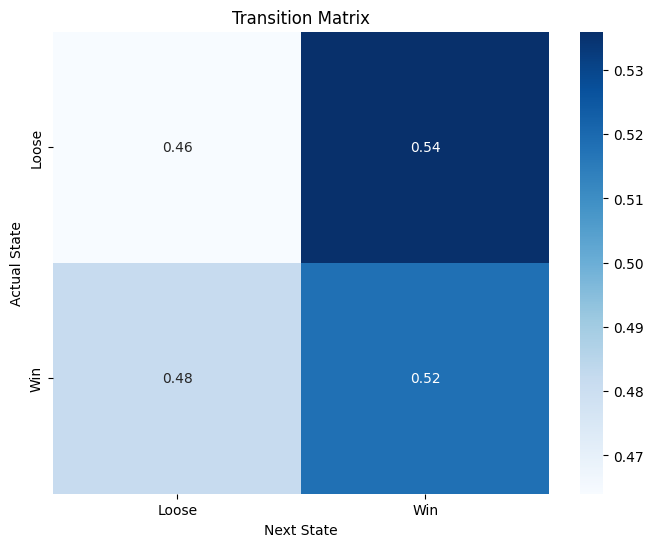

array([[0.46403198, 0.53596802],
       [0.48185642, 0.51814358]])

In [81]:
XMata = Mata[featuresb]
yMata = Mata['result']

XMata = XMata.values
yMata = yMata.map({'victoire': 0, 'défaite': 1}).values

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
model.fit(XMata)

transmat = model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transmat, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Loose", "Win"], yticklabels=["Loose", "Win"])
plt.title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Actual State")
plt.show()

transmat

## Mata - Time series

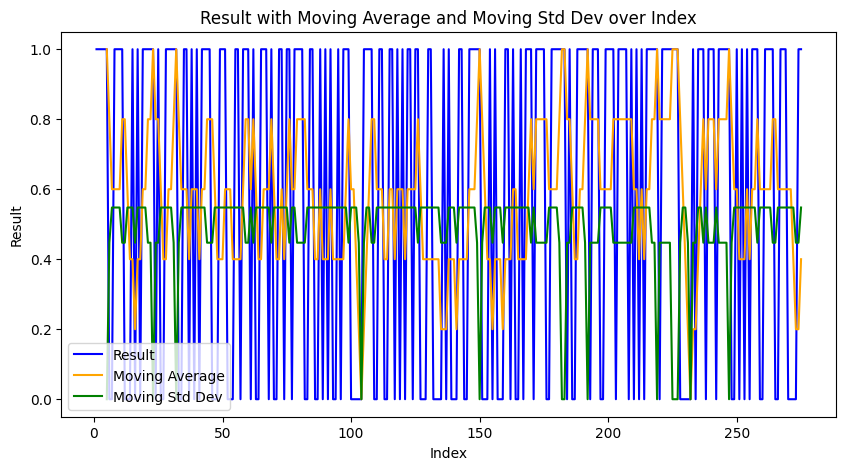

In [82]:
Mata2 = Mata.copy()
Mata2['index'] = range(1, len(Mata2) + 1)
Mata2['Moving_Average'] = Mata2['result'].rolling(window=5).mean()
Mata2['Moving_Std_Dev'] = Mata2['result'].rolling(window=5).std()

plt.figure(figsize=(10, 5))
plt.plot(Mata2['index'], Mata2['result'], label='Result', color='blue')
plt.plot(Mata2['index'], Mata2['Moving_Average'], label='Moving Average', color='orange')
plt.plot(Mata2['index'], Mata2['Moving_Std_Dev'], label='Moving Std Dev', color='green')
plt.xlabel('Index')
plt.ylabel('Result')
plt.title('Result with Moving Average and Moving Std Dev over Index')
plt.legend()
plt.show()

In [83]:
adf_result = adfuller(Mata2['result'])
print(f"ADF Statistique test : {adf_result[0]}")
print(f"p-value : {adf_result[1]}")
print(f"Nb lags : {adf_result[2]}")
print(f"Nb observations : {adf_result[3]}")
print(f"Critical values : {adf_result[4]}")

kpss_result = kpss(Mata2['result'], regression='c')
print(f"KPSS Statistique test : {kpss_result[0]}")
print(f"p-value : {kpss_result[1]}")
print(f"Nb lags : {kpss_result[2]}")
print(f"Critical values : {kpss_result[3]}")

ADF Statistique test : -11.588549310962136
p-value : 2.828409361333189e-21
Nb lags : 2
Nb observations : 272
Critical values : {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}
KPSS Statistique test : 0.2014555424668318
p-value : 0.1
Nb lags : 11
Critical values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



ADF: Rejection of non-stationarity with very high confidence.
KPSS: No rejection of stationarity.

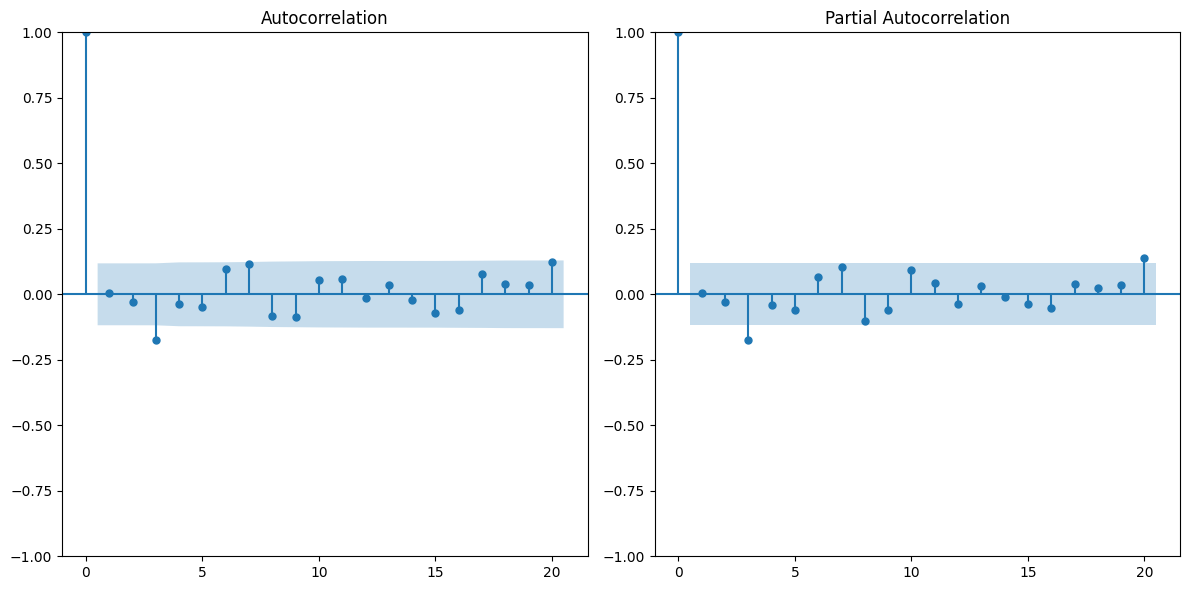

In [84]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(Mata2['result'].dropna(), ax=plt.gca(), lags=20)

plt.subplot(122)
plot_pacf(Mata2['result'].dropna(), ax=plt.gca(), lags=20, method='ywm')

plt.tight_layout()
plt.show()

In [87]:
model = ARIMA(Mata2['result'], order=(1, 0, 2))
fitted_arima = model.fit()

model_sarima = SARIMAX(Mata2['result'], order=(1, 0, 2), seasonal_order=(1, 0, 1, 7))
fitted_sarima = model_sarima.fit()

comparison = pd.DataFrame({
    "Model": ["ARIMA(1, 0, 2)", "SARIMA(1, 0, 2, 1, 0, 1, 7)"],
    "AIC": [fitted_arima.aic, fitted_sarima.aic],
    "BIC": [fitted_arima.bic, fitted_sarima.bic]
})

comparison

An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37145D+00    |proj g|=  9.20039D+00

At iterate    5    f=  7.81515D-01    |proj g|=  1.19086D-01

At iterate   10    f=  7.74602D-01    |proj g|=  1.75507D-02

At iterate   15    f=  7.71128D-01    |proj g|=  4.41864D-02

At iterate   20    f=  7.56456D-01    |proj g|=  1.75758D-02

At iterate   25    f=  7.44918D-01    |proj g|=  1.93642D-02

At iterate   30    f=  7.33234D-01    |proj g|=  1.87833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Model         AIC         BIC
0               ARIMA(1, 0, 2)  395.943031  414.026887
1  SARIMA(1, 0, 2, 1, 0, 1, 7)  415.278908  436.979534

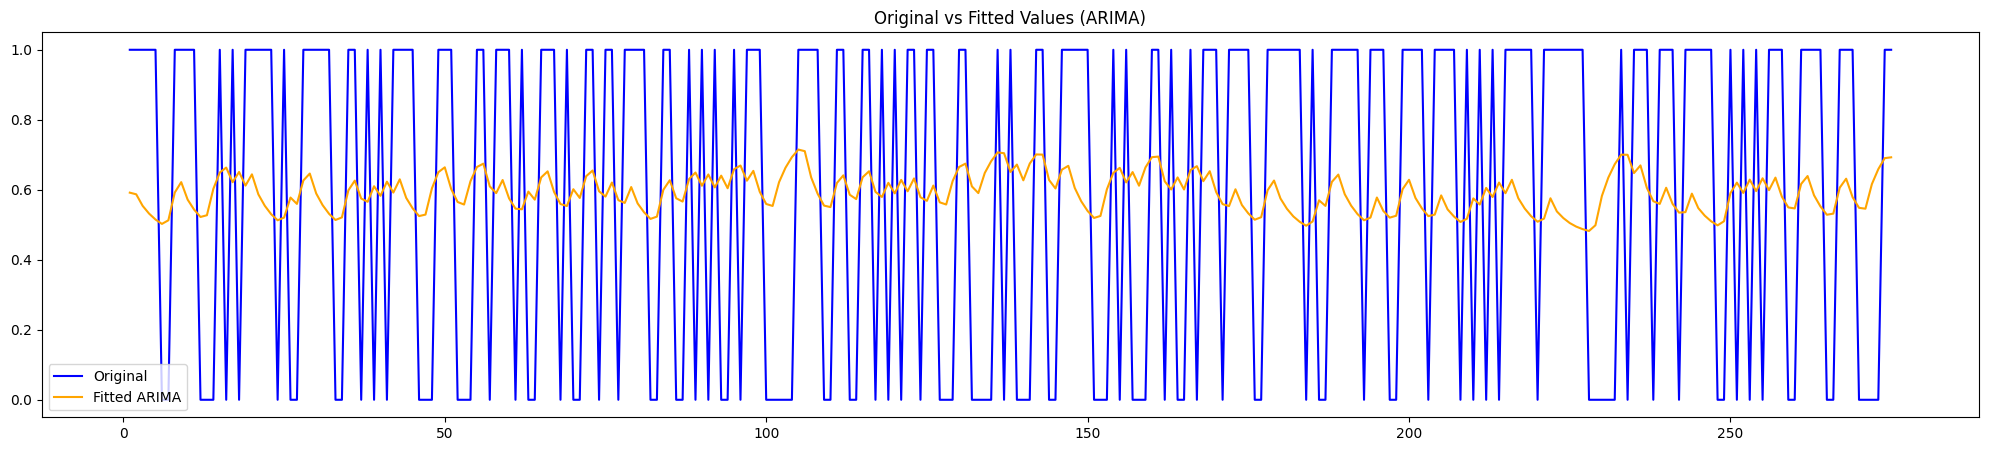

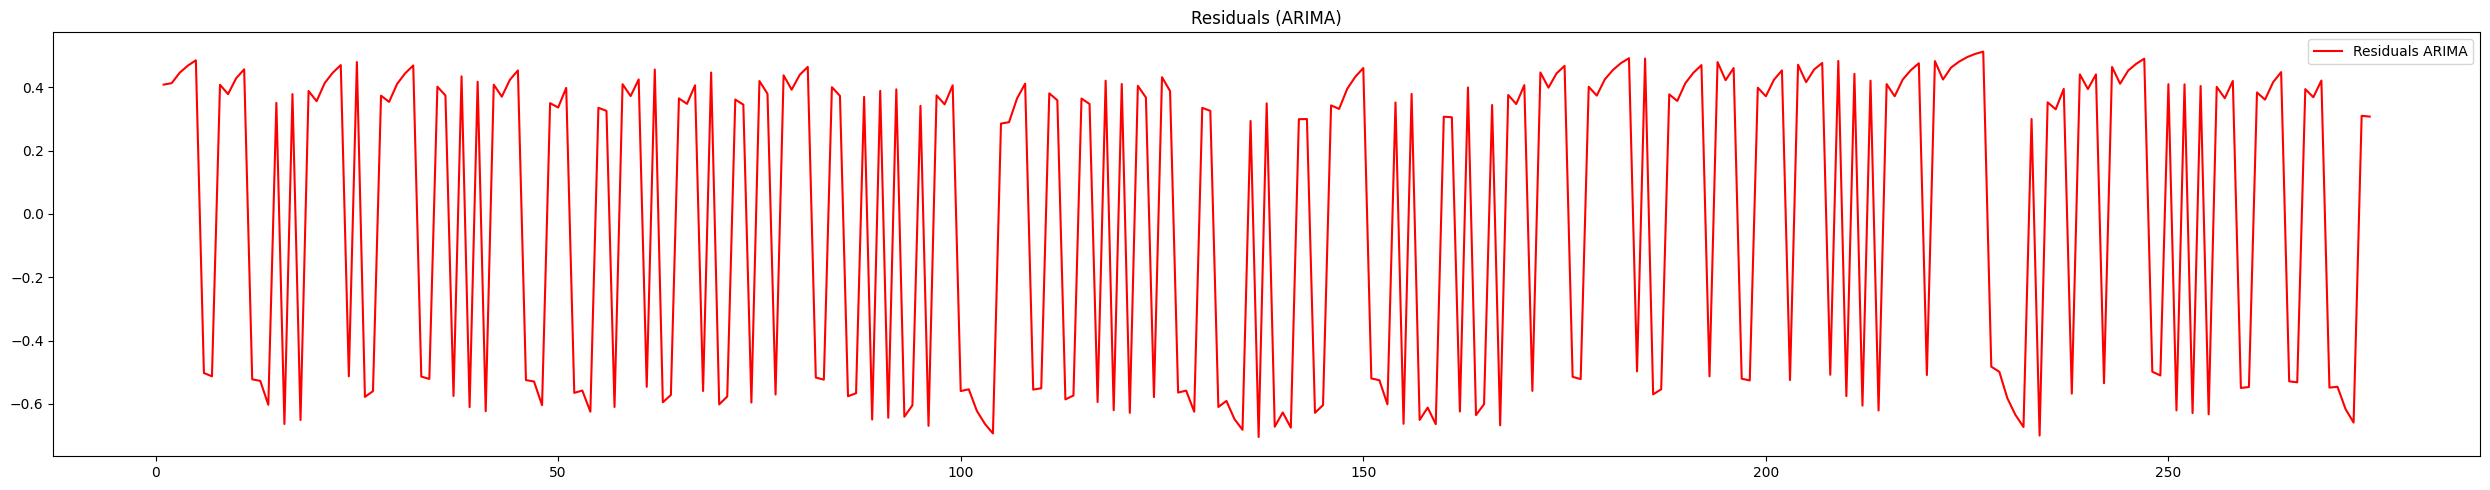

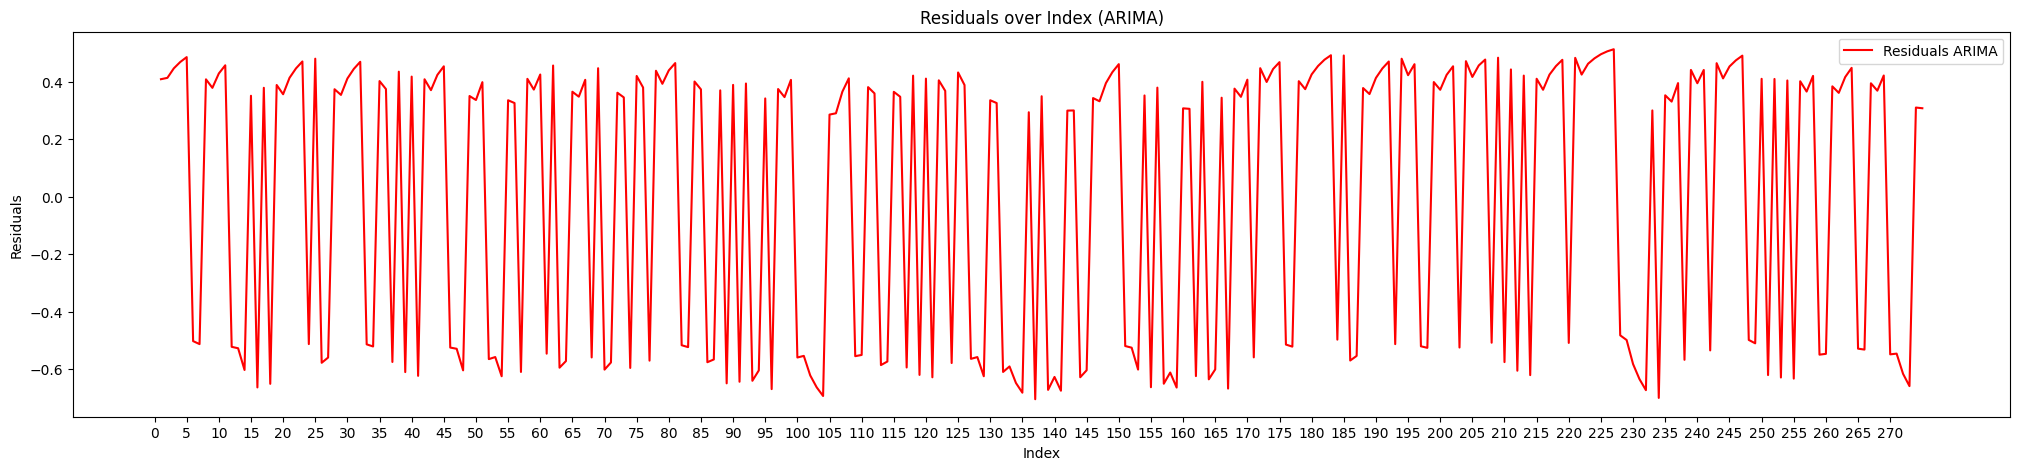

In [88]:
Mata2['fitted_arima'] = fitted_arima.fittedvalues
Mata2['residuals_arima'] = fitted_arima.resid

plt.figure(figsize=(25, 5))
plt.plot(Mata2['index'], Mata2['result'], label='Original', color='blue')
plt.plot(Mata2['index'], Mata2['fitted_arima'], label='Fitted ARIMA', color='orange')
plt.title('Original vs Fitted Values (ARIMA)')
plt.legend()

plt.figure(figsize=(25, 5))
plt.plot(Mata2['index'], Mata2['residuals_arima'], label='Residuals ARIMA', color='red')
plt.title('Residuals (ARIMA)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 5))
plt.plot(Mata2['index'], Mata2['residuals_arima'], label='Residuals ARIMA', color='red')
plt.title('Residuals over Index (ARIMA)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.xticks(ticks=range(0, len(Mata2['index']), 5))
plt.legend()
plt.show()


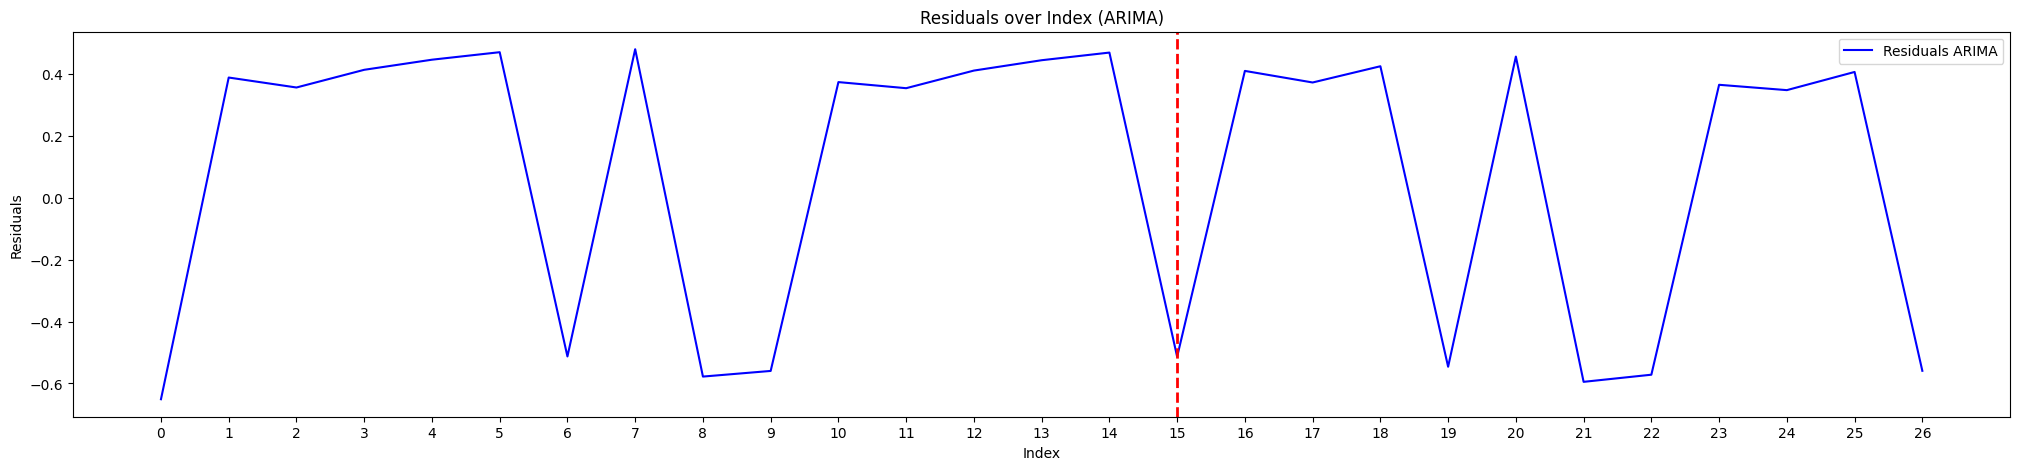

In [89]:
subset1 = Mata2[(Mata2['index'] >= 18) & (Mata2['index'] <= 33)].copy()
subset2 = Mata2[(Mata2['index'] >= 58) & (Mata2['index'] <= 68)].copy()

subset1.loc[:, 'new_index'] = range(len(subset1))
subset2.loc[:, 'new_index'] = range(len(subset1), len(subset1) + len(subset2))

combined_subset = pd.concat([subset1, subset2])

plt.figure(figsize=(25, 5))
plt.plot(combined_subset['new_index'], combined_subset['residuals_arima'], label='Residuals ARIMA', color='blue')

plt.axvline(x=len(subset1) - 1, color='red', linestyle='--', linewidth=2)

plt.title('Residuals over Index (ARIMA)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.xticks(ticks=range(combined_subset['new_index'].min(), combined_subset['new_index'].max() + 1))
plt.legend()
plt.show()

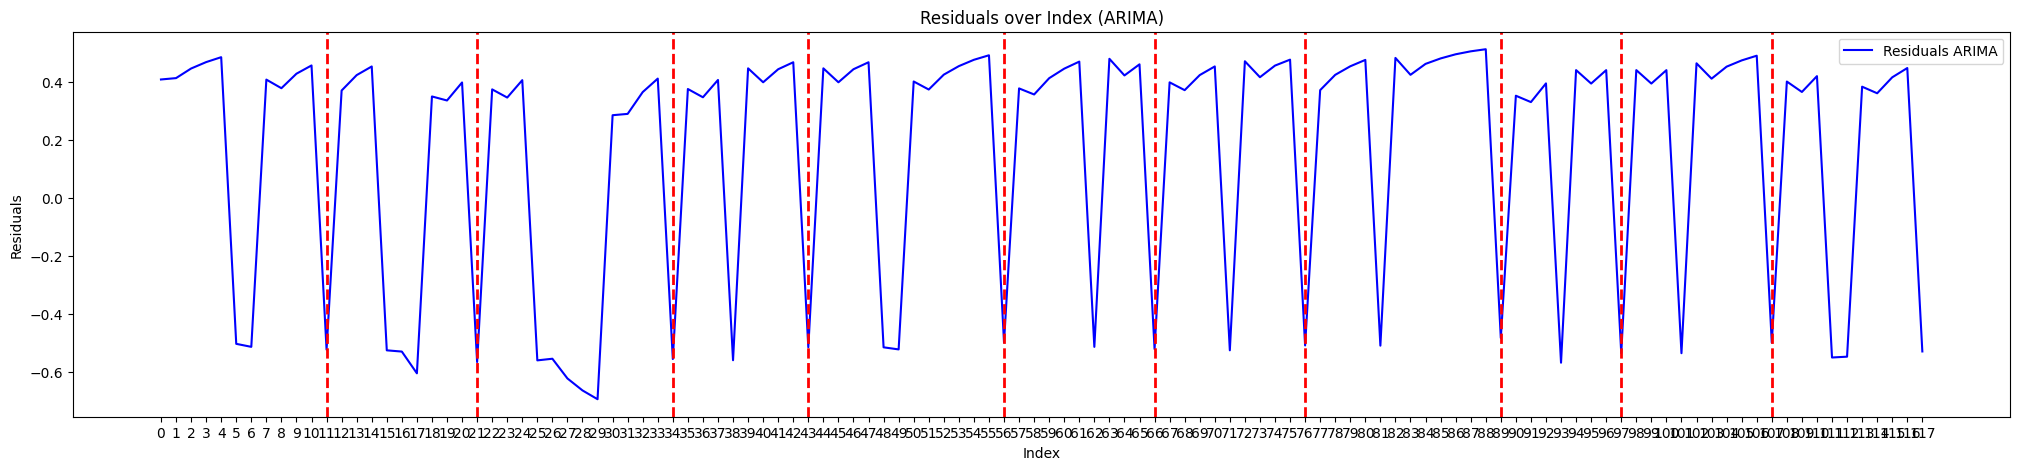

In [90]:
intervals = [
    (0, 12),
    (43, 52),
    (97, 109),
    (168, 176),
    (172, 184),
    (188, 197),
    (199, 208),
    (216, 228),
    (235, 242),
    (239, 248),
    (256, 265)
]

subsets = []

current_index = 0
for start, end in intervals:
    subset = Mata2[(Mata2['index'] >= start) & (Mata2['index'] <= end)].copy()
    subset.loc[:, 'new_index'] = range(current_index, current_index + len(subset))
    subsets.append(subset)
    current_index += len(subset)

combined_subset = pd.concat(subsets)

plt.figure(figsize=(25, 5))
plt.plot(combined_subset['new_index'], combined_subset['residuals_arima'], label='Residuals ARIMA', color='blue')

for i, subset in enumerate(subsets[:-1]):
    plt.axvline(x=subsets[i]['new_index'].max(), color='red', linestyle='--', linewidth=2)

plt.title('Residuals over Index (ARIMA)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.xticks(ticks=range(combined_subset['new_index'].min(), combined_subset['new_index'].max() + 1))
plt.legend()
plt.show()

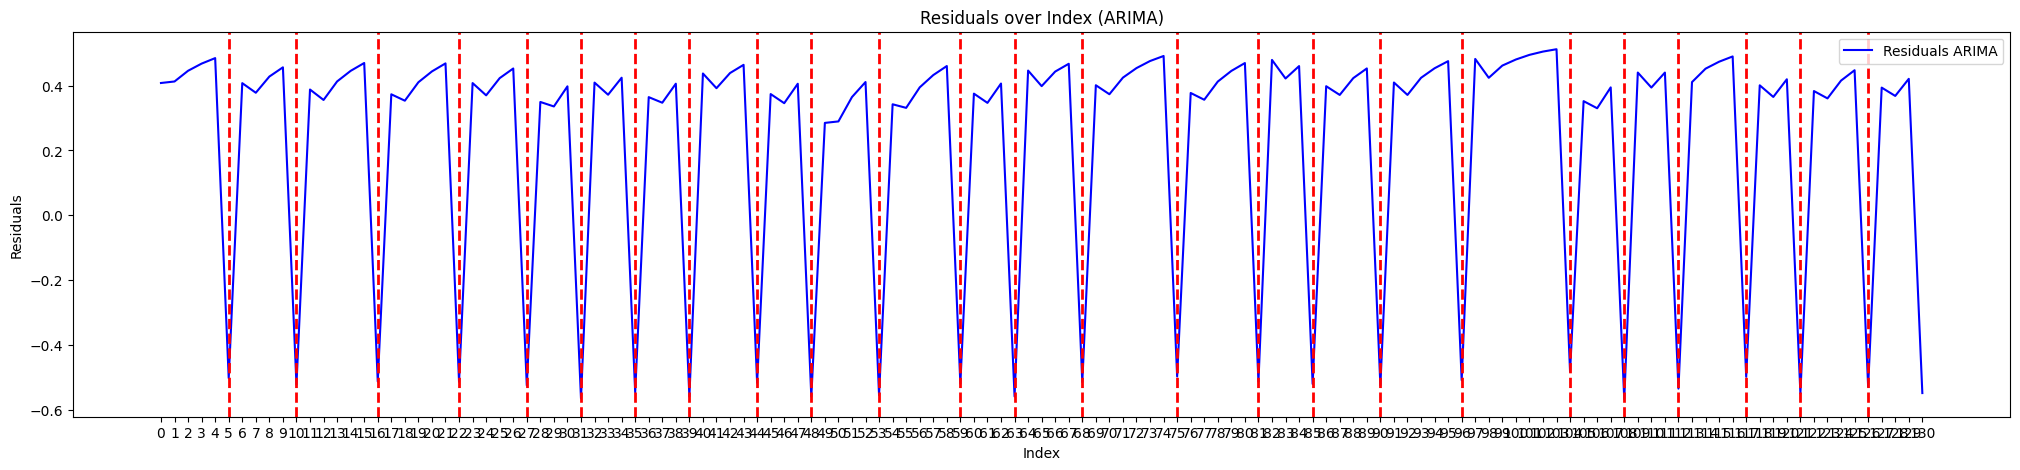

In [91]:
intervals = [
    (0, 6),
    (8, 12),
    (19, 24),
    (28, 33),
    (42, 46),
    (49, 52),
    (58, 61),
    (65, 68),
    (78, 82),
    (97, 100),
    (105, 109),
    (146, 151),
    (168, 171),
    (172, 176),
    (178, 184),
    (188, 193),
    (194, 197),
    (199, 203),
    (215, 220),
    (221, 228),
    (235, 238),
    (239, 242),
    (244, 248),
    (256, 259),
    (261, 265),
    (267, 270)
]

subsets = []
current_index = 0
for start, end in intervals:
    subset = Mata2[(Mata2['index'] >= start) & (Mata2['index'] <= end)].copy()
    subset.loc[:, 'new_index'] = range(current_index, current_index + len(subset))
    subsets.append(subset)
    current_index += len(subset)

combined_subset = pd.concat(subsets)

plt.figure(figsize=(25, 5))
plt.plot(combined_subset['new_index'], combined_subset['residuals_arima'], label='Residuals ARIMA', color='blue')

for i, subset in enumerate(subsets[:-1]):
    plt.axvline(x=subsets[i]['new_index'].max(), color='red', linestyle='--', linewidth=2)

plt.title('Residuals over Index (ARIMA)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.xticks(ticks=range(combined_subset['new_index'].min(), combined_subset['new_index'].max() + 1))
plt.legend()
plt.show()

In [119]:
stat, p = shapiro(Mata2['residuals_arima'].dropna())
print('Shapiro-Wilk Test: Statistics=%.3f, p-value=%.3f' % (stat, p))

lb_test = acorr_ljungbox(Mata2['residuals_arima'].dropna(), lags=[20], return_df=True)
print(lb_test)

Shapiro-Wilk Test: Statistics=0.720, p-value=0.000
      lb_stat  lb_pvalue
20  27.749941   0.115452


# Appendix

## Guwon

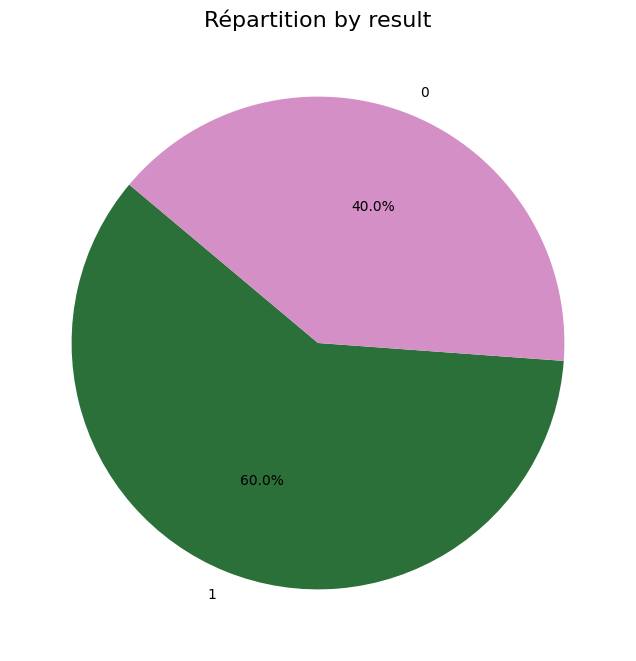

In [92]:
result_counts = Guwon['result'].value_counts()
palette = sns.color_palette("cubehelix", len(result_counts))
plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Répartition by result', fontsize=16)
plt.show()

In [93]:
Guwon = Guwon.drop(['Name','individualPosition'], axis=1)
XGuwon = Guwon.drop('result', axis=1) 
yGuwon = Guwon['result']
X_trainGuwon, X_testGuwon, y_trainGuwon, y_testGuwon = train_test_split(XGuwon, yGuwon, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_trainGuwon, y_trainGuwon)
y_pred_rfcGuwon = rfc.predict(X_testGuwon)

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_trainGuwon, y_trainGuwon)
y_pred_gbcGuwon = gbc.predict(X_testGuwon)

XGB =  XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
XGB.fit(X_trainGuwon, y_trainGuwon)
y_pred_XGBGuwon = XGB.predict(X_testGuwon)

print('Accuracy RFC :', accuracy_score(y_testGuwon, y_pred_rfcGuwon))
print('Classification Report RFC :', classification_report(y_testGuwon, y_pred_rfcGuwon))
scores_rfcGuwon = cross_val_score(rfc, X_trainGuwon, y_trainGuwon, cv=5)
print("Average accuracy in RFC cross-validation : ", scores_rfcGuwon.mean())

print('Accuracy GBC :', accuracy_score(y_testGuwon, y_pred_gbcGuwon))
print('Classification Report GBC :', classification_report(y_testGuwon, y_pred_gbcGuwon))
scores_gbcGuwon = cross_val_score(gbc, X_trainGuwon, y_trainGuwon, cv=5)
print("Average accuracy in GBC cross-validation : ", scores_gbcGuwon.mean())

print('Accuracy XGB :', accuracy_score(y_testGuwon, y_pred_XGBGuwon))
print('Classification Report XGB :', classification_report(y_testGuwon, y_pred_XGBGuwon))
scores_XGBGuwon = cross_val_score(XGB, X_trainGuwon, y_trainGuwon, cv=5)
print("Average accuracy in XGB cross-validation : ", scores_XGBGuwon.mean())

best_modelGuwon = rfc if scores_rfcGuwon.mean() > scores_gbcGuwon.mean() and scores_rfcGuwon.mean() > scores_XGBGuwon.mean() else gbc if scores_gbcGuwon.mean() > scores_XGBGuwon.mean() else XGB
print(f'Best one is : {"RFC" if best_modelGuwon == rfc else "GBC" if best_modelGuwon == gbc else "XGB"}')

Accuracy RFC : 0.8604651162790697
Classification Report RFC :               precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.89      0.89      0.89        57

    accuracy                           0.86        86
   macro avg       0.84      0.84      0.84        86
weighted avg       0.86      0.86      0.86        86

Average accuracy in RFC cross-validation :  0.8708439897698209
Accuracy GBC : 0.872093023255814
Classification Report GBC :               precision    recall  f1-score   support

           0       0.85      0.76      0.80        29
           1       0.88      0.93      0.91        57

    accuracy                           0.87        86
   macro avg       0.86      0.84      0.85        86
weighted avg       0.87      0.87      0.87        86

Average accuracy in GBC cross-validation :  0.8472719522591644
Accuracy XGB : 0.872093023255814
Classification Report XGB :               precision    recall  f

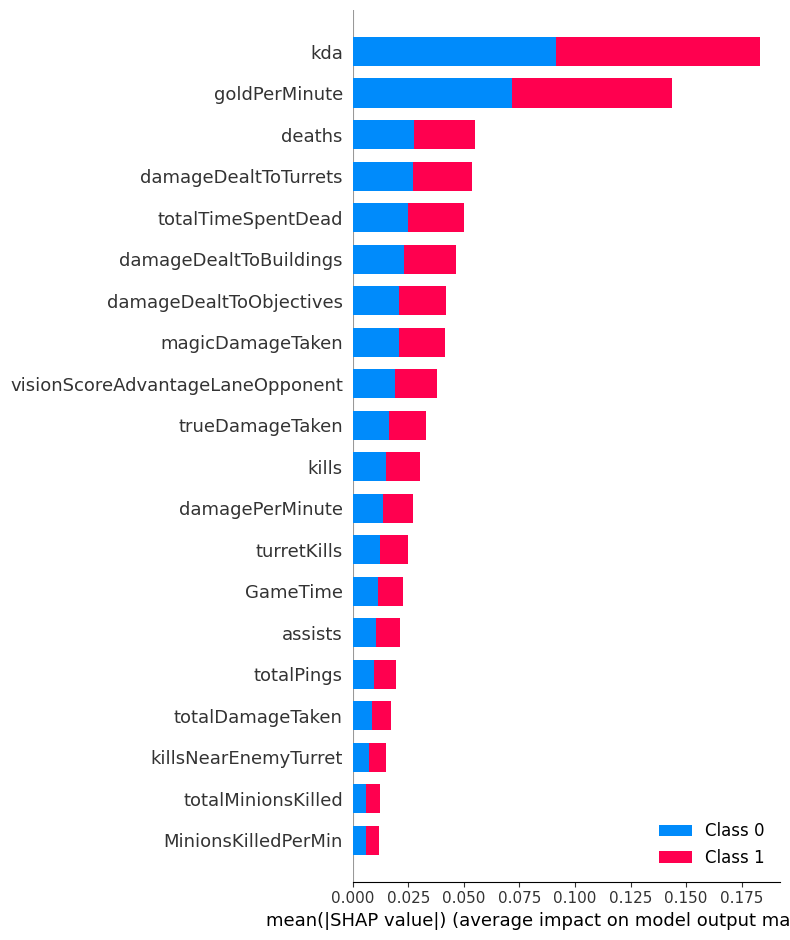

In [94]:
explainer = shap.TreeExplainer(best_modelGuwon)
shap_valuesGuwon = explainer.shap_values(X_testGuwon)

shap.summary_plot(shap_valuesGuwon, X_testGuwon, plot_type="bar")

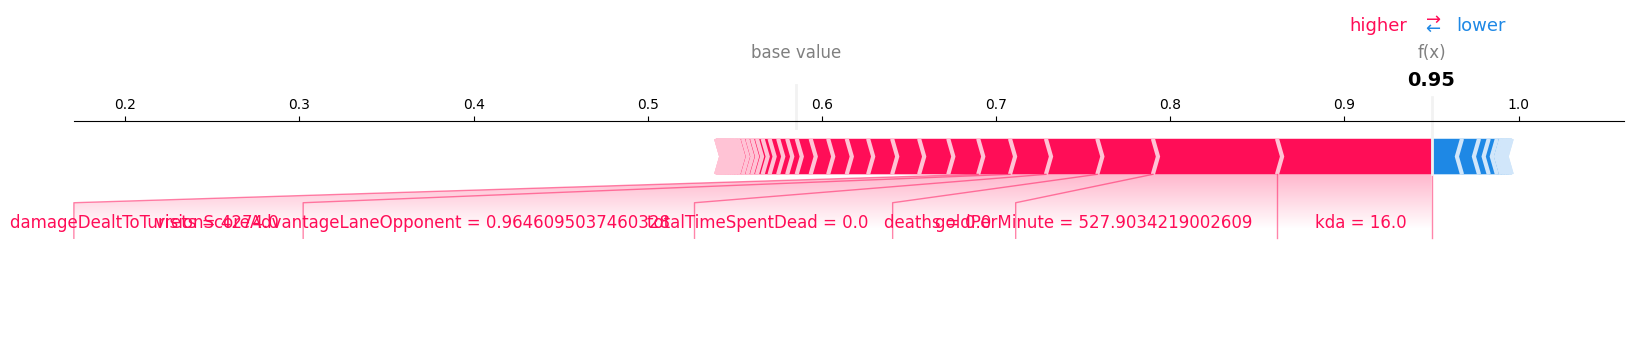

In [95]:
shap.force_plot(explainer.expected_value[1], shap_valuesGuwon[1][0], X_testGuwon.iloc[0], matplotlib=True)

In [96]:
features = [
    'kda',
    'goldPerMinute',
    'deaths',
    'damageDealtToTurrets',
    'totalTimeSpentDead',
    'damageDealtToBuildings',
    'damageDealtToObjectives',
    'magicDamageTaken',
    'visionScoreAdvantageLaneOpponent',
    'trueDamageTaken',
    'kills',
    'damagePerMinute',
    'turretKills',
    'GameTime',
    'assists',
    'totalPings',
    'totalDamageTaken',
    'killsNearEnemyTurret',
    'totalMinionsKilled',
    'MinionsKilledPerMin'
]
XGuwon = Guwon[features]
yGuwon = Guwon['result']

In [97]:
X_trainGuwon, X_testGuwon, y_trainGuwon, y_testGuwon = train_test_split(XGuwon, yGuwon, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

ensemble_clf = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], voting='soft')

ensemble_clf.fit(X_trainGuwon, y_trainGuwon)

y_pred_probaGuwon = ensemble_clf.predict_proba(X_testGuwon)[:, 1]

X_testGuwon['WinProba'] = y_pred_probaGuwon

y_predGuwon = ensemble_clf.predict(X_testGuwon.drop('WinProba', axis=1))
accuracy = accuracy_score(y_testGuwon, y_predGuwon)
print(f"Accuracy: {accuracy:.2f}")

Guwon.loc[:, 'WinProba'] = ensemble_clf.predict_proba(XGuwon)[:, 1]

Accuracy: 0.84


In [98]:
n_simulations = 500
feature_ranges = {feature: (Guwon[feature].mean(), Guwon[feature].std()) for feature in features}
scenarios = generate_scenarios(Guwon, features, feature_ranges, n_simulations)
simulated_win_probas = simulate_win_probabilities(scenarios, ensemble_clf)

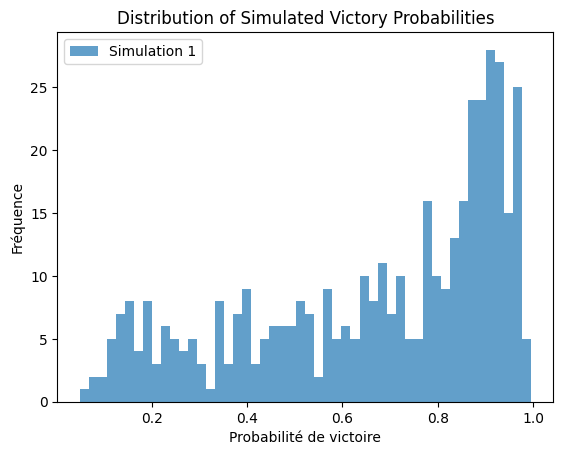

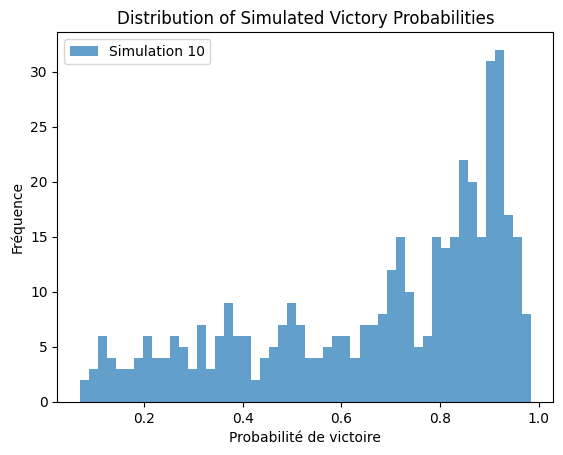

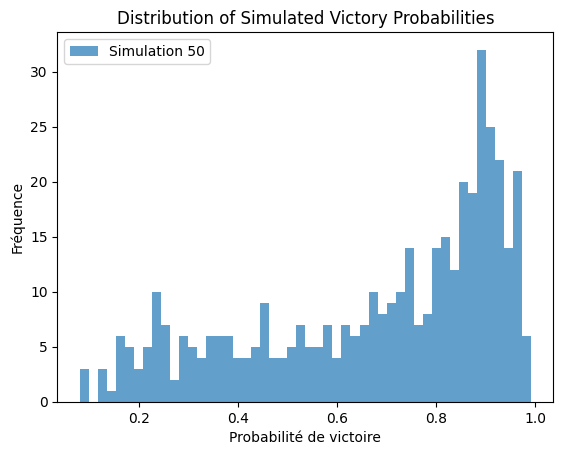

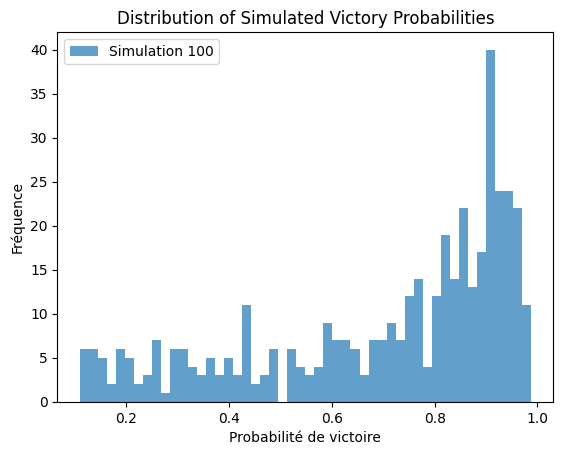

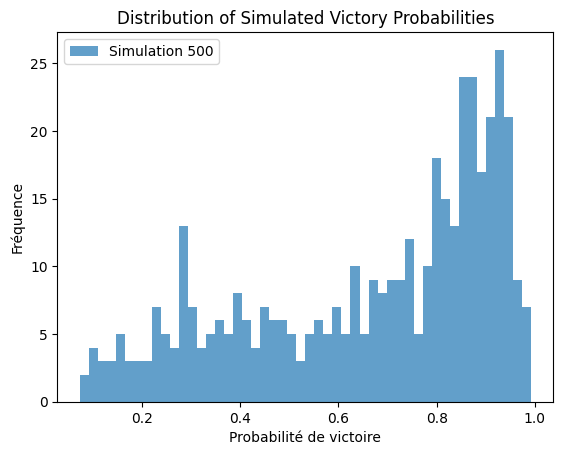

In [99]:
l = [0,9,49,99,499]
for i in l: 
    plt.hist(simulated_win_probas[i], bins=50, alpha=0.7, label=f'Simulation {i+1}')
    plt.xlabel('Probabilité de victoire')
    plt.ylabel('Fréquence')
    plt.title('Distribution of Simulated Victory Probabilities')
    plt.legend()
    plt.show()

In [100]:
feature_impacts = {feature: np.std([scenario[feature].mean() for scenario in scenarios]) for feature in features}
sorted_features = sorted(feature_impacts.items(), key=lambda item: item[1], reverse=True)
print("Most important features : ")
for feature, impact in sorted_features:
    print(f"{feature}: {impact}")

Most important features : 
damageDealtToObjectives: 720.5942537256742
totalDamageTaken: 511.122572641169
magicDamageTaken: 248.66752361593902
damageDealtToTurrets: 119.52708742040558
damageDealtToBuildings: 118.36229878957745
trueDamageTaken: 42.379654075941154
damagePerMinute: 11.956036734655372
totalTimeSpentDead: 3.729389682111859
goldPerMinute: 3.458643084195799
totalPings: 1.290998381068729
totalMinionsKilled: 0.7849565189631725
GameTime: 0.2936069416101235
kda: 0.25954426547396964
assists: 0.22488104060171593
kills: 0.19113349047339306
deaths: 0.11884131519812265
killsNearEnemyTurret: 0.08109967014158158
turretKills: 0.05514845590915286
visionScoreAdvantageLaneOpponent: 0.024714959848096317
MinionsKilledPerMin: 0.022964584123377145


In [101]:
combined_feature_impacts_increase = {}
combined_feature_impacts_decrease = {}
combined_features = ['goldPerMinute', 'totalPings', 'kda', 'totalDamageTaken']

for feature in combined_features:
    modified_scenarios_increase = []
    for scenario in scenarios:
        modified_scenario_increase = scenario.copy()
        modified_scenario_increase[feature] *= 1.1
        modified_scenarios_increase.append(modified_scenario_increase)
    combined_feature_impacts_increase[feature] = np.mean(simulate_win_probabilities(modified_scenarios_increase, ensemble_clf))
    
    modified_scenarios_decrease = []
    for scenario in scenarios:
        modified_scenario_decrease = scenario.copy()
        modified_scenario_decrease[feature] *= 0.9 
        modified_scenarios_decrease.append(modified_scenario_decrease)
    combined_feature_impacts_decrease[feature] = np.mean(simulate_win_probabilities(modified_scenarios_decrease, ensemble_clf))

print("Impact of increasing the feature by 10% : ")
print(combined_feature_impacts_increase)
print("Impact of decreasing the feature by 10%")
print(combined_feature_impacts_decrease)

Impact of increasing the feature by 10% : 
{'goldPerMinute': 0.7141716698483992, 'totalPings': 0.6549128139528966, 'kda': 0.6702604207887977, 'totalDamageTaken': 0.6625755115135036}
Impact of decreasing the feature by 10%
{'goldPerMinute': 0.5952140797483785, 'totalPings': 0.6685981552736125, 'kda': 0.6514893870646902, 'totalDamageTaken': 0.6619669667167364}


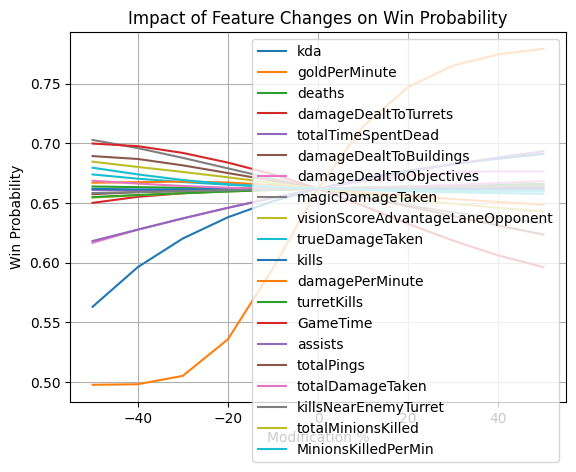

In [106]:
modification_percentages = np.linspace(-0.5, 0.5, 11)

feature_proba_vs_modification = calculate_feature_influence(scenarios, ensemble_clf, features, modification_percentages)

for feature, probabilities in feature_proba_vs_modification.items():
    plt.plot(modification_percentages * 100, probabilities, label=feature)

plt.xlabel('Modification %')
plt.ylabel('Win Probability')
plt.title('Impact of Feature Changes on Win Probability')
plt.legend()
plt.grid(True)
plt.show()

Model is not converging.  Current: -107256.93880753222 is not greater than -107256.84443964322. Delta is -0.09436788900347892


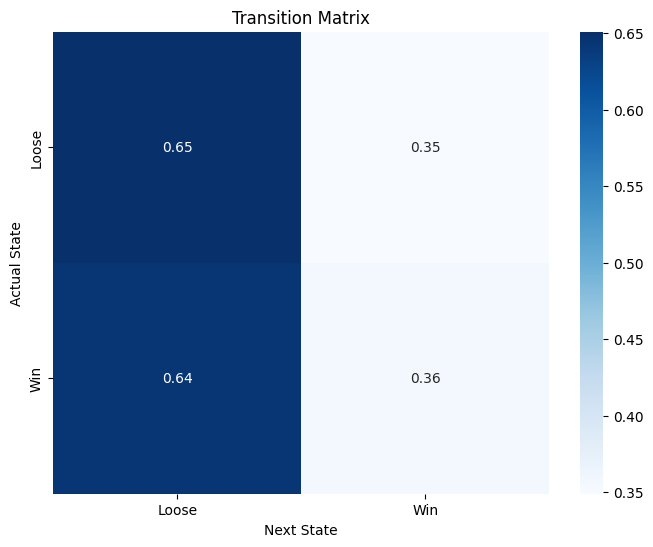

array([[0.65099483, 0.34900517],
       [0.64318579, 0.35681421]])

In [107]:
Guwon = Guwon.drop("WinProba", axis=1) 
XGuwon = Guwon[features]
yGuwon = Guwon['result']

XGuwon = Guwon.values
yGuwon = yGuwon.map({'victoire': 0, 'défaite': 1}).values

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
model.fit(Guwon)

transmat = model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transmat, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Loose", "Win"], yticklabels=["Loose", "Win"])
plt.title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Actual State")
plt.show()

transmat

In [108]:
victories = Guwon[Guwon['result'] == 1]
defeats = Guwon[Guwon['result'] == 0]

mean_stats_victories = victories.mean(numeric_only=True)
mean_stats_defeats = defeats.mean(numeric_only=True)

mean_stats = pd.DataFrame({
    'Victoire': mean_stats_victories,
    'Défaite': mean_stats_defeats
})

t_tests = {}
for column in victories.select_dtypes(include=[np.float64, np.int64]).columns:
    t_stat, p_val = ttest_ind(victories[column], defeats[column], equal_var=False)
    t_tests[column] = (t_stat, p_val)

t_tests_df = pd.DataFrame(t_tests, index=['t_stat', 'p_val']).T
significant_columns = t_tests_df[t_tests_df['p_val'] < 0.05].index.tolist()

significant_columns = [col for col in significant_columns if col in mean_stats.index]

print("Average statistics for wins and losses : ")
print(mean_stats)

Average statistics for wins and losses : 
                                        Victoire        Défaite
Team                                    0.371094       0.391813
GameTime                               23.951367      27.159747
result                                  1.000000       0.000000
kda                                     8.454848       2.678086
kills                                   8.250000       5.292398
deaths                                  2.890625       5.339181
assists                                 9.507812       6.959064
SoloKills                               0.667969       0.450292
quickSoloKills                          0.015625       0.000000
killsUnderOwnTurret                     0.464844       0.567251
killsNearEnemyTurret                    2.105469       0.988304
firstBloodAssist                        0.140625       0.070175
firstBloodKill                          0.156250       0.087719
doubleKills                             0.953125       0.47953

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [109]:
print("\nColumns with significant differences (p < 0.05) :")
print(t_tests_df[t_tests_df['p_val'] < 0.05])


Columns with significant differences (p < 0.05) :
                                      t_stat         p_val
GameTime                           -5.342020  1.664646e-07
result                                   inf  0.000000e+00
kda                                15.214728  2.306528e-40
kills                               8.186818  3.993305e-15
deaths                            -11.406754  7.754774e-26
assists                             6.075556  2.794482e-09
SoloKills                           2.578983  1.025956e-02
quickSoloKills                      2.011870  4.528551e-02
killsNearEnemyTurret                8.084239  6.574824e-15
doubleKills                         5.255956  2.341204e-07
tripleKills                         2.019104  4.411281e-02
killingSprees                       4.971880  1.044598e-06
turretKills                         7.360208  9.673245e-13
turretPlatesTaken                   3.054345  2.398280e-03
kTurretsDestroyedBeforePlatesFall   3.731003  2.205858e-04
visio

In [110]:
featuresb = [
    'GameTime', 'kda', 'kills', 'deaths', 'assists', 'SoloKills',
    'quickSoloKills', 'killsNearEnemyTurret', 'doubleKills', 'tripleKills',
    'killingSprees', 'turretKills', 'turretPlatesTaken',
    'kTurretsDestroyedBeforePlatesFall', 'visionScoreAdvantageLaneOpponent',
    'visionScorePerMinute', 'totalMinionsKilled', 'goldPerMinute',
    'laningPhaseGoldExpAdvantage', 'damagePerMinute', 'magicDamageTaken',
    'physicalDamageTaken', 'trueDamageTaken', 'totalDamageTaken',
    'damageDealtToBuildings', 'damageDealtToObjectives',
    'damageDealtToTurrets', 'totalTimeSpentDead', 'totalPings'
]

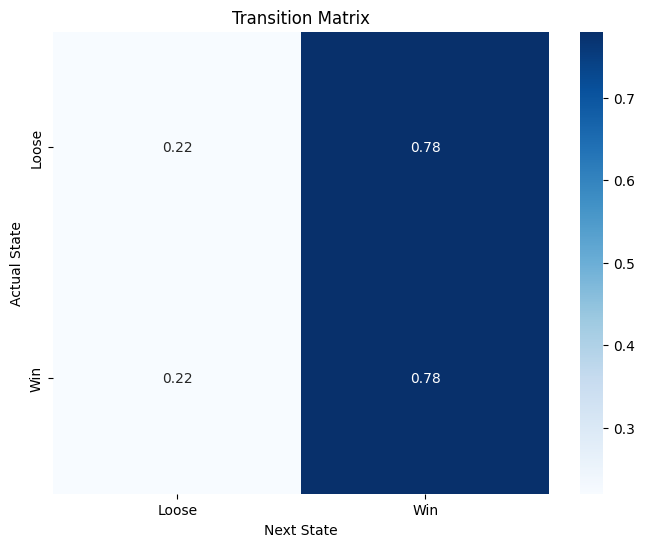

array([[0.22007864, 0.77992136],
       [0.22068085, 0.77931915]])

In [111]:
XGuwon = Guwon[featuresb]
yGuwon = Guwon['result']

XGuwon = XGuwon.values
yGuwon = yGuwon.map({'victoire': 0, 'défaite': 1}).values

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
model.fit(XGuwon)

transmat = model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transmat, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Loose", "Win"], yticklabels=["Loose", "Win"])
plt.title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Actual State")
plt.show()

transmat

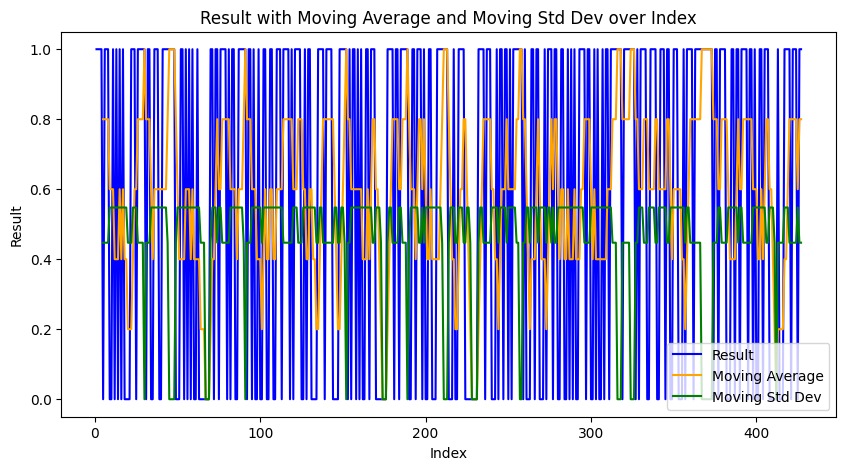

In [112]:
Guwon2 = Guwon.copy()
Guwon2['index'] = range(1, len(Guwon2) + 1)
Guwon2['Moving_Average'] = Guwon2['result'].rolling(window=5).mean()
Guwon2['Moving_Std_Dev'] = Guwon2['result'].rolling(window=5).std()

plt.figure(figsize=(10, 5))
plt.plot(Guwon2['index'], Guwon2['result'], label='Result', color='blue')
plt.plot(Guwon2['index'], Guwon2['Moving_Average'], label='Moving Average', color='orange')
plt.plot(Guwon2['index'], Guwon2['Moving_Std_Dev'], label='Moving Std Dev', color='green')
plt.xlabel('Index')
plt.ylabel('Result')
plt.title('Result with Moving Average and Moving Std Dev over Index')
plt.legend()
plt.show()

In [113]:
adf_result = adfuller(Guwon2['result'])
print(f"ADF Statistique test : {adf_result[0]}")
print(f"p-value : {adf_result[1]}")
print(f"Nb lags : {adf_result[2]}")
print(f"Nb observations : {adf_result[3]}")
print(f"Critical values : {adf_result[4]}")

kpss_result = kpss(Guwon2['result'], regression='c')
print(f"KPSS Statistique test : {kpss_result[0]}")
print(f"p-value : {kpss_result[1]}")
print(f"Nb lags : {kpss_result[2]}")
print(f"Critical values : {kpss_result[3]}")

ADF Statistique test : -19.732244898030512
p-value : 0.0
Nb lags : 0
Nb observations : 426
Critical values : {'1%': -3.4457939940402107, '5%': -2.8683485906158963, '10%': -2.570396746236417}
KPSS Statistique test : 0.15323754987948146
p-value : 0.1
Nb lags : 1
Critical values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



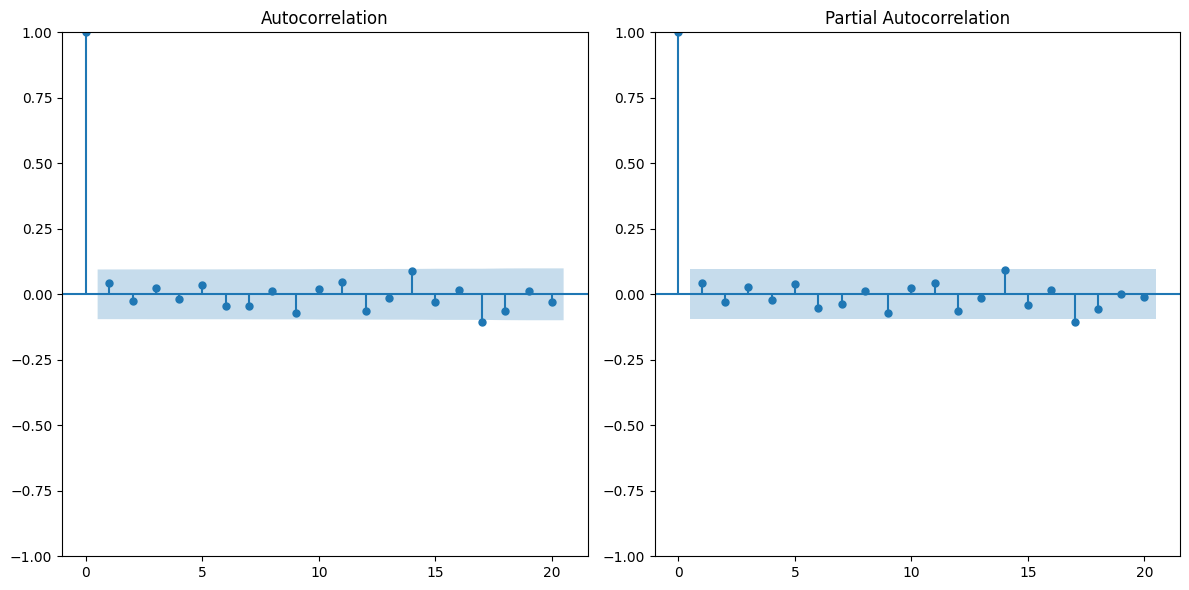

In [114]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(Guwon2['result'].dropna(), ax=plt.gca(), lags=20)

plt.subplot(122)
plot_pacf(Guwon2['result'].dropna(), ax=plt.gca(), lags=20, method='ywm')

plt.tight_layout()
plt.show()

In [115]:
model = ARIMA(Guwon2['result'], order=(1, 0, 2))
fitted_arima = model.fit()

model_sarima = SARIMAX(Guwon2['result'], order=(1, 0, 2), seasonal_order=(1, 0, 1, 12))
fitted_sarima = model_sarima.fit()

comparison = pd.DataFrame({
    "Model": ["ARIMA(1, 0, 2)", "SARIMA(1, 0, 2, 1, 0, 1, 12)"],
    "AIC": [fitted_arima.aic, fitted_sarima.aic],
    "BIC": [fitted_arima.bic, fitted_sarima.bic]
})

comparison

An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21081D+01    |proj g|=  1.56044D+02

At iterate    5    f=  1.04819D+00    |proj g|=  6.07983D-01

At iterate   10    f=  7.93996D-01    |proj g|=  5.37932D-02

At iterate   15    f=  7.88825D-01    |proj g|=  2.69729D-02

At iterate   20    f=  7.58504D-01    |proj g|=  2.35309D-02

At iterate   25    f=  7.43122D-01    |proj g|=  3.63172D-02

At iterate   30    f=  7.30924D-01    |proj g|=  1.80118D-02
  ys=-6.395E-03  -gs= 3.709E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  7.27848D-01    |proj g|=  3.06584D-02

At iterate   40    f=  7.27230D-01    |proj g|=  3.32755D-02

At iterate   45    f=  7.26613D-01    |proj g|=  3.51252D-02

At iterate   50    f=  7.22030D-01    |proj g|=  3.59483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     90      2     1     0   3.595D-03   7.220D-01
  F =  0.72203006501819722     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Maximum Likelihood optimization failed to converge. Check mle_retvals


Model         AIC         BIC
0                ARIMA(1, 0, 2)  611.510418  631.794338
1  SARIMA(1, 0, 2, 1, 0, 1, 12)  628.613676  652.954380

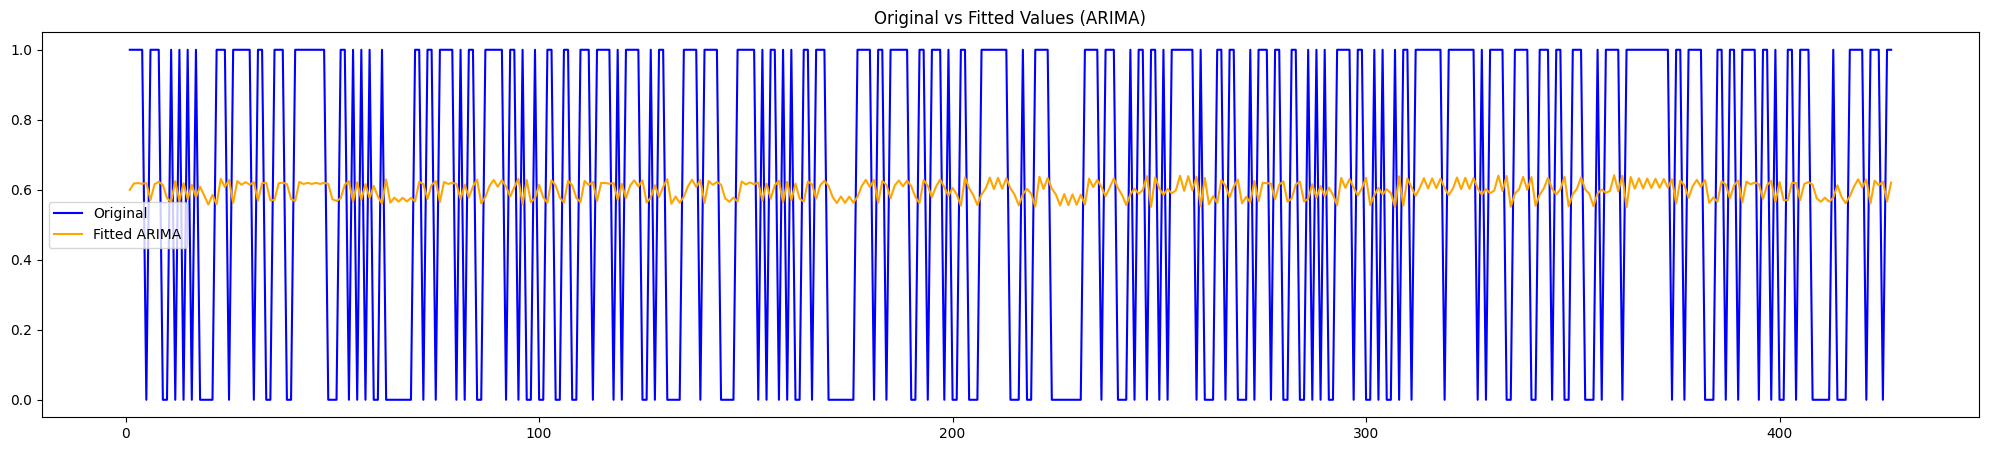

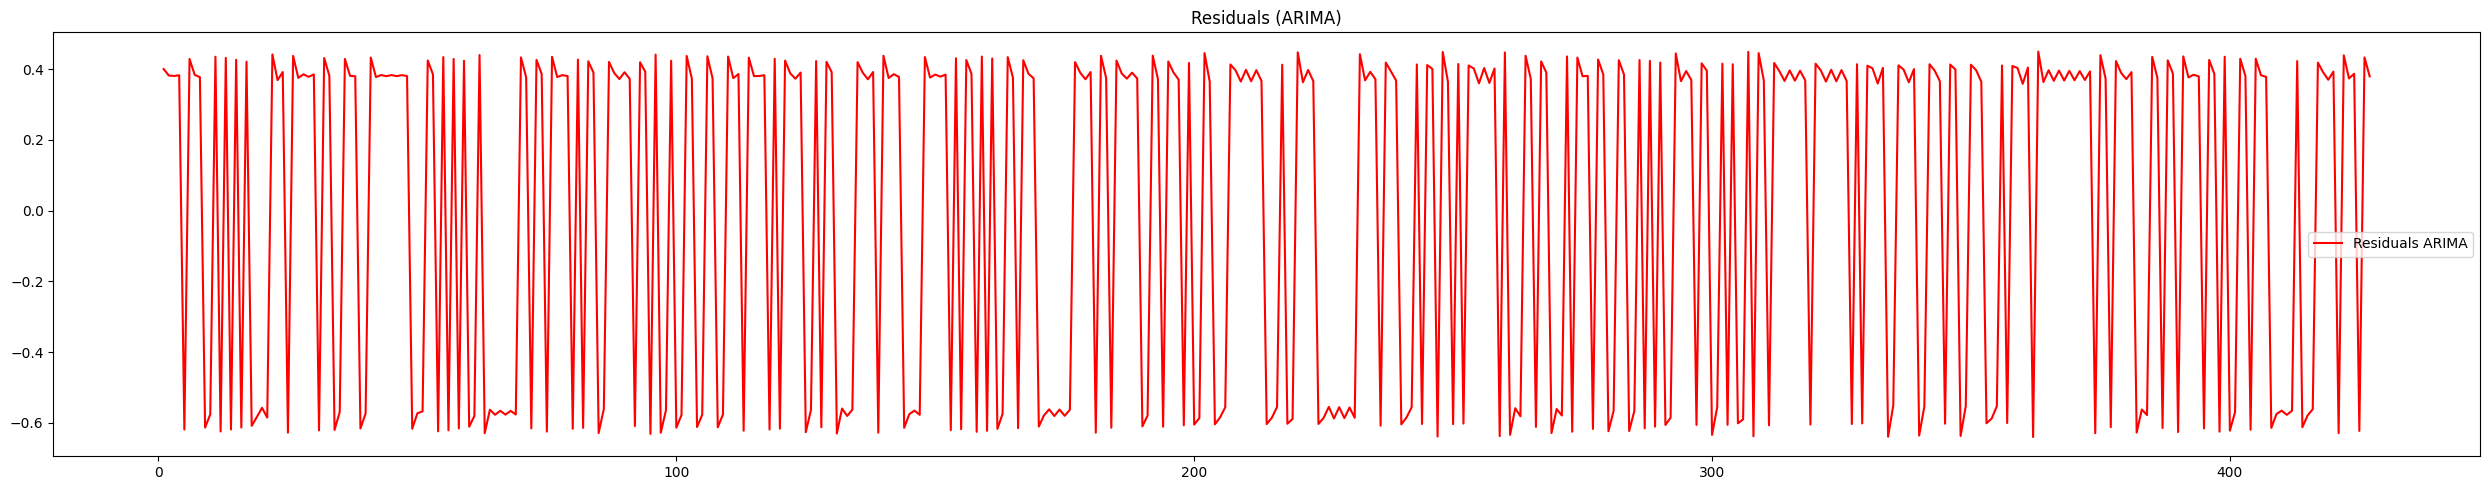

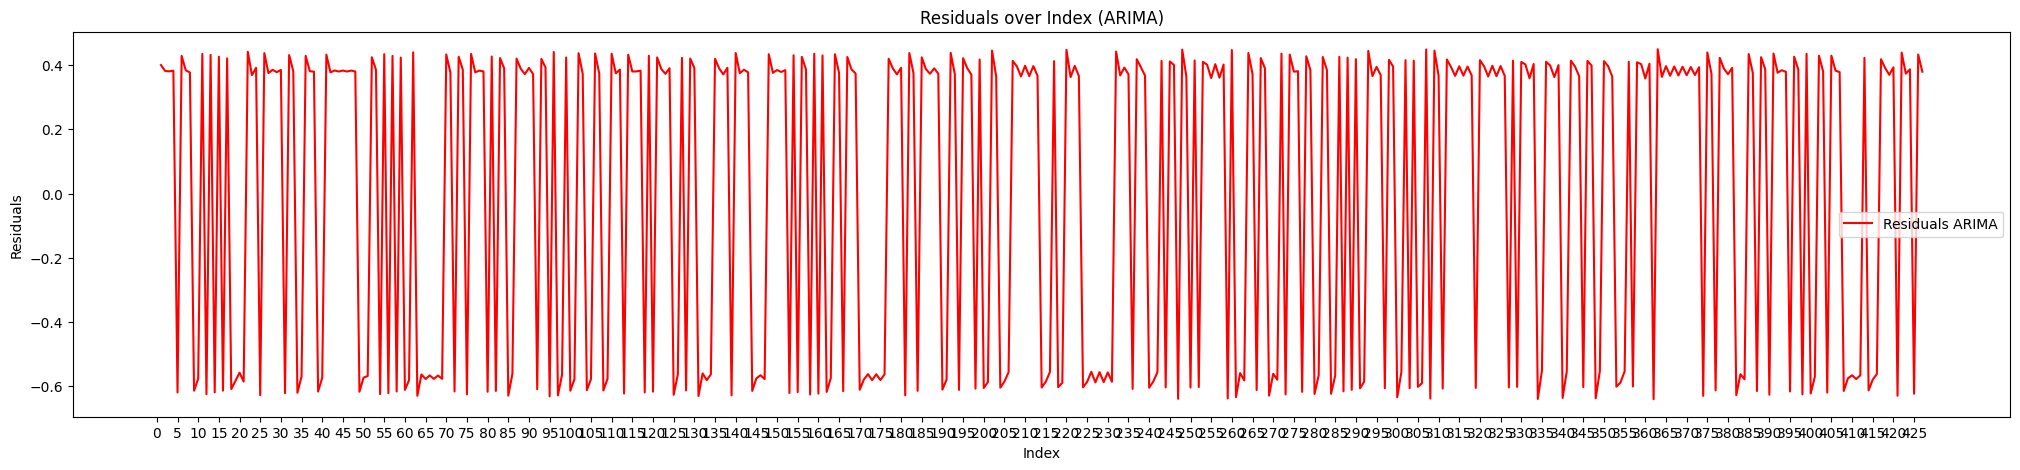

In [116]:
Guwon2['fitted_arima'] = fitted_arima.fittedvalues
Guwon2['residuals_arima'] = fitted_arima.resid

plt.figure(figsize=(25, 5))
plt.plot(Guwon2['index'], Guwon2['result'], label='Original', color='blue')
plt.plot(Guwon2['index'], Guwon2['fitted_arima'], label='Fitted ARIMA', color='orange')
plt.title('Original vs Fitted Values (ARIMA)')
plt.legend()

plt.figure(figsize=(25, 5))
plt.plot(Guwon2['index'], Guwon2['residuals_arima'], label='Residuals ARIMA', color='red')
plt.title('Residuals (ARIMA)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 5))
plt.plot(Guwon2['index'], Guwon2['residuals_arima'], label='Residuals ARIMA', color='red')
plt.title('Residuals over Index (ARIMA)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.xticks(ticks=range(0, len(Guwon2['index']), 5))
plt.legend()
plt.show()

In [121]:
stat, p = shapiro(Guwon2['residuals_arima'].dropna())
print('Shapiro-Wilk Test: Statistics=%.3f, p-value=%.3f' % (stat, p))

lb_test = acorr_ljungbox(Guwon2['residuals_arima'].dropna(), lags=[20], return_df=True)
print(lb_test)

Shapiro-Wilk Test: Statistics=0.668, p-value=0.000
      lb_stat  lb_pvalue
20  20.912066   0.402325
